In [1]:
# %% Load the required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sage import SAGEConv
import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
# %% data loading and pre-processing

df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
features = pd.Series(X.satisfaction) 
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

TEST = pd.read_csv('TEST_DF')
test_features = pd.Series(TEST.satisfaction)
test_vars = TEST.drop(columns=['Unnamed: 0','satisfaction'])
test_vars.Class = test_vars.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
test_wd = pd.get_dummies(data=test_vars,columns=['Customer Type','Type of Travel','Gender'])
test_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(test_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [4]:
# %%  load graph data

A = np.loadtxt('adjacency_matrix.csv', delimiter=',')
G = nx.from_numpy_matrix(A)
A_test = np.loadtxt('adjacency_matrix_test_graph.csv', delimiter=',')
G_test = nx.from_numpy_matrix(A_test)

In [5]:
# %% Normalization function

def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [6]:
# %% GraphSage Class

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, agg_type):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [7]:
# %% SumSage Class for sum-pooling

class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [8]:
# %% Simulation function

def Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False):

    train_acc_exp = []
    val_acc_exp = []
    exp_losses_train = []
    exp_losses_val = []
    test_acc = []
    plot_loss_test = []
    

    G_dgl_test = dgl.from_networkx(G_test)
    feat_test = TEST.drop(columns=['satisfaction'])
    feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
    feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

    G_dgl_test.ndata['feat'] =  torch.tensor(test_wd.values,dtype=torch.float)
    G_dgl_test.ndata['label'] = torch.tensor(test_features)
    
    node_features_test = G_dgl_test.ndata['feat']
    node_labels_test = G_dgl_test.ndata['label']
    test_nids = G_dgl_test.nodes()
    n_features_test = node_features_test.shape[1]
    n_labels_test = int(node_labels_test.max().item() + 1)
    
    for n in range(nExp):
        print('Experiment: {}'.format(n))
        
        G_dgl = dgl.from_networkx(G)
        G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
        G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
        G_dgl.ndata['label'] = torch.tensor(features)

        G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
        for i in range(len(G_dgl.ndata['train_mask'])):
            if G_dgl.ndata['train_mask'][i] == True:
                G_dgl.ndata['val_mask'][i] = False
            else:
                G_dgl.ndata['val_mask'][i] = True

        G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

        node_features = G_dgl.ndata['feat']
        node_labels = G_dgl.ndata['label']
        train_mask = G_dgl.ndata['train_mask']
        valid_mask = G_dgl.ndata['val_mask']
        n_features = node_features.shape[1]
        n_labels = int(node_labels.max().item() + 1)

        train_nodes = (train_mask == True).nonzero(as_tuple=False)
        train_nids = torch.reshape(train_nodes,(-1,))
        valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
        valid_nids = torch.reshape(valid_nodes,(-1,))

        batch_size = 50
        sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
        train_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, train_nids, sampler,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=0
        )

        batch_size = len(valid_nids)
        valid_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, valid_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )

        if sum_sage is True:
            model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
        else:
            model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type) #n_layers
        opt = torch.optim.Adam(model.parameters(), lr=0.002)


        best_accuracy = 0
        epoch_losses_train = []
        plot_loss_valid = []
        train_acc = []
        valid_acc = []
        dur = []

        for epoch in range(400):
            t0 = time.time()
            model.train()
            loss_epoch = 0
            accuracy_epoch = 0
            for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
                inputs = node_features[input_nodes]
                labels = node_labels[output_nodes]
                predictions = model(bipartites, inputs)

                loss = F.cross_entropy(predictions, labels)
                loss_epoch += loss.detach().item()
                opt.zero_grad()
                loss.backward()
                opt.step()

                accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
                accuracy_epoch += accuracy
            accuracy_epoch /= (step + 1)
            loss_epoch /= (step + 1)
            epoch_losses_train.append(loss_epoch)
            train_acc.append(accuracy_epoch)
            print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
            model.eval()
    
            predictions = []
            labels = []
            with torch.no_grad():
                for input_nodes, output_nodes, bipartites in valid_dataloader:
                    inputs = node_features[input_nodes]
                    labels.append(node_labels[output_nodes].numpy())
                    predictions.append(model(bipartites, inputs).argmax(1).numpy())
                    valid_pred = model(bipartites, inputs)
                    valid_labels = node_labels[output_nodes]
                    valid_loss = F.cross_entropy(valid_pred, valid_labels)

                predictions = np.concatenate(predictions)
                labels = np.concatenate(labels)
        
                accuracy = accuracy_score(labels, predictions)
                dur.append(time.time() - t0)
                print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
                valid_acc.append(accuracy.item())
                plot_loss_valid.append(valid_loss.item())

        train_acc_exp.append(train_acc[-1])
        val_acc_exp.append(valid_acc[-1])
        exp_losses_train.append(epoch_losses_train[-1])
        exp_losses_val.append(plot_loss_valid[-1])
        
        batch_size = len(test_nids)
        test_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl_test, test_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )
        
        test_predictions = []
        test_labels = []
        with torch.no_grad():
            for input_nodes, output_nodes, bipartites in test_dataloader:
                inputs = node_features_test[input_nodes]
                test_labels.append(node_labels_test[output_nodes].numpy())
                test_predictions.append(model(bipartites, inputs).argmax(1).numpy())
                test_pred = model(bipartites, inputs)
                test_lab = node_labels_test[output_nodes]
                test_loss = F.cross_entropy(test_pred, test_lab)

            test_predictions = np.concatenate(test_predictions)
            test_labels = np.concatenate(test_labels)
        
            test_accuracy = accuracy_score(test_labels, test_predictions)
            print('Epoch: {}, Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(epoch, test_accuracy, test_loss.item()))
            test_acc.append(test_accuracy.item())
            plot_loss_test.append(test_loss.item())
        

    return (train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_acc, plot_loss_test)


In [9]:
# %% Run Experiments mean

nExp = 100
train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_accuracy_exp, test_loss_exp = Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False)

Experiment: 0
Epoch: 0, Training Accuracy: 0.697, Training Loss: 0.608
Epoch: 0, Validation Accuracy: 0.769, Validation Loss: 0.545, Time: 1.7052
Epoch: 1, Training Accuracy: 0.800, Training Loss: 0.519
Epoch: 1, Validation Accuracy: 0.759, Validation Loss: 0.544, Time: 2.0070
Epoch: 2, Training Accuracy: 0.813, Training Loss: 0.499
Epoch: 2, Validation Accuracy: 0.830, Validation Loss: 0.489, Time: 1.9275
Epoch: 3, Training Accuracy: 0.832, Training Loss: 0.485
Epoch: 3, Validation Accuracy: 0.827, Validation Loss: 0.483, Time: 1.7349
Epoch: 4, Training Accuracy: 0.838, Training Loss: 0.478
Epoch: 4, Validation Accuracy: 0.845, Validation Loss: 0.472, Time: 1.6243
Epoch: 5, Training Accuracy: 0.841, Training Loss: 0.473
Epoch: 5, Validation Accuracy: 0.849, Validation Loss: 0.465, Time: 1.5435
Epoch: 6, Training Accuracy: 0.855, Training Loss: 0.459
Epoch: 6, Validation Accuracy: 0.861, Validation Loss: 0.455, Time: 1.5701
Epoch: 7, Training Accuracy: 0.853, Training Loss: 0.460
Epoch

Epoch: 62, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 62, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.4814
Epoch: 63, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 63, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.4832
Epoch: 64, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 64, Validation Accuracy: 0.893, Validation Loss: 0.415, Time: 1.4835
Epoch: 65, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 65, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.4852
Epoch: 66, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 66, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.4833
Epoch: 67, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 67, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.4784
Epoch: 68, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 68, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.4750
Epoch: 69, Training Accuracy: 0.905, Training Loss: 0.406
Epoc

Epoch: 123, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 123, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3851
Epoch: 124, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 124, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.3828
Epoch: 125, Training Accuracy: 0.928, Training Loss: 0.387
Epoch: 125, Validation Accuracy: 0.907, Validation Loss: 0.403, Time: 1.3807
Epoch: 126, Training Accuracy: 0.911, Training Loss: 0.403
Epoch: 126, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.3779
Epoch: 127, Training Accuracy: 0.918, Training Loss: 0.396
Epoch: 127, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.3758
Epoch: 128, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 128, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.3759
Epoch: 129, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 129, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.3800
Epoch: 130, Training Accuracy: 0.920, Training L

Epoch: 184, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 184, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.5496
Epoch: 185, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 185, Validation Accuracy: 0.934, Validation Loss: 0.373, Time: 1.5496
Epoch: 186, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 186, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.5497
Epoch: 187, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 187, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.5526
Epoch: 188, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 188, Validation Accuracy: 0.916, Validation Loss: 0.391, Time: 1.5504
Epoch: 189, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 189, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.5481
Epoch: 190, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 190, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.5458
Epoch: 191, Training Accuracy: 0.942, Training L

Epoch: 245, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 245, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.4962
Epoch: 246, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 246, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4950
Epoch: 247, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 247, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.4930
Epoch: 248, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 248, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.4918
Epoch: 249, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 249, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.4906
Epoch: 250, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 250, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.4895
Epoch: 251, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 251, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4891
Epoch: 252, Training Accuracy: 0.944, Training L

Epoch: 306, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 306, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.5186
Epoch: 307, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 307, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.5181
Epoch: 308, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 308, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.5174
Epoch: 309, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 309, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.5166
Epoch: 310, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 310, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.5158
Epoch: 311, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 311, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.5149
Epoch: 312, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 312, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.5141
Epoch: 313, Training Accuracy: 0.940, Training L

Epoch: 367, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 367, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4938
Epoch: 368, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 368, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 1.4945
Epoch: 369, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 369, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.4947
Epoch: 370, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 370, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.4942
Epoch: 371, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 371, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.4950
Epoch: 372, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 372, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.4996
Epoch: 373, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 373, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.5018
Epoch: 374, Training Accuracy: 0.942, Training L

Epoch: 28, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 28, Validation Accuracy: 0.896, Validation Loss: 0.412, Time: 1.2323
Epoch: 29, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 29, Validation Accuracy: 0.903, Validation Loss: 0.410, Time: 1.2309
Epoch: 30, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 30, Validation Accuracy: 0.900, Validation Loss: 0.407, Time: 1.2274
Epoch: 31, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 31, Validation Accuracy: 0.907, Validation Loss: 0.408, Time: 1.2206
Epoch: 32, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 32, Validation Accuracy: 0.906, Validation Loss: 0.407, Time: 1.2143
Epoch: 33, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 33, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.2084
Epoch: 34, Training Accuracy: 0.906, Training Loss: 0.408
Epoch: 34, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.2287
Epoch: 35, Training Accuracy: 0.908, Training Loss: 0.405
Epoc

Epoch: 90, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 90, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.2162
Epoch: 91, Training Accuracy: 0.936, Training Loss: 0.379
Epoch: 91, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2216
Epoch: 92, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 92, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.2563
Epoch: 93, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 93, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.2886
Epoch: 94, Training Accuracy: 0.940, Training Loss: 0.375
Epoch: 94, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.3151
Epoch: 95, Training Accuracy: 0.934, Training Loss: 0.381
Epoch: 95, Validation Accuracy: 0.906, Validation Loss: 0.398, Time: 1.3295
Epoch: 96, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 96, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.3405
Epoch: 97, Training Accuracy: 0.928, Training Loss: 0.385
Epoc

Epoch: 151, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 151, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.6445
Epoch: 152, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 152, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.6436
Epoch: 153, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 153, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.6422
Epoch: 154, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 154, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.6531
Epoch: 155, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 155, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.6517
Epoch: 156, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 156, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.6505
Epoch: 157, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 157, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.6489
Epoch: 158, Training Accuracy: 0.940, Training L

Epoch: 212, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 212, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.6597
Epoch: 213, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 213, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.6589
Epoch: 214, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 214, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.6580
Epoch: 215, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 215, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.6572
Epoch: 216, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 216, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.6567
Epoch: 217, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 217, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.6560
Epoch: 218, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 218, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.6564
Epoch: 219, Training Accuracy: 0.942, Training L

Epoch: 273, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 273, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.8013
Epoch: 274, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 274, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.7988
Epoch: 275, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 275, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.7977
Epoch: 276, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 276, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.7977
Epoch: 277, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 277, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.7962
Epoch: 278, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 278, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.7962
Epoch: 279, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 279, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.7943
Epoch: 280, Training Accuracy: 0.946, Training L

Epoch: 334, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 334, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.7206
Epoch: 335, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 335, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.7189
Epoch: 336, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 336, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.7171
Epoch: 337, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 337, Validation Accuracy: 0.941, Validation Loss: 0.367, Time: 1.7154
Epoch: 338, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 338, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.7136
Epoch: 339, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 339, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.7119
Epoch: 340, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 340, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.7102
Epoch: 341, Training Accuracy: 0.935, Training L

Epoch: 395, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 395, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.6460
Epoch: 396, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 396, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.6463
Epoch: 397, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 397, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.6453
Epoch: 398, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 398, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.6441
Epoch: 399, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 399, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.6436
Epoch: 399, Test Accuracy: 0.935, Test Loss: 0.376
Experiment: 2
Epoch: 0, Training Accuracy: 0.671, Training Loss: 0.631
Epoch: 0, Validation Accuracy: 0.764, Validation Loss: 0.570, Time: 1.0607
Epoch: 1, Training Accuracy: 0.806, Training Loss: 0.523
Epoch: 1, Validation Accuracy: 0.823, Validation Loss: 0.494, Time

Epoch: 56, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 56, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.1703
Epoch: 57, Training Accuracy: 0.906, Training Loss: 0.407
Epoch: 57, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.1718
Epoch: 58, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 58, Validation Accuracy: 0.926, Validation Loss: 0.382, Time: 1.1764
Epoch: 59, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 59, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1811
Epoch: 60, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 60, Validation Accuracy: 0.926, Validation Loss: 0.389, Time: 1.1850
Epoch: 61, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 61, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.1841
Epoch: 62, Training Accuracy: 0.908, Training Loss: 0.406
Epoch: 62, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.1820
Epoch: 63, Training Accuracy: 0.907, Training Loss: 0.406
Epoc

Epoch: 117, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 117, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2312
Epoch: 118, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 118, Validation Accuracy: 0.946, Validation Loss: 0.370, Time: 1.2305
Epoch: 119, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 119, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.2300
Epoch: 120, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 120, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2293
Epoch: 121, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 121, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.2283
Epoch: 122, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 122, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2274
Epoch: 123, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 123, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.2265
Epoch: 124, Training Accuracy: 0.918, Training L

Epoch: 178, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 178, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.3797
Epoch: 179, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 179, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.3826
Epoch: 180, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 180, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.3860
Epoch: 181, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 181, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3884
Epoch: 182, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 182, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.3913
Epoch: 183, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 183, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.3931
Epoch: 184, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 184, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.3981
Epoch: 185, Training Accuracy: 0.923, Training L

Epoch: 239, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 239, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.3614
Epoch: 240, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 240, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.3610
Epoch: 241, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 241, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.3608
Epoch: 242, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 242, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.3603
Epoch: 243, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 243, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.3592
Epoch: 244, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 244, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.3586
Epoch: 245, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 245, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3577
Epoch: 246, Training Accuracy: 0.939, Training L

Epoch: 300, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 300, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3398
Epoch: 301, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 301, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.3393
Epoch: 302, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 302, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.3386
Epoch: 303, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 303, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.3380
Epoch: 304, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 304, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3373
Epoch: 305, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 305, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.3372
Epoch: 306, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 306, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.3378
Epoch: 307, Training Accuracy: 0.939, Training L

Epoch: 361, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 361, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.3350
Epoch: 362, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 362, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.3345
Epoch: 363, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 363, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.3339
Epoch: 364, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 364, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.3334
Epoch: 365, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 365, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.3327
Epoch: 366, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 366, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.3321
Epoch: 367, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 367, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3315
Epoch: 368, Training Accuracy: 0.918, Training L

Epoch: 22, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 22, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.2121
Epoch: 23, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 23, Validation Accuracy: 0.884, Validation Loss: 0.426, Time: 1.2171
Epoch: 24, Training Accuracy: 0.898, Training Loss: 0.411
Epoch: 24, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.2334
Epoch: 25, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 25, Validation Accuracy: 0.895, Validation Loss: 0.420, Time: 1.2350
Epoch: 26, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 26, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.2304
Epoch: 27, Training Accuracy: 0.909, Training Loss: 0.406
Epoch: 27, Validation Accuracy: 0.918, Validation Loss: 0.397, Time: 1.2284
Epoch: 28, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 28, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.2269
Epoch: 29, Training Accuracy: 0.906, Training Loss: 0.404
Epoc

Epoch: 84, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 84, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2422
Epoch: 85, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 85, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2408
Epoch: 86, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 86, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2380
Epoch: 87, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 87, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.2350
Epoch: 88, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 88, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.2321
Epoch: 89, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 89, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2294
Epoch: 90, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 90, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2267
Epoch: 91, Training Accuracy: 0.934, Training Loss: 0.380
Epoc

Epoch: 145, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 145, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.3210
Epoch: 146, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 146, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.3266
Epoch: 147, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 147, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.3259
Epoch: 148, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 148, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.3256
Epoch: 149, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 149, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.3249
Epoch: 150, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 150, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3257
Epoch: 151, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 151, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3264
Epoch: 152, Training Accuracy: 0.941, Training L

Epoch: 206, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 206, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.3032
Epoch: 207, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 207, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.3023
Epoch: 208, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 208, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3016
Epoch: 209, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 209, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3010
Epoch: 210, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 210, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.3043
Epoch: 211, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 211, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.3077
Epoch: 212, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 212, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.3116
Epoch: 213, Training Accuracy: 0.947, Training L

Epoch: 267, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 267, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.3196
Epoch: 268, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 268, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.3187
Epoch: 269, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 269, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.3188
Epoch: 270, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 270, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.3188
Epoch: 271, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 271, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.3192
Epoch: 272, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 272, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3197
Epoch: 273, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 273, Validation Accuracy: 0.958, Validation Loss: 0.359, Time: 1.3206
Epoch: 274, Training Accuracy: 0.946, Training L

Epoch: 328, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 328, Validation Accuracy: 0.958, Validation Loss: 0.357, Time: 1.3736
Epoch: 329, Training Accuracy: 0.943, Training Loss: 0.367
Epoch: 329, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.3730
Epoch: 330, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 330, Validation Accuracy: 0.952, Validation Loss: 0.364, Time: 1.3727
Epoch: 331, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 331, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.3723
Epoch: 332, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 332, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.3749
Epoch: 333, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 333, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.3749
Epoch: 334, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 334, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.3743
Epoch: 335, Training Accuracy: 0.950, Training L

Epoch: 389, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 389, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.3910
Epoch: 390, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 390, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3900
Epoch: 391, Training Accuracy: 0.947, Training Loss: 0.363
Epoch: 391, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.3889
Epoch: 392, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 392, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3879
Epoch: 393, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 393, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.3869
Epoch: 394, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 394, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.3858
Epoch: 395, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 395, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.3848
Epoch: 396, Training Accuracy: 0.952, Training L

Epoch: 50, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 50, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 1.1628
Epoch: 51, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 51, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.1616
Epoch: 52, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 52, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1596
Epoch: 53, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 53, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 1.1561
Epoch: 54, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 54, Validation Accuracy: 0.909, Validation Loss: 0.399, Time: 1.1533
Epoch: 55, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 55, Validation Accuracy: 0.903, Validation Loss: 0.404, Time: 1.1543
Epoch: 56, Training Accuracy: 0.906, Training Loss: 0.403
Epoch: 56, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.1547
Epoch: 57, Training Accuracy: 0.910, Training Loss: 0.400
Epoc

Epoch: 111, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 111, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.1692
Epoch: 112, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 112, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1673
Epoch: 113, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 113, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1667
Epoch: 114, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 114, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.1659
Epoch: 115, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 115, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.1654
Epoch: 116, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 116, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.1650
Epoch: 117, Training Accuracy: 0.934, Training Loss: 0.381
Epoch: 117, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1646
Epoch: 118, Training Accuracy: 0.924, Training L

Epoch: 172, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 172, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2328
Epoch: 173, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 173, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2329
Epoch: 174, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 174, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2325
Epoch: 175, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 175, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2321
Epoch: 176, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 176, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2317
Epoch: 177, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 177, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2311
Epoch: 178, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 178, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2306
Epoch: 179, Training Accuracy: 0.941, Training L

Epoch: 233, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 233, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.3508
Epoch: 234, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 234, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.3516
Epoch: 235, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 235, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3515
Epoch: 236, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 236, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.3514
Epoch: 237, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 237, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.3532
Epoch: 238, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 238, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.3535
Epoch: 239, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 239, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.3542
Epoch: 240, Training Accuracy: 0.942, Training L

Epoch: 294, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 294, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.4726
Epoch: 295, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 295, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.4759
Epoch: 296, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 296, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4775
Epoch: 297, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 297, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.4771
Epoch: 298, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 298, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.4762
Epoch: 299, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 299, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.4753
Epoch: 300, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 300, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.4757
Epoch: 301, Training Accuracy: 0.946, Training L

Epoch: 355, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 355, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.4649
Epoch: 356, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 356, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4639
Epoch: 357, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 357, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.4628
Epoch: 358, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 358, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.4615
Epoch: 359, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 359, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.4601
Epoch: 360, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 360, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.4602
Epoch: 361, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 361, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.4590
Epoch: 362, Training Accuracy: 0.949, Training L

Epoch: 16, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 16, Validation Accuracy: 0.879, Validation Loss: 0.427, Time: 1.0993
Epoch: 17, Training Accuracy: 0.880, Training Loss: 0.434
Epoch: 17, Validation Accuracy: 0.888, Validation Loss: 0.423, Time: 1.0937
Epoch: 18, Training Accuracy: 0.880, Training Loss: 0.432
Epoch: 18, Validation Accuracy: 0.884, Validation Loss: 0.428, Time: 1.0963
Epoch: 19, Training Accuracy: 0.880, Training Loss: 0.430
Epoch: 19, Validation Accuracy: 0.887, Validation Loss: 0.424, Time: 1.0992
Epoch: 20, Training Accuracy: 0.882, Training Loss: 0.430
Epoch: 20, Validation Accuracy: 0.889, Validation Loss: 0.423, Time: 1.1032
Epoch: 21, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 21, Validation Accuracy: 0.884, Validation Loss: 0.425, Time: 1.1147
Epoch: 22, Training Accuracy: 0.877, Training Loss: 0.435
Epoch: 22, Validation Accuracy: 0.893, Validation Loss: 0.424, Time: 1.1197
Epoch: 23, Training Accuracy: 0.887, Training Loss: 0.426
Epoc

Epoch: 78, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 78, Validation Accuracy: 0.926, Validation Loss: 0.382, Time: 1.1914
Epoch: 79, Training Accuracy: 0.897, Training Loss: 0.413
Epoch: 79, Validation Accuracy: 0.890, Validation Loss: 0.421, Time: 1.1909
Epoch: 80, Training Accuracy: 0.911, Training Loss: 0.404
Epoch: 80, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.1887
Epoch: 81, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 81, Validation Accuracy: 0.902, Validation Loss: 0.407, Time: 1.1864
Epoch: 82, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 82, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.1846
Epoch: 83, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 83, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.1845
Epoch: 84, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 84, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.1868
Epoch: 85, Training Accuracy: 0.922, Training Loss: 0.391
Epoc

Epoch: 139, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 139, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.1979
Epoch: 140, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 140, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.2024
Epoch: 141, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 141, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2041
Epoch: 142, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 142, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2065
Epoch: 143, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 143, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2105
Epoch: 144, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 144, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2112
Epoch: 145, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 145, Validation Accuracy: 0.919, Validation Loss: 0.389, Time: 1.2131
Epoch: 146, Training Accuracy: 0.932, Training L

Epoch: 200, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 200, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2399
Epoch: 201, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 201, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.2460
Epoch: 202, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 202, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2507
Epoch: 203, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 203, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2512
Epoch: 204, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 204, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.2521
Epoch: 205, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 205, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2532
Epoch: 206, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 206, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2521
Epoch: 207, Training Accuracy: 0.934, Training L

Epoch: 261, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 261, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2582
Epoch: 262, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 262, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.2573
Epoch: 263, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 263, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2563
Epoch: 264, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 264, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2552
Epoch: 265, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 265, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2542
Epoch: 266, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 266, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2531
Epoch: 267, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 267, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.2520
Epoch: 268, Training Accuracy: 0.941, Training L

Epoch: 322, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 322, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.2515
Epoch: 323, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 323, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2526
Epoch: 324, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 324, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2531
Epoch: 325, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 325, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2537
Epoch: 326, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 326, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.2535
Epoch: 327, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 327, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2531
Epoch: 328, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 328, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.2527
Epoch: 329, Training Accuracy: 0.936, Training L

Epoch: 383, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 383, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.2410
Epoch: 384, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 384, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2419
Epoch: 385, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 385, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2416
Epoch: 386, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 386, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2414
Epoch: 387, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 387, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2411
Epoch: 388, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 388, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2409
Epoch: 389, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 389, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2406
Epoch: 390, Training Accuracy: 0.940, Training L

Epoch: 44, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 44, Validation Accuracy: 0.915, Validation Loss: 0.400, Time: 1.1716
Epoch: 45, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 45, Validation Accuracy: 0.924, Validation Loss: 0.394, Time: 1.1696
Epoch: 46, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 46, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 1.1666
Epoch: 47, Training Accuracy: 0.914, Training Loss: 0.400
Epoch: 47, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 1.1632
Epoch: 48, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 48, Validation Accuracy: 0.924, Validation Loss: 0.392, Time: 1.1644
Epoch: 49, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 49, Validation Accuracy: 0.889, Validation Loss: 0.421, Time: 1.1729
Epoch: 50, Training Accuracy: 0.918, Training Loss: 0.396
Epoch: 50, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.1747
Epoch: 51, Training Accuracy: 0.920, Training Loss: 0.394
Epoc

Epoch: 106, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 106, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1584
Epoch: 107, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 107, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 1.1568
Epoch: 108, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 108, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.1563
Epoch: 109, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 109, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.1557
Epoch: 110, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 110, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1543
Epoch: 111, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 111, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1535
Epoch: 112, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 112, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.1524
Epoch: 113, Training Accuracy: 0.938, Training L

Epoch: 167, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 167, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.1794
Epoch: 168, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 168, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.1791
Epoch: 169, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 169, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.1805
Epoch: 170, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 170, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.1831
Epoch: 171, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 171, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.1826
Epoch: 172, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 172, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1840
Epoch: 173, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 173, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1841
Epoch: 174, Training Accuracy: 0.941, Training L

Epoch: 228, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 228, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2486
Epoch: 229, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 229, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2481
Epoch: 230, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 230, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2475
Epoch: 231, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 231, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2470
Epoch: 232, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 232, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2464
Epoch: 233, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 233, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.2460
Epoch: 234, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 234, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.2454
Epoch: 235, Training Accuracy: 0.942, Training L

Epoch: 289, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 289, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.2308
Epoch: 290, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 290, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.2305
Epoch: 291, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 291, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2303
Epoch: 292, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 292, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2300
Epoch: 293, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 293, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2296
Epoch: 294, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 294, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.2293
Epoch: 295, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 295, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2291
Epoch: 296, Training Accuracy: 0.943, Training L

Epoch: 350, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 350, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2477
Epoch: 351, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 351, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2489
Epoch: 352, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 352, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2485
Epoch: 353, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 353, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2481
Epoch: 354, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 354, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2477
Epoch: 355, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 355, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2472
Epoch: 356, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 356, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.2468
Epoch: 357, Training Accuracy: 0.939, Training L

Epoch: 11, Training Accuracy: 0.864, Training Loss: 0.447
Epoch: 11, Validation Accuracy: 0.888, Validation Loss: 0.425, Time: 1.2424
Epoch: 12, Training Accuracy: 0.866, Training Loss: 0.444
Epoch: 12, Validation Accuracy: 0.900, Validation Loss: 0.420, Time: 1.2346
Epoch: 13, Training Accuracy: 0.869, Training Loss: 0.444
Epoch: 13, Validation Accuracy: 0.892, Validation Loss: 0.421, Time: 1.2264
Epoch: 14, Training Accuracy: 0.869, Training Loss: 0.442
Epoch: 14, Validation Accuracy: 0.901, Validation Loss: 0.415, Time: 1.2427
Epoch: 15, Training Accuracy: 0.874, Training Loss: 0.437
Epoch: 15, Validation Accuracy: 0.895, Validation Loss: 0.415, Time: 1.2401
Epoch: 16, Training Accuracy: 0.877, Training Loss: 0.436
Epoch: 16, Validation Accuracy: 0.894, Validation Loss: 0.422, Time: 1.2273
Epoch: 17, Training Accuracy: 0.877, Training Loss: 0.434
Epoch: 17, Validation Accuracy: 0.884, Validation Loss: 0.427, Time: 1.2181
Epoch: 18, Training Accuracy: 0.871, Training Loss: 0.439
Epoc

Epoch: 73, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 73, Validation Accuracy: 0.915, Validation Loss: 0.392, Time: 1.1873
Epoch: 74, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 74, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.1868
Epoch: 75, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 75, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.1864
Epoch: 76, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 76, Validation Accuracy: 0.882, Validation Loss: 0.425, Time: 1.1860
Epoch: 77, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 77, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1860
Epoch: 78, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 78, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1854
Epoch: 79, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 79, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.1831
Epoch: 80, Training Accuracy: 0.909, Training Loss: 0.404
Epoc

Epoch: 134, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 134, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1136
Epoch: 135, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 135, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1137
Epoch: 136, Training Accuracy: 0.938, Training Loss: 0.377
Epoch: 136, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1142
Epoch: 137, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 137, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.1142
Epoch: 138, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 138, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1132
Epoch: 139, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 139, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.1120
Epoch: 140, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 140, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.1108
Epoch: 141, Training Accuracy: 0.938, Training L

Epoch: 195, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 195, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1155
Epoch: 196, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 196, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.1156
Epoch: 197, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 197, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1181
Epoch: 198, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 198, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1208
Epoch: 199, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 199, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1222
Epoch: 200, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 200, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.1256
Epoch: 201, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 201, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1280
Epoch: 202, Training Accuracy: 0.940, Training L

Epoch: 256, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 256, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1298
Epoch: 257, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 257, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1299
Epoch: 258, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 258, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.1302
Epoch: 259, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 259, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1305
Epoch: 260, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 260, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.1308
Epoch: 261, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 261, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.1311
Epoch: 262, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 262, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.1307
Epoch: 263, Training Accuracy: 0.939, Training L

Epoch: 317, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 317, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.1412
Epoch: 318, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 318, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1418
Epoch: 319, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 319, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.1417
Epoch: 320, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 320, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.1413
Epoch: 321, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 321, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1411
Epoch: 322, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 322, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.1409
Epoch: 323, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 323, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1407
Epoch: 324, Training Accuracy: 0.941, Training L

Epoch: 378, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 378, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1477
Epoch: 379, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 379, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1479
Epoch: 380, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 380, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1481
Epoch: 381, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 381, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.1485
Epoch: 382, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 382, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.1488
Epoch: 383, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 383, Validation Accuracy: 0.954, Validation Loss: 0.362, Time: 1.1490
Epoch: 384, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 384, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.1494
Epoch: 385, Training Accuracy: 0.944, Training L

Epoch: 39, Training Accuracy: 0.894, Training Loss: 0.417
Epoch: 39, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.3124
Epoch: 40, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 40, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.3047
Epoch: 41, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 41, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.2976
Epoch: 42, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 42, Validation Accuracy: 0.899, Validation Loss: 0.412, Time: 1.2896
Epoch: 43, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 43, Validation Accuracy: 0.901, Validation Loss: 0.406, Time: 1.2823
Epoch: 44, Training Accuracy: 0.900, Training Loss: 0.414
Epoch: 44, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.2749
Epoch: 45, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 45, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.2683
Epoch: 46, Training Accuracy: 0.898, Training Loss: 0.414
Epoc

Epoch: 101, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 101, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2187
Epoch: 102, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 102, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.2181
Epoch: 103, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 103, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2177
Epoch: 104, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 104, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.2171
Epoch: 105, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 105, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2167
Epoch: 106, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 106, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.2161
Epoch: 107, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 107, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2155
Epoch: 108, Training Accuracy: 0.932, Training L

Epoch: 162, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 162, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.2224
Epoch: 163, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 163, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2275
Epoch: 164, Training Accuracy: 0.943, Training Loss: 0.372
Epoch: 164, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2275
Epoch: 165, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 165, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2276
Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 166, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2286
Epoch: 167, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 167, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2283
Epoch: 168, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 168, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.2282
Epoch: 169, Training Accuracy: 0.940, Training L

Epoch: 223, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 223, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2799
Epoch: 224, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 224, Validation Accuracy: 0.950, Validation Loss: 0.359, Time: 1.2811
Epoch: 225, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 225, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2819
Epoch: 226, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 226, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2854
Epoch: 227, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 227, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.2846
Epoch: 228, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 228, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2845
Epoch: 229, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 229, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.2839
Epoch: 230, Training Accuracy: 0.948, Training L

Epoch: 284, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 284, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.4405
Epoch: 285, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 285, Validation Accuracy: 0.959, Validation Loss: 0.354, Time: 1.4401
Epoch: 286, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 286, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4408
Epoch: 287, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 287, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 1.4403
Epoch: 288, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 288, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.4396
Epoch: 289, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 289, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.4388
Epoch: 290, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 290, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.4381
Epoch: 291, Training Accuracy: 0.947, Training L

Epoch: 345, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 345, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.4212
Epoch: 346, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 346, Validation Accuracy: 0.959, Validation Loss: 0.355, Time: 1.4204
Epoch: 347, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 347, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.4195
Epoch: 348, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 348, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.4188
Epoch: 349, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 349, Validation Accuracy: 0.959, Validation Loss: 0.353, Time: 1.4178
Epoch: 350, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 350, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.4169
Epoch: 351, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 351, Validation Accuracy: 0.951, Validation Loss: 0.358, Time: 1.4161
Epoch: 352, Training Accuracy: 0.949, Training L

Epoch: 5, Training Accuracy: 0.853, Training Loss: 0.461
Epoch: 5, Validation Accuracy: 0.863, Validation Loss: 0.455, Time: 1.5797
Epoch: 6, Training Accuracy: 0.865, Training Loss: 0.455
Epoch: 6, Validation Accuracy: 0.878, Validation Loss: 0.439, Time: 1.5202
Epoch: 7, Training Accuracy: 0.856, Training Loss: 0.455
Epoch: 7, Validation Accuracy: 0.873, Validation Loss: 0.435, Time: 1.5098
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.452
Epoch: 8, Validation Accuracy: 0.879, Validation Loss: 0.435, Time: 1.4817
Epoch: 9, Training Accuracy: 0.861, Training Loss: 0.448
Epoch: 9, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 1.4460
Epoch: 10, Training Accuracy: 0.866, Training Loss: 0.446
Epoch: 10, Validation Accuracy: 0.882, Validation Loss: 0.431, Time: 1.4150
Epoch: 11, Training Accuracy: 0.872, Training Loss: 0.441
Epoch: 11, Validation Accuracy: 0.897, Validation Loss: 0.421, Time: 1.3907
Epoch: 12, Training Accuracy: 0.871, Training Loss: 0.442
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 67, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1632
Epoch: 68, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 68, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.1622
Epoch: 69, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 69, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.1615
Epoch: 70, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 70, Validation Accuracy: 0.906, Validation Loss: 0.403, Time: 1.1610
Epoch: 71, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 71, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.1609
Epoch: 72, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 72, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.1615
Epoch: 73, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 73, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.1618
Epoch: 74, Training Accuracy: 0.919, Training Loss: 0.393
Epoc

Epoch: 128, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 128, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.2825
Epoch: 129, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 129, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2824
Epoch: 130, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 130, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2820
Epoch: 131, Training Accuracy: 0.935, Training Loss: 0.380
Epoch: 131, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.2837
Epoch: 132, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 132, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.2815
Epoch: 133, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 133, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2792
Epoch: 134, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 134, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2770
Epoch: 135, Training Accuracy: 0.929, Training L

Epoch: 189, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 189, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2548
Epoch: 190, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 190, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2550
Epoch: 191, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 191, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.2540
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 192, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.2525
Epoch: 193, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 193, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.2513
Epoch: 194, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 194, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2499
Epoch: 195, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 195, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.2484
Epoch: 196, Training Accuracy: 0.940, Training L

Epoch: 250, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 250, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.2518
Epoch: 251, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 251, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.2517
Epoch: 252, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 252, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.2515
Epoch: 253, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 253, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2505
Epoch: 254, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 254, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2497
Epoch: 255, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 255, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.2489
Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.2479
Epoch: 257, Training Accuracy: 0.938, Training L

Epoch: 311, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 311, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.2344
Epoch: 312, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 312, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2345
Epoch: 313, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 313, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.2347
Epoch: 314, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 314, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2349
Epoch: 315, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 315, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2347
Epoch: 316, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 316, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2349
Epoch: 317, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 317, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2350
Epoch: 318, Training Accuracy: 0.944, Training L

Epoch: 372, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 372, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2363
Epoch: 373, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 373, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2367
Epoch: 374, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 374, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.2368
Epoch: 375, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 375, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2368
Epoch: 376, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 376, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2368
Epoch: 377, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 377, Validation Accuracy: 0.956, Validation Loss: 0.356, Time: 1.2364
Epoch: 378, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 378, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.2362
Epoch: 379, Training Accuracy: 0.948, Training L

Epoch: 33, Training Accuracy: 0.893, Training Loss: 0.421
Epoch: 33, Validation Accuracy: 0.879, Validation Loss: 0.429, Time: 1.2431
Epoch: 34, Training Accuracy: 0.894, Training Loss: 0.418
Epoch: 34, Validation Accuracy: 0.888, Validation Loss: 0.421, Time: 1.2396
Epoch: 35, Training Accuracy: 0.894, Training Loss: 0.418
Epoch: 35, Validation Accuracy: 0.895, Validation Loss: 0.417, Time: 1.2391
Epoch: 36, Training Accuracy: 0.896, Training Loss: 0.414
Epoch: 36, Validation Accuracy: 0.893, Validation Loss: 0.419, Time: 1.2368
Epoch: 37, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 37, Validation Accuracy: 0.890, Validation Loss: 0.425, Time: 1.2348
Epoch: 38, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 38, Validation Accuracy: 0.883, Validation Loss: 0.429, Time: 1.2311
Epoch: 39, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 39, Validation Accuracy: 0.899, Validation Loss: 0.412, Time: 1.2283
Epoch: 40, Training Accuracy: 0.897, Training Loss: 0.415
Epoc

Epoch: 95, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 95, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.3374
Epoch: 96, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 96, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.3362
Epoch: 97, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 97, Validation Accuracy: 0.926, Validation Loss: 0.390, Time: 1.3351
Epoch: 98, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 98, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.3361
Epoch: 99, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 99, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.3369
Epoch: 100, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 100, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 1.3347
Epoch: 101, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 101, Validation Accuracy: 0.912, Validation Loss: 0.396, Time: 1.3326
Epoch: 102, Training Accuracy: 0.918, Training Loss: 0.392

Epoch: 156, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 156, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3179
Epoch: 157, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 157, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.3198
Epoch: 158, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 158, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.3199
Epoch: 159, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 159, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.3188
Epoch: 160, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 160, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3167
Epoch: 161, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 161, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.3149
Epoch: 162, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 162, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3128
Epoch: 163, Training Accuracy: 0.937, Training L

Epoch: 217, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 217, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2692
Epoch: 218, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 218, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2688
Epoch: 219, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 219, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2692
Epoch: 220, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 220, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2703
Epoch: 221, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 221, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2706
Epoch: 222, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 222, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2707
Epoch: 223, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 223, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2707
Epoch: 224, Training Accuracy: 0.940, Training L

Epoch: 278, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 278, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2683
Epoch: 279, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 279, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2698
Epoch: 280, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 280, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2708
Epoch: 281, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 281, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2717
Epoch: 282, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 282, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2725
Epoch: 283, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 283, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2724
Epoch: 284, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 284, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.2716
Epoch: 285, Training Accuracy: 0.936, Training L

Epoch: 339, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 339, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2694
Epoch: 340, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 340, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2695
Epoch: 341, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 341, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2696
Epoch: 342, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 342, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2689
Epoch: 343, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 343, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2684
Epoch: 344, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 344, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.2681
Epoch: 345, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 345, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2679
Epoch: 346, Training Accuracy: 0.944, Training L

Epoch: 0, Training Accuracy: 0.634, Training Loss: 0.648
Epoch: 0, Validation Accuracy: 0.777, Validation Loss: 0.569, Time: 1.8037
Epoch: 1, Training Accuracy: 0.796, Training Loss: 0.532
Epoch: 1, Validation Accuracy: 0.822, Validation Loss: 0.503, Time: 1.5470
Epoch: 2, Training Accuracy: 0.828, Training Loss: 0.496
Epoch: 2, Validation Accuracy: 0.859, Validation Loss: 0.466, Time: 1.4110
Epoch: 3, Training Accuracy: 0.843, Training Loss: 0.477
Epoch: 3, Validation Accuracy: 0.866, Validation Loss: 0.457, Time: 1.3370
Epoch: 4, Training Accuracy: 0.853, Training Loss: 0.466
Epoch: 4, Validation Accuracy: 0.866, Validation Loss: 0.453, Time: 1.2966
Epoch: 5, Training Accuracy: 0.857, Training Loss: 0.458
Epoch: 5, Validation Accuracy: 0.876, Validation Loss: 0.439, Time: 1.4594
Epoch: 6, Training Accuracy: 0.863, Training Loss: 0.454
Epoch: 6, Validation Accuracy: 0.877, Validation Loss: 0.441, Time: 1.5700
Epoch: 7, Training Accuracy: 0.859, Training Loss: 0.454
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 62, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.4256
Epoch: 63, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 63, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.4221
Epoch: 64, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 64, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.4209
Epoch: 65, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 65, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.4177
Epoch: 66, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 66, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.4140
Epoch: 67, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 67, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.4107
Epoch: 68, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 68, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.4067
Epoch: 69, Training Accuracy: 0.913, Training Loss: 0.398
Epoc

Epoch: 123, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 123, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 1.4300
Epoch: 124, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 124, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.4290
Epoch: 125, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 125, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.4273
Epoch: 126, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 126, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.4255
Epoch: 127, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 127, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.4237
Epoch: 128, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 128, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.4217
Epoch: 129, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 129, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.4198
Epoch: 130, Training Accuracy: 0.915, Training L

Epoch: 184, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 184, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.3975
Epoch: 185, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 185, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.3955
Epoch: 186, Training Accuracy: 0.916, Training Loss: 0.393
Epoch: 186, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.3938
Epoch: 187, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 187, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3919
Epoch: 188, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 188, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.3901
Epoch: 189, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 189, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.3883
Epoch: 190, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 190, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.3868
Epoch: 191, Training Accuracy: 0.922, Training L

Epoch: 245, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 245, Validation Accuracy: 0.928, Validation Loss: 0.379, Time: 1.3628
Epoch: 246, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 246, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.3615
Epoch: 247, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 247, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.3608
Epoch: 248, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 248, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.3613
Epoch: 249, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 249, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.3617
Epoch: 250, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 250, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.3603
Epoch: 251, Training Accuracy: 0.920, Training Loss: 0.389
Epoch: 251, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.3594
Epoch: 252, Training Accuracy: 0.926, Training L

Epoch: 306, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 306, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.3500
Epoch: 307, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.3488
Epoch: 308, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 308, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.3476
Epoch: 309, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 309, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.3467
Epoch: 310, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 310, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.3464
Epoch: 311, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 311, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.3467
Epoch: 312, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 312, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.3480
Epoch: 313, Training Accuracy: 0.939, Training L

Epoch: 367, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 367, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.3457
Epoch: 368, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 368, Validation Accuracy: 0.957, Validation Loss: 0.359, Time: 1.3455
Epoch: 369, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.3450
Epoch: 370, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 370, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.3451
Epoch: 371, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 371, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3458
Epoch: 372, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 372, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.3474
Epoch: 373, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 373, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.3498
Epoch: 374, Training Accuracy: 0.943, Training L

Epoch: 28, Training Accuracy: 0.875, Training Loss: 0.437
Epoch: 28, Validation Accuracy: 0.880, Validation Loss: 0.429, Time: 1.6008
Epoch: 29, Training Accuracy: 0.870, Training Loss: 0.440
Epoch: 29, Validation Accuracy: 0.881, Validation Loss: 0.430, Time: 1.5960
Epoch: 30, Training Accuracy: 0.881, Training Loss: 0.433
Epoch: 30, Validation Accuracy: 0.877, Validation Loss: 0.437, Time: 1.6000
Epoch: 31, Training Accuracy: 0.881, Training Loss: 0.431
Epoch: 31, Validation Accuracy: 0.895, Validation Loss: 0.419, Time: 1.5951
Epoch: 32, Training Accuracy: 0.873, Training Loss: 0.439
Epoch: 32, Validation Accuracy: 0.880, Validation Loss: 0.433, Time: 1.5851
Epoch: 33, Training Accuracy: 0.877, Training Loss: 0.435
Epoch: 33, Validation Accuracy: 0.895, Validation Loss: 0.416, Time: 1.5739
Epoch: 34, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 34, Validation Accuracy: 0.882, Validation Loss: 0.427, Time: 1.5614
Epoch: 35, Training Accuracy: 0.883, Training Loss: 0.429
Epoc

Epoch: 90, Training Accuracy: 0.895, Training Loss: 0.418
Epoch: 90, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.4126
Epoch: 91, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 91, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.4101
Epoch: 92, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 92, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.4080
Epoch: 93, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 93, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 1.4069
Epoch: 94, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 94, Validation Accuracy: 0.918, Validation Loss: 0.396, Time: 1.4070
Epoch: 95, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 95, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.4047
Epoch: 96, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 96, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.4038
Epoch: 97, Training Accuracy: 0.908, Training Loss: 0.404
Epoc

Epoch: 151, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 151, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.4741
Epoch: 152, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 152, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.4721
Epoch: 153, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 153, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.4697
Epoch: 154, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 154, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.4678
Epoch: 155, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 155, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.4655
Epoch: 156, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 156, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.4633
Epoch: 157, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 157, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.4620
Epoch: 158, Training Accuracy: 0.916, Training L

Epoch: 212, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 212, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.3865
Epoch: 213, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 213, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3861
Epoch: 214, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 214, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.3864
Epoch: 215, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 215, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.3869
Epoch: 216, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 216, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.3870
Epoch: 217, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 217, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.3871
Epoch: 218, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 218, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.3858
Epoch: 219, Training Accuracy: 0.923, Training L

Epoch: 273, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 273, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.4357
Epoch: 274, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 274, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.4347
Epoch: 275, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 275, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.4342
Epoch: 276, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 276, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.4340
Epoch: 277, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 277, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.4336
Epoch: 278, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 278, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.4355
Epoch: 279, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 279, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.4406
Epoch: 280, Training Accuracy: 0.920, Training L

Epoch: 334, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 334, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.6172
Epoch: 335, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 335, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.6179
Epoch: 336, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 336, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.6189
Epoch: 337, Training Accuracy: 0.921, Training Loss: 0.393
Epoch: 337, Validation Accuracy: 0.925, Validation Loss: 0.383, Time: 1.6196
Epoch: 338, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 338, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.6219
Epoch: 339, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 339, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.6288
Epoch: 340, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 340, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.6344
Epoch: 341, Training Accuracy: 0.918, Training L

Epoch: 395, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 395, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.6816
Epoch: 396, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 396, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.6824
Epoch: 397, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 397, Validation Accuracy: 0.917, Validation Loss: 0.391, Time: 1.6821
Epoch: 398, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 398, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.6848
Epoch: 399, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 399, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.6886
Epoch: 399, Test Accuracy: 0.906, Test Loss: 0.404
Experiment: 13
Epoch: 0, Training Accuracy: 0.643, Training Loss: 0.642
Epoch: 0, Validation Accuracy: 0.770, Validation Loss: 0.559, Time: 1.2387
Epoch: 1, Training Accuracy: 0.785, Training Loss: 0.537
Epoch: 1, Validation Accuracy: 0.816, Validation Loss: 0.507, Tim

Epoch: 56, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 56, Validation Accuracy: 0.896, Validation Loss: 0.416, Time: 2.2932
Epoch: 57, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 57, Validation Accuracy: 0.911, Validation Loss: 0.404, Time: 2.3152
Epoch: 58, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 58, Validation Accuracy: 0.896, Validation Loss: 0.414, Time: 2.3057
Epoch: 59, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 59, Validation Accuracy: 0.905, Validation Loss: 0.410, Time: 2.3306
Epoch: 60, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 60, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 2.3516
Epoch: 61, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 61, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 2.3637
Epoch: 62, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 62, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 2.3778
Epoch: 63, Training Accuracy: 0.903, Training Loss: 0.409
Epoc

Epoch: 117, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 117, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 2.4343
Epoch: 118, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 118, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 2.4269
Epoch: 119, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 119, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 2.4208
Epoch: 120, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 120, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 2.4159
Epoch: 121, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 121, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 2.4109
Epoch: 122, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 122, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 2.4093
Epoch: 123, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 123, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 2.4066
Epoch: 124, Training Accuracy: 0.921, Training L

Epoch: 178, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 178, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 2.2376
Epoch: 179, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 179, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 2.2314
Epoch: 180, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 180, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 2.2250
Epoch: 181, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 181, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 2.2216
Epoch: 182, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 182, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 2.2184
Epoch: 183, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 183, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 2.2125
Epoch: 184, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 184, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 2.2064
Epoch: 185, Training Accuracy: 0.924, Training L

Epoch: 239, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 239, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 2.2579
Epoch: 240, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 240, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 2.2566
Epoch: 241, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 241, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 2.2564
Epoch: 242, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 242, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 2.2554
Epoch: 243, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 243, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 2.2548
Epoch: 244, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 244, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 2.2529
Epoch: 245, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 245, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 2.2508
Epoch: 246, Training Accuracy: 0.927, Training L

Epoch: 300, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 300, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 2.1389
Epoch: 301, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 301, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 2.1377
Epoch: 302, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 302, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 2.1366
Epoch: 303, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 303, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 2.1353
Epoch: 304, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 304, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 2.1371
Epoch: 305, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 305, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 2.1434
Epoch: 306, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 306, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 2.1434
Epoch: 307, Training Accuracy: 0.942, Training L

Epoch: 361, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 361, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.9942
Epoch: 362, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 362, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.9915
Epoch: 363, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 363, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.9895
Epoch: 364, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 364, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.9873
Epoch: 365, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 365, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.9853
Epoch: 366, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 366, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.9832
Epoch: 367, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 367, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.9809
Epoch: 368, Training Accuracy: 0.940, Training L

Epoch: 22, Training Accuracy: 0.875, Training Loss: 0.437
Epoch: 22, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 1.0130
Epoch: 23, Training Accuracy: 0.878, Training Loss: 0.432
Epoch: 23, Validation Accuracy: 0.898, Validation Loss: 0.413, Time: 1.0195
Epoch: 24, Training Accuracy: 0.876, Training Loss: 0.432
Epoch: 24, Validation Accuracy: 0.886, Validation Loss: 0.422, Time: 1.0247
Epoch: 25, Training Accuracy: 0.881, Training Loss: 0.429
Epoch: 25, Validation Accuracy: 0.883, Validation Loss: 0.432, Time: 1.0338
Epoch: 26, Training Accuracy: 0.874, Training Loss: 0.436
Epoch: 26, Validation Accuracy: 0.893, Validation Loss: 0.423, Time: 1.0570
Epoch: 27, Training Accuracy: 0.889, Training Loss: 0.422
Epoch: 27, Validation Accuracy: 0.899, Validation Loss: 0.415, Time: 1.0528
Epoch: 28, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 28, Validation Accuracy: 0.900, Validation Loss: 0.411, Time: 1.0487
Epoch: 29, Training Accuracy: 0.891, Training Loss: 0.422
Epoc

Epoch: 84, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 84, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.0577
Epoch: 85, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 85, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0564
Epoch: 86, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 86, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.0549
Epoch: 87, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 87, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.0545
Epoch: 88, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 88, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 1.0561
Epoch: 89, Training Accuracy: 0.917, Training Loss: 0.398
Epoch: 89, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0550
Epoch: 90, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 90, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0540
Epoch: 91, Training Accuracy: 0.917, Training Loss: 0.394
Epoc

Epoch: 145, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 145, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.5071
Epoch: 146, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 146, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.5108
Epoch: 147, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 147, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.5150
Epoch: 148, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 148, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.5272
Epoch: 149, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 149, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.5359
Epoch: 150, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 150, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.5421
Epoch: 151, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 151, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.5506
Epoch: 152, Training Accuracy: 0.927, Training L

Epoch: 206, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 206, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.8177
Epoch: 207, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 207, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.8189
Epoch: 208, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 208, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.8181
Epoch: 209, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 209, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.8177
Epoch: 210, Training Accuracy: 0.924, Training Loss: 0.385
Epoch: 210, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.8176
Epoch: 211, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 211, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.8171
Epoch: 212, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 212, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.8166
Epoch: 213, Training Accuracy: 0.933, Training L

Epoch: 267, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 267, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.8059
Epoch: 268, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 268, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.8046
Epoch: 269, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 269, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.8037
Epoch: 270, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 270, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.8026
Epoch: 271, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 271, Validation Accuracy: 0.939, Validation Loss: 0.369, Time: 1.8013
Epoch: 272, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 272, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.8002
Epoch: 273, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 273, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.7989
Epoch: 274, Training Accuracy: 0.939, Training L

Epoch: 328, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 328, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.7076
Epoch: 329, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 329, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.7062
Epoch: 330, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 330, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.7047
Epoch: 331, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 331, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.7053
Epoch: 332, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 332, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.7040
Epoch: 333, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 333, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.7024
Epoch: 334, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 334, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.7005
Epoch: 335, Training Accuracy: 0.932, Training L

Epoch: 389, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 389, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.6359
Epoch: 390, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 390, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.6359
Epoch: 391, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 391, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.6357
Epoch: 392, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.6356
Epoch: 393, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 393, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.6346
Epoch: 394, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 394, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.6338
Epoch: 395, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 395, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.6327
Epoch: 396, Training Accuracy: 0.942, Training L

Epoch: 50, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 50, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 3.0306
Epoch: 51, Training Accuracy: 0.915, Training Loss: 0.399
Epoch: 51, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 3.0436
Epoch: 52, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 52, Validation Accuracy: 0.912, Validation Loss: 0.402, Time: 3.0731
Epoch: 53, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 53, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 3.0930
Epoch: 54, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 54, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 3.1098
Epoch: 55, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 55, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 3.1228
Epoch: 56, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 56, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 3.1175
Epoch: 57, Training Accuracy: 0.906, Training Loss: 0.404
Epoc

Epoch: 111, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 111, Validation Accuracy: 0.906, Validation Loss: 0.401, Time: 2.6977
Epoch: 112, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 112, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 2.6921
Epoch: 113, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 113, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 2.6831
Epoch: 114, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 114, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 2.6743
Epoch: 115, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 115, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 2.6649
Epoch: 116, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 116, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 2.6564
Epoch: 117, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 117, Validation Accuracy: 0.817, Validation Loss: 0.486, Time: 2.6482
Epoch: 118, Training Accuracy: 0.899, Training L

Epoch: 172, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 172, Validation Accuracy: 0.918, Validation Loss: 0.396, Time: 2.4697
Epoch: 173, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 173, Validation Accuracy: 0.918, Validation Loss: 0.389, Time: 2.4640
Epoch: 174, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 174, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 2.4617
Epoch: 175, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 175, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 2.4586
Epoch: 176, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 176, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 2.4539
Epoch: 177, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 177, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 2.4507
Epoch: 178, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 178, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 2.4456
Epoch: 179, Training Accuracy: 0.920, Training L

Epoch: 233, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 233, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 2.1940
Epoch: 234, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 234, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 2.1900
Epoch: 235, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 235, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 2.1854
Epoch: 236, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 236, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 2.1806
Epoch: 237, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 237, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 2.1755
Epoch: 238, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 238, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 2.1710
Epoch: 239, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 239, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 2.1666
Epoch: 240, Training Accuracy: 0.921, Training L

Epoch: 294, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 294, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 2.0731
Epoch: 295, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 295, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 2.0779
Epoch: 296, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 296, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.0774
Epoch: 297, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 297, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 2.0837
Epoch: 298, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 298, Validation Accuracy: 0.929, Validation Loss: 0.386, Time: 2.0891
Epoch: 299, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 299, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 2.0945
Epoch: 300, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 300, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 2.1017
Epoch: 301, Training Accuracy: 0.930, Training L

Epoch: 355, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 355, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.1751
Epoch: 356, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 356, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 2.1782
Epoch: 357, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 357, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.1837
Epoch: 358, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 358, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 2.1874
Epoch: 359, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 359, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.1898
Epoch: 360, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 360, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 2.1944
Epoch: 361, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 361, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 2.1979
Epoch: 362, Training Accuracy: 0.932, Training L

Epoch: 16, Training Accuracy: 0.878, Training Loss: 0.435
Epoch: 16, Validation Accuracy: 0.891, Validation Loss: 0.417, Time: 2.1581
Epoch: 17, Training Accuracy: 0.878, Training Loss: 0.435
Epoch: 17, Validation Accuracy: 0.899, Validation Loss: 0.417, Time: 2.0968
Epoch: 18, Training Accuracy: 0.881, Training Loss: 0.432
Epoch: 18, Validation Accuracy: 0.904, Validation Loss: 0.412, Time: 2.0417
Epoch: 19, Training Accuracy: 0.878, Training Loss: 0.433
Epoch: 19, Validation Accuracy: 0.901, Validation Loss: 0.412, Time: 1.9931
Epoch: 20, Training Accuracy: 0.880, Training Loss: 0.431
Epoch: 20, Validation Accuracy: 0.903, Validation Loss: 0.412, Time: 1.9519
Epoch: 21, Training Accuracy: 0.885, Training Loss: 0.428
Epoch: 21, Validation Accuracy: 0.906, Validation Loss: 0.407, Time: 1.9209
Epoch: 22, Training Accuracy: 0.876, Training Loss: 0.434
Epoch: 22, Validation Accuracy: 0.893, Validation Loss: 0.417, Time: 1.8995
Epoch: 23, Training Accuracy: 0.884, Training Loss: 0.428
Epoc

Epoch: 78, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 78, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.5988
Epoch: 79, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 79, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.5920
Epoch: 80, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 80, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.5886
Epoch: 81, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 81, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.5845
Epoch: 82, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 82, Validation Accuracy: 0.919, Validation Loss: 0.389, Time: 1.5822
Epoch: 83, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 83, Validation Accuracy: 0.922, Validation Loss: 0.393, Time: 1.5807
Epoch: 84, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 84, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.5798
Epoch: 85, Training Accuracy: 0.918, Training Loss: 0.392
Epoc

Epoch: 139, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 139, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.5500
Epoch: 140, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 140, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.5493
Epoch: 141, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 141, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.5489
Epoch: 142, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 142, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.5493
Epoch: 143, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 143, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5480
Epoch: 144, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 144, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.5496
Epoch: 145, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 145, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.5524
Epoch: 146, Training Accuracy: 0.941, Training L

Epoch: 200, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 200, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.5613
Epoch: 201, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 201, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.5673
Epoch: 202, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 202, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5716
Epoch: 203, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 203, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5751
Epoch: 204, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 204, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.5800
Epoch: 205, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 205, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.5875
Epoch: 206, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 206, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.5882
Epoch: 207, Training Accuracy: 0.941, Training L

Epoch: 261, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 261, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.6528
Epoch: 262, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 262, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.6598
Epoch: 263, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 263, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.6631
Epoch: 264, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 264, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.6622
Epoch: 265, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 265, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.6604
Epoch: 266, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 266, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.6584
Epoch: 267, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 267, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.6565
Epoch: 268, Training Accuracy: 0.946, Training L

Epoch: 322, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 322, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.7035
Epoch: 323, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 323, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.7029
Epoch: 324, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 324, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.7020
Epoch: 325, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 325, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.7014
Epoch: 326, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 326, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.7008
Epoch: 327, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 327, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.7003
Epoch: 328, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 328, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.6999
Epoch: 329, Training Accuracy: 0.949, Training L

Epoch: 383, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 383, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.6678
Epoch: 384, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 384, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.6672
Epoch: 385, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 385, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.6667
Epoch: 386, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 386, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.6665
Epoch: 387, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 387, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.6657
Epoch: 388, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 388, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.6650
Epoch: 389, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 389, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.6656
Epoch: 390, Training Accuracy: 0.947, Training L

Epoch: 44, Training Accuracy: 0.897, Training Loss: 0.412
Epoch: 44, Validation Accuracy: 0.902, Validation Loss: 0.407, Time: 1.5394
Epoch: 45, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 45, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.5484
Epoch: 46, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 46, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 1.5516
Epoch: 47, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 47, Validation Accuracy: 0.907, Validation Loss: 0.405, Time: 1.5666
Epoch: 48, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 48, Validation Accuracy: 0.906, Validation Loss: 0.409, Time: 1.5854
Epoch: 49, Training Accuracy: 0.893, Training Loss: 0.419
Epoch: 49, Validation Accuracy: 0.872, Validation Loss: 0.431, Time: 1.5909
Epoch: 50, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 50, Validation Accuracy: 0.915, Validation Loss: 0.401, Time: 1.5977
Epoch: 51, Training Accuracy: 0.900, Training Loss: 0.412
Epoc

Epoch: 106, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 106, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.5869
Epoch: 107, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 107, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.5890
Epoch: 108, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 108, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.5886
Epoch: 109, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 109, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.5888
Epoch: 110, Training Accuracy: 0.929, Training Loss: 0.386
Epoch: 110, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.5944
Epoch: 111, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 111, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.5953
Epoch: 112, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 112, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.5951
Epoch: 113, Training Accuracy: 0.925, Training L

Epoch: 167, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 167, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.5516
Epoch: 168, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 168, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.5521
Epoch: 169, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 169, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.5509
Epoch: 170, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 170, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.5487
Epoch: 171, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 171, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.5477
Epoch: 172, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 172, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.5458
Epoch: 173, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 173, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5471
Epoch: 174, Training Accuracy: 0.935, Training L

Epoch: 228, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 228, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.4799
Epoch: 229, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 229, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.4782
Epoch: 230, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 230, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.4771
Epoch: 231, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 231, Validation Accuracy: 0.928, Validation Loss: 0.378, Time: 1.4777
Epoch: 232, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 232, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.4805
Epoch: 233, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 233, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.4797
Epoch: 234, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 234, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.4797
Epoch: 235, Training Accuracy: 0.942, Training L

Epoch: 289, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 289, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.4766
Epoch: 290, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 290, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.4760
Epoch: 291, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 291, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.4745
Epoch: 292, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 292, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.4756
Epoch: 293, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 293, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.4784
Epoch: 294, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 294, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.4816
Epoch: 295, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.4809
Epoch: 296, Training Accuracy: 0.941, Training L

Epoch: 350, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 350, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.4918
Epoch: 351, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 351, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.4921
Epoch: 352, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 352, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4923
Epoch: 353, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 353, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4921
Epoch: 354, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 354, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.4912
Epoch: 355, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.4904
Epoch: 356, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 356, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.4897
Epoch: 357, Training Accuracy: 0.945, Training L

Epoch: 11, Training Accuracy: 0.863, Training Loss: 0.449
Epoch: 11, Validation Accuracy: 0.874, Validation Loss: 0.438, Time: 1.7305
Epoch: 12, Training Accuracy: 0.865, Training Loss: 0.445
Epoch: 12, Validation Accuracy: 0.878, Validation Loss: 0.433, Time: 1.7440
Epoch: 13, Training Accuracy: 0.862, Training Loss: 0.449
Epoch: 13, Validation Accuracy: 0.873, Validation Loss: 0.439, Time: 1.7404
Epoch: 14, Training Accuracy: 0.867, Training Loss: 0.446
Epoch: 14, Validation Accuracy: 0.871, Validation Loss: 0.437, Time: 1.7486
Epoch: 15, Training Accuracy: 0.871, Training Loss: 0.442
Epoch: 15, Validation Accuracy: 0.883, Validation Loss: 0.429, Time: 1.7784
Epoch: 16, Training Accuracy: 0.866, Training Loss: 0.442
Epoch: 16, Validation Accuracy: 0.867, Validation Loss: 0.441, Time: 1.7650
Epoch: 17, Training Accuracy: 0.871, Training Loss: 0.442
Epoch: 17, Validation Accuracy: 0.868, Validation Loss: 0.437, Time: 1.7645
Epoch: 18, Training Accuracy: 0.874, Training Loss: 0.438
Epoc

Epoch: 73, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 73, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.7415
Epoch: 74, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 74, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.7467
Epoch: 75, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 75, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.7484
Epoch: 76, Training Accuracy: 0.903, Training Loss: 0.405
Epoch: 76, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.7674
Epoch: 77, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 77, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.7685
Epoch: 78, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 78, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.7920
Epoch: 79, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 79, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.7932
Epoch: 80, Training Accuracy: 0.902, Training Loss: 0.408
Epoc

Epoch: 134, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 134, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.7867
Epoch: 135, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 135, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.7859
Epoch: 136, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 136, Validation Accuracy: 0.943, Validation Loss: 0.374, Time: 1.7860
Epoch: 137, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 137, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.7920
Epoch: 138, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 138, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.7914
Epoch: 139, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 139, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.7907
Epoch: 140, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 140, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.7894
Epoch: 141, Training Accuracy: 0.920, Training L

Epoch: 195, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 195, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.6653
Epoch: 196, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 196, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.6629
Epoch: 197, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 197, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.6603
Epoch: 198, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 198, Validation Accuracy: 0.954, Validation Loss: 0.362, Time: 1.6579
Epoch: 199, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 199, Validation Accuracy: 0.948, Validation Loss: 0.368, Time: 1.6553
Epoch: 200, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 200, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.6529
Epoch: 201, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 201, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.6505
Epoch: 202, Training Accuracy: 0.936, Training L

Epoch: 256, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 256, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.5884
Epoch: 257, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 257, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.5864
Epoch: 258, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 258, Validation Accuracy: 0.949, Validation Loss: 0.367, Time: 1.5844
Epoch: 259, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 259, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.5846
Epoch: 260, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 260, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.5839
Epoch: 261, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 261, Validation Accuracy: 0.922, Validation Loss: 0.386, Time: 1.5841
Epoch: 262, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 262, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5835
Epoch: 263, Training Accuracy: 0.933, Training L

Epoch: 317, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 317, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.5966
Epoch: 318, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 318, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5949
Epoch: 319, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 319, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.5937
Epoch: 320, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 320, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.5925
Epoch: 321, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 321, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.5908
Epoch: 322, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 322, Validation Accuracy: 0.949, Validation Loss: 0.360, Time: 1.5893
Epoch: 323, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 323, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.5889
Epoch: 324, Training Accuracy: 0.938, Training L

Epoch: 378, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 378, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5857
Epoch: 379, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 379, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.5843
Epoch: 380, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 380, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.5847
Epoch: 381, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 381, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.5847
Epoch: 382, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 382, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.5843
Epoch: 383, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 383, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.5842
Epoch: 384, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 384, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.5837
Epoch: 385, Training Accuracy: 0.939, Training L

Epoch: 39, Training Accuracy: 0.895, Training Loss: 0.417
Epoch: 39, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.6868
Epoch: 40, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 40, Validation Accuracy: 0.915, Validation Loss: 0.401, Time: 1.6850
Epoch: 41, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 41, Validation Accuracy: 0.910, Validation Loss: 0.405, Time: 1.6801
Epoch: 42, Training Accuracy: 0.897, Training Loss: 0.416
Epoch: 42, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.6990
Epoch: 43, Training Accuracy: 0.896, Training Loss: 0.413
Epoch: 43, Validation Accuracy: 0.903, Validation Loss: 0.413, Time: 1.7161
Epoch: 44, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 44, Validation Accuracy: 0.913, Validation Loss: 0.395, Time: 1.7382
Epoch: 45, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 45, Validation Accuracy: 0.910, Validation Loss: 0.397, Time: 1.7283
Epoch: 46, Training Accuracy: 0.908, Training Loss: 0.404
Epoc

Epoch: 101, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 101, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.6938
Epoch: 102, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 102, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.6902
Epoch: 103, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 103, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.6881
Epoch: 104, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 104, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.6869
Epoch: 105, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 105, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.6830
Epoch: 106, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 106, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.6807
Epoch: 107, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 107, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.6839
Epoch: 108, Training Accuracy: 0.919, Training L

Epoch: 162, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 162, Validation Accuracy: 0.938, Validation Loss: 0.379, Time: 1.6801
Epoch: 163, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 163, Validation Accuracy: 0.936, Validation Loss: 0.380, Time: 1.6780
Epoch: 164, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 164, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.6759
Epoch: 165, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 165, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.6727
Epoch: 166, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 166, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.6717
Epoch: 167, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 167, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.6693
Epoch: 168, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 168, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.6671
Epoch: 169, Training Accuracy: 0.928, Training L

Epoch: 223, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 223, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.6239
Epoch: 224, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 224, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.6220
Epoch: 225, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 225, Validation Accuracy: 0.927, Validation Loss: 0.381, Time: 1.6236
Epoch: 226, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 226, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.6297
Epoch: 227, Training Accuracy: 0.911, Training Loss: 0.398
Epoch: 227, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.6317
Epoch: 228, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 228, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.6337
Epoch: 229, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 229, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.6324
Epoch: 230, Training Accuracy: 0.926, Training L

Epoch: 284, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 284, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.6236
Epoch: 285, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 285, Validation Accuracy: 0.923, Validation Loss: 0.384, Time: 1.6224
Epoch: 286, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 286, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.6209
Epoch: 287, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 287, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.6197
Epoch: 288, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 288, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.6197
Epoch: 289, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 289, Validation Accuracy: 0.851, Validation Loss: 0.456, Time: 1.6207
Epoch: 290, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 290, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.6218
Epoch: 291, Training Accuracy: 0.927, Training L

Epoch: 345, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 345, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.6156
Epoch: 346, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 346, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.6144
Epoch: 347, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 347, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.6146
Epoch: 348, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 348, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.6149
Epoch: 349, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 349, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.6157
Epoch: 350, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 350, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.6153
Epoch: 351, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 351, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.6150
Epoch: 352, Training Accuracy: 0.930, Training L

Epoch: 5, Training Accuracy: 0.858, Training Loss: 0.457
Epoch: 5, Validation Accuracy: 0.871, Validation Loss: 0.441, Time: 1.5644
Epoch: 6, Training Accuracy: 0.860, Training Loss: 0.454
Epoch: 6, Validation Accuracy: 0.875, Validation Loss: 0.437, Time: 1.5184
Epoch: 7, Training Accuracy: 0.859, Training Loss: 0.453
Epoch: 7, Validation Accuracy: 0.879, Validation Loss: 0.432, Time: 1.4749
Epoch: 8, Training Accuracy: 0.867, Training Loss: 0.445
Epoch: 8, Validation Accuracy: 0.880, Validation Loss: 0.434, Time: 1.4442
Epoch: 9, Training Accuracy: 0.864, Training Loss: 0.445
Epoch: 9, Validation Accuracy: 0.883, Validation Loss: 0.430, Time: 1.4341
Epoch: 10, Training Accuracy: 0.873, Training Loss: 0.443
Epoch: 10, Validation Accuracy: 0.890, Validation Loss: 0.426, Time: 1.4514
Epoch: 11, Training Accuracy: 0.876, Training Loss: 0.438
Epoch: 11, Validation Accuracy: 0.892, Validation Loss: 0.422, Time: 1.5591
Epoch: 12, Training Accuracy: 0.877, Training Loss: 0.435
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.908, Training Loss: 0.401
Epoch: 67, Validation Accuracy: 0.913, Validation Loss: 0.395, Time: 1.6251
Epoch: 68, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 68, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.6290
Epoch: 69, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 69, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.6368
Epoch: 70, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 70, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.6503
Epoch: 71, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 71, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.6572
Epoch: 72, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 72, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.6600
Epoch: 73, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 73, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.6711
Epoch: 74, Training Accuracy: 0.910, Training Loss: 0.400
Epoc

Epoch: 128, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 128, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.6505
Epoch: 129, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 129, Validation Accuracy: 0.947, Validation Loss: 0.371, Time: 1.6472
Epoch: 130, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 130, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.6507
Epoch: 131, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 131, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.6480
Epoch: 132, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 132, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.6564
Epoch: 133, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 133, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.6580
Epoch: 134, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 134, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.6534
Epoch: 135, Training Accuracy: 0.938, Training L

Epoch: 189, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 189, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.5843
Epoch: 190, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 190, Validation Accuracy: 0.936, Validation Loss: 0.372, Time: 1.5813
Epoch: 191, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 191, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.5790
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 192, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.5769
Epoch: 193, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 193, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.5750
Epoch: 194, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 194, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.5732
Epoch: 195, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 195, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.5715
Epoch: 196, Training Accuracy: 0.944, Training L

Epoch: 250, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 250, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.4718
Epoch: 251, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 251, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.4718
Epoch: 252, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 252, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.4697
Epoch: 253, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 253, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.4679
Epoch: 254, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 254, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.4660
Epoch: 255, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 255, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.4641
Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.4623
Epoch: 257, Training Accuracy: 0.943, Training L

Epoch: 311, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 311, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4171
Epoch: 312, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 312, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.4163
Epoch: 313, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 313, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.4156
Epoch: 314, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 314, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4147
Epoch: 315, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 315, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.4139
Epoch: 316, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 316, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4134
Epoch: 317, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 317, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.4127
Epoch: 318, Training Accuracy: 0.947, Training L

Epoch: 372, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 372, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.4064
Epoch: 373, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 373, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.4065
Epoch: 374, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 374, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.4063
Epoch: 375, Training Accuracy: 0.948, Training Loss: 0.362
Epoch: 375, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4075
Epoch: 376, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 376, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.4083
Epoch: 377, Training Accuracy: 0.953, Training Loss: 0.359
Epoch: 377, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.4090
Epoch: 378, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 378, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.4097
Epoch: 379, Training Accuracy: 0.947, Training L

Epoch: 33, Training Accuracy: 0.891, Training Loss: 0.419
Epoch: 33, Validation Accuracy: 0.900, Validation Loss: 0.408, Time: 2.3729
Epoch: 34, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 34, Validation Accuracy: 0.914, Validation Loss: 0.401, Time: 2.4057
Epoch: 35, Training Accuracy: 0.899, Training Loss: 0.414
Epoch: 35, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 2.4074
Epoch: 36, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 36, Validation Accuracy: 0.910, Validation Loss: 0.403, Time: 2.4071
Epoch: 37, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 37, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 2.4007
Epoch: 38, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 38, Validation Accuracy: 0.920, Validation Loss: 0.395, Time: 2.3997
Epoch: 39, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 39, Validation Accuracy: 0.917, Validation Loss: 0.399, Time: 2.3842
Epoch: 40, Training Accuracy: 0.905, Training Loss: 0.408
Epoc

Epoch: 95, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 95, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 2.0276
Epoch: 96, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 96, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 2.0370
Epoch: 97, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 97, Validation Accuracy: 0.901, Validation Loss: 0.405, Time: 2.0458
Epoch: 98, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 98, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 2.0438
Epoch: 99, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 99, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 2.0383
Epoch: 100, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 100, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 2.0321
Epoch: 101, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 101, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 2.0300
Epoch: 102, Training Accuracy: 0.917, Training Loss: 0.393

Epoch: 156, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 156, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.9326
Epoch: 157, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 157, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.9283
Epoch: 158, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 158, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.9254
Epoch: 159, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 159, Validation Accuracy: 0.932, Validation Loss: 0.376, Time: 1.9211
Epoch: 160, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 160, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.9166
Epoch: 161, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 161, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.9119
Epoch: 162, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 162, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.9064
Epoch: 163, Training Accuracy: 0.928, Training L

Epoch: 217, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 217, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 2.0607
Epoch: 218, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 218, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 2.0716
Epoch: 219, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 219, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 2.0785
Epoch: 220, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 220, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 2.0868
Epoch: 221, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 221, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 2.0910
Epoch: 222, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 222, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 2.0933
Epoch: 223, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 223, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 2.0930
Epoch: 224, Training Accuracy: 0.942, Training L

Epoch: 278, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 278, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 2.1839
Epoch: 279, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 279, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 2.1819
Epoch: 280, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 280, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 2.1818
Epoch: 281, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 281, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 2.1815
Epoch: 282, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 282, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 2.1814
Epoch: 283, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 283, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 2.1791
Epoch: 284, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 284, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 2.1774
Epoch: 285, Training Accuracy: 0.938, Training L

Epoch: 339, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 339, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 2.1025
Epoch: 340, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 340, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 2.1004
Epoch: 341, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 341, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 2.0990
Epoch: 342, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 342, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 2.0974
Epoch: 343, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 343, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 2.0959
Epoch: 344, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 344, Validation Accuracy: 0.914, Validation Loss: 0.394, Time: 2.0939
Epoch: 345, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 345, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 2.0910
Epoch: 346, Training Accuracy: 0.940, Training L

Epoch: 399, Test Accuracy: 0.933, Test Loss: 0.379
Experiment: 22
Epoch: 0, Training Accuracy: 0.628, Training Loss: 0.645
Epoch: 0, Validation Accuracy: 0.731, Validation Loss: 0.572, Time: 2.1630
Epoch: 1, Training Accuracy: 0.801, Training Loss: 0.529
Epoch: 1, Validation Accuracy: 0.839, Validation Loss: 0.498, Time: 1.8897
Epoch: 2, Training Accuracy: 0.835, Training Loss: 0.491
Epoch: 2, Validation Accuracy: 0.859, Validation Loss: 0.468, Time: 1.7261
Epoch: 3, Training Accuracy: 0.841, Training Loss: 0.478
Epoch: 3, Validation Accuracy: 0.874, Validation Loss: 0.457, Time: 1.6658
Epoch: 4, Training Accuracy: 0.851, Training Loss: 0.470
Epoch: 4, Validation Accuracy: 0.870, Validation Loss: 0.450, Time: 1.6208
Epoch: 5, Training Accuracy: 0.852, Training Loss: 0.464
Epoch: 5, Validation Accuracy: 0.861, Validation Loss: 0.455, Time: 1.6348
Epoch: 6, Training Accuracy: 0.857, Training Loss: 0.460
Epoch: 6, Validation Accuracy: 0.881, Validation Loss: 0.438, Time: 1.6636
Epoch: 7, 

Epoch: 61, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 61, Validation Accuracy: 0.915, Validation Loss: 0.390, Time: 1.9441
Epoch: 62, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 62, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.9582
Epoch: 63, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 63, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.9560
Epoch: 64, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 64, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.9545
Epoch: 65, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 65, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.9518
Epoch: 66, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 66, Validation Accuracy: 0.911, Validation Loss: 0.396, Time: 1.9521
Epoch: 67, Training Accuracy: 0.921, Training Loss: 0.394
Epoch: 67, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.9501
Epoch: 68, Training Accuracy: 0.917, Training Loss: 0.394
Epoc

Epoch: 122, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 122, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 2.0098
Epoch: 123, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 123, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.0032
Epoch: 124, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 124, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.9980
Epoch: 125, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 125, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.9932
Epoch: 126, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 126, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.9917
Epoch: 127, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 127, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.9903
Epoch: 128, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 128, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.9892
Epoch: 129, Training Accuracy: 0.936, Training L

Epoch: 183, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 183, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.9062
Epoch: 184, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 184, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.9066
Epoch: 185, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 185, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.9024
Epoch: 186, Training Accuracy: 0.933, Training Loss: 0.376
Epoch: 186, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9009
Epoch: 187, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 187, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.9039
Epoch: 188, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 188, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.9037
Epoch: 189, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 189, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.9037
Epoch: 190, Training Accuracy: 0.924, Training L

Epoch: 244, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 244, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.9234
Epoch: 245, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 245, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.9275
Epoch: 246, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 246, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.9309
Epoch: 247, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 247, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.9357
Epoch: 248, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 248, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.9397
Epoch: 249, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 249, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.9398
Epoch: 250, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 250, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.9399
Epoch: 251, Training Accuracy: 0.943, Training L

Epoch: 305, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 305, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.9607
Epoch: 306, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 306, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.9603
Epoch: 307, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 307, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.9592
Epoch: 308, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 308, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.9575
Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 309, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.9559
Epoch: 310, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 310, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.9542
Epoch: 311, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 311, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.9535
Epoch: 312, Training Accuracy: 0.941, Training L

Epoch: 366, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 366, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 2.0154
Epoch: 367, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 367, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 2.0143
Epoch: 368, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 368, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 2.0139
Epoch: 369, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 369, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 2.0118
Epoch: 370, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 370, Validation Accuracy: 0.957, Validation Loss: 0.358, Time: 2.0093
Epoch: 371, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 371, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 2.0076
Epoch: 372, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 372, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 2.0067
Epoch: 373, Training Accuracy: 0.948, Training L

Epoch: 27, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 27, Validation Accuracy: 0.904, Validation Loss: 0.408, Time: 1.9245
Epoch: 28, Training Accuracy: 0.894, Training Loss: 0.418
Epoch: 28, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 1.9211
Epoch: 29, Training Accuracy: 0.896, Training Loss: 0.417
Epoch: 29, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.9199
Epoch: 30, Training Accuracy: 0.894, Training Loss: 0.419
Epoch: 30, Validation Accuracy: 0.906, Validation Loss: 0.408, Time: 1.9123
Epoch: 31, Training Accuracy: 0.897, Training Loss: 0.417
Epoch: 31, Validation Accuracy: 0.911, Validation Loss: 0.404, Time: 1.9173
Epoch: 32, Training Accuracy: 0.896, Training Loss: 0.417
Epoch: 32, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.9245
Epoch: 33, Training Accuracy: 0.907, Training Loss: 0.408
Epoch: 33, Validation Accuracy: 0.909, Validation Loss: 0.405, Time: 1.9314
Epoch: 34, Training Accuracy: 0.896, Training Loss: 0.416
Epoc

Epoch: 89, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 89, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.8625
Epoch: 90, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 90, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.8579
Epoch: 91, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 91, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.8618
Epoch: 92, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 92, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.8652
Epoch: 93, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 93, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.8682
Epoch: 94, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 94, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.8679
Epoch: 95, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 95, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.8672
Epoch: 96, Training Accuracy: 0.933, Training Loss: 0.382
Epoc

Epoch: 150, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 150, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.8519
Epoch: 151, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 151, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.8503
Epoch: 152, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 152, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.8460
Epoch: 153, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 153, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.8405
Epoch: 154, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 154, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.8354
Epoch: 155, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 155, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.8311
Epoch: 156, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 156, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.8261
Epoch: 157, Training Accuracy: 0.936, Training L

Epoch: 211, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 211, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.8421
Epoch: 212, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 212, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.8444
Epoch: 213, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 213, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.8468
Epoch: 214, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 214, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.8471
Epoch: 215, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 215, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.8497
Epoch: 216, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 216, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.8503
Epoch: 217, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 217, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.8512
Epoch: 218, Training Accuracy: 0.942, Training L

Epoch: 272, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 272, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.9353
Epoch: 273, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 273, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.9356
Epoch: 274, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 274, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.9348
Epoch: 275, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 275, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.9361
Epoch: 276, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 276, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.9361
Epoch: 277, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 277, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.9376
Epoch: 278, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 278, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.9369
Epoch: 279, Training Accuracy: 0.934, Training L

Epoch: 333, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 333, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.9238
Epoch: 334, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 334, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.9215
Epoch: 335, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 335, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.9197
Epoch: 336, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 336, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.9180
Epoch: 337, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 337, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.9157
Epoch: 338, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 338, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.9136
Epoch: 339, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 339, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.9115
Epoch: 340, Training Accuracy: 0.943, Training L

Epoch: 394, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 394, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.8561
Epoch: 395, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 395, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.8539
Epoch: 396, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 396, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.8519
Epoch: 397, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 397, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.8498
Epoch: 398, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 398, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.8477
Epoch: 399, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 399, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.8455
Epoch: 399, Test Accuracy: 0.932, Test Loss: 0.378
Experiment: 24
Epoch: 0, Training Accuracy: 0.649, Training Loss: 0.641
Epoch: 0, Validation Accuracy: 0.790, Validation Loss: 0.557,

Epoch: 55, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 55, Validation Accuracy: 0.918, Validation Loss: 0.398, Time: 1.2670
Epoch: 56, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 56, Validation Accuracy: 0.906, Validation Loss: 0.408, Time: 1.2647
Epoch: 57, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 57, Validation Accuracy: 0.919, Validation Loss: 0.398, Time: 1.2607
Epoch: 58, Training Accuracy: 0.922, Training Loss: 0.393
Epoch: 58, Validation Accuracy: 0.918, Validation Loss: 0.397, Time: 1.2581
Epoch: 59, Training Accuracy: 0.925, Training Loss: 0.389
Epoch: 59, Validation Accuracy: 0.923, Validation Loss: 0.391, Time: 1.2550
Epoch: 60, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 60, Validation Accuracy: 0.918, Validation Loss: 0.398, Time: 1.2542
Epoch: 61, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 61, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.2518
Epoch: 62, Training Accuracy: 0.923, Training Loss: 0.390
Epoc

Epoch: 116, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 116, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.3893
Epoch: 117, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 117, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.3923
Epoch: 118, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 118, Validation Accuracy: 0.939, Validation Loss: 0.378, Time: 1.3895
Epoch: 119, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 119, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.3873
Epoch: 120, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 120, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.3844
Epoch: 121, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 121, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.3842
Epoch: 122, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 122, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.3882
Epoch: 123, Training Accuracy: 0.935, Training L

Epoch: 177, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 177, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4491
Epoch: 178, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 178, Validation Accuracy: 0.926, Validation Loss: 0.381, Time: 1.4510
Epoch: 179, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 179, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.4494
Epoch: 180, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 180, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.4490
Epoch: 181, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 181, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.4470
Epoch: 182, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 182, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.4449
Epoch: 183, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 183, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.4427
Epoch: 184, Training Accuracy: 0.944, Training L

Epoch: 238, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 238, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.4539
Epoch: 239, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 239, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.4549
Epoch: 240, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 240, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4561
Epoch: 241, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 241, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4556
Epoch: 242, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 242, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.4571
Epoch: 243, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 243, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.4561
Epoch: 244, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 244, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.4553
Epoch: 245, Training Accuracy: 0.942, Training L

Epoch: 299, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 299, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4620
Epoch: 300, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 300, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.4625
Epoch: 301, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 301, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.4641
Epoch: 302, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 302, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.4658
Epoch: 303, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 303, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.4663
Epoch: 304, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 304, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.4650
Epoch: 305, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 305, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4639
Epoch: 306, Training Accuracy: 0.939, Training L

Epoch: 360, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 360, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.4466
Epoch: 361, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 361, Validation Accuracy: 0.948, Validation Loss: 0.368, Time: 1.4459
Epoch: 362, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 362, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.4456
Epoch: 363, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 363, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.4470
Epoch: 364, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 364, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.4500
Epoch: 365, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 365, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.4517
Epoch: 366, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 366, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.4522
Epoch: 367, Training Accuracy: 0.944, Training L

Epoch: 21, Training Accuracy: 0.878, Training Loss: 0.434
Epoch: 21, Validation Accuracy: 0.880, Validation Loss: 0.430, Time: 1.2340
Epoch: 22, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 22, Validation Accuracy: 0.906, Validation Loss: 0.409, Time: 1.2260
Epoch: 23, Training Accuracy: 0.878, Training Loss: 0.434
Epoch: 23, Validation Accuracy: 0.907, Validation Loss: 0.409, Time: 1.2177
Epoch: 24, Training Accuracy: 0.884, Training Loss: 0.426
Epoch: 24, Validation Accuracy: 0.908, Validation Loss: 0.406, Time: 1.2092
Epoch: 25, Training Accuracy: 0.885, Training Loss: 0.426
Epoch: 25, Validation Accuracy: 0.897, Validation Loss: 0.419, Time: 1.2013
Epoch: 26, Training Accuracy: 0.886, Training Loss: 0.425
Epoch: 26, Validation Accuracy: 0.902, Validation Loss: 0.412, Time: 1.1937
Epoch: 27, Training Accuracy: 0.885, Training Loss: 0.426
Epoch: 27, Validation Accuracy: 0.907, Validation Loss: 0.409, Time: 1.1869
Epoch: 28, Training Accuracy: 0.885, Training Loss: 0.425
Epoc

Epoch: 83, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 83, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.2206
Epoch: 84, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 84, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.2198
Epoch: 85, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 85, Validation Accuracy: 0.924, Validation Loss: 0.384, Time: 1.2204
Epoch: 86, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 86, Validation Accuracy: 0.927, Validation Loss: 0.389, Time: 1.2181
Epoch: 87, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 87, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.2155
Epoch: 88, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 88, Validation Accuracy: 0.919, Validation Loss: 0.387, Time: 1.2134
Epoch: 89, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 89, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2111
Epoch: 90, Training Accuracy: 0.927, Training Loss: 0.387
Epoc

Epoch: 144, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 144, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.1954
Epoch: 145, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 145, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.1950
Epoch: 146, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 146, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1996
Epoch: 147, Training Accuracy: 0.933, Training Loss: 0.376
Epoch: 147, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2059
Epoch: 148, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 148, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2103
Epoch: 149, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 149, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2152
Epoch: 150, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 150, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.2177
Epoch: 151, Training Accuracy: 0.942, Training L

Epoch: 205, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 205, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2740
Epoch: 206, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 206, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2760
Epoch: 207, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 207, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2754
Epoch: 208, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 208, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.2748
Epoch: 209, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 209, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2738
Epoch: 210, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 210, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.2726
Epoch: 211, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 211, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2712
Epoch: 212, Training Accuracy: 0.939, Training L

Epoch: 266, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 266, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2742
Epoch: 267, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 267, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.2737
Epoch: 268, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 268, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2762
Epoch: 269, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 269, Validation Accuracy: 0.947, Validation Loss: 0.362, Time: 1.3977
Epoch: 270, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 270, Validation Accuracy: 0.947, Validation Loss: 0.362, Time: 1.3968
Epoch: 271, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 271, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.4114
Epoch: 272, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 272, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.4281
Epoch: 273, Training Accuracy: 0.945, Training L

Epoch: 326, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 326, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 23.1062
Epoch: 327, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 327, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 23.0393
Epoch: 328, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 328, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 22.9729
Epoch: 329, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 329, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 22.9067
Epoch: 330, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 330, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 22.8409
Epoch: 331, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 331, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 22.7754
Epoch: 332, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 332, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 22.7103
Epoch: 333, Training Accuracy: 0.946, Tra

Epoch: 386, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 386, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 19.7508
Epoch: 387, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 387, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 19.7029
Epoch: 388, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 388, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 19.6553
Epoch: 389, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 389, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 19.6077
Epoch: 390, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 390, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 19.5608
Epoch: 391, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 391, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 19.5147
Epoch: 392, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 19.4688
Epoch: 393, Training Accuracy: 0.953, Tra

Epoch: 47, Training Accuracy: 0.904, Training Loss: 0.409
Epoch: 47, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.7925
Epoch: 48, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 48, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.7855
Epoch: 49, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 49, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.7754
Epoch: 50, Training Accuracy: 0.902, Training Loss: 0.408
Epoch: 50, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.7708
Epoch: 51, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 51, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.7571
Epoch: 52, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 52, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.7467
Epoch: 53, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 53, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.7573
Epoch: 54, Training Accuracy: 0.906, Training Loss: 0.405
Epoc

Epoch: 109, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 109, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.6157
Epoch: 110, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 110, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.6153
Epoch: 111, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 111, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.6136
Epoch: 112, Training Accuracy: 0.928, Training Loss: 0.386
Epoch: 112, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.6134
Epoch: 113, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 113, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.6111
Epoch: 114, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 114, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.6106
Epoch: 115, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 115, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.6087
Epoch: 116, Training Accuracy: 0.922, Training L

Epoch: 170, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 170, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.5798
Epoch: 171, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 171, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.5789
Epoch: 172, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 172, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.5764
Epoch: 173, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 173, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.5738
Epoch: 174, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 174, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.5736
Epoch: 175, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 175, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.5725
Epoch: 176, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 176, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.5712
Epoch: 177, Training Accuracy: 0.941, Training L

Epoch: 231, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 231, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.6055
Epoch: 232, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 232, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.6089
Epoch: 233, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 233, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.6114
Epoch: 234, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 234, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.6100
Epoch: 235, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 235, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.6117
Epoch: 236, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 236, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.6137
Epoch: 237, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 237, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.6151
Epoch: 238, Training Accuracy: 0.936, Training L

Epoch: 292, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 292, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 1.6731
Epoch: 293, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 293, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.6714
Epoch: 294, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 294, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.6699
Epoch: 295, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 1.6685
Epoch: 296, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 296, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.6670
Epoch: 297, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 297, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.6654
Epoch: 298, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 298, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.6638
Epoch: 299, Training Accuracy: 0.947, Training L

Epoch: 353, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 353, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.6616
Epoch: 354, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 354, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.6616
Epoch: 355, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 355, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.6610
Epoch: 356, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 356, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.6610
Epoch: 357, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 357, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.6603
Epoch: 358, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 358, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.6594
Epoch: 359, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 359, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.6584
Epoch: 360, Training Accuracy: 0.948, Training L

Epoch: 14, Training Accuracy: 0.871, Training Loss: 0.441
Epoch: 14, Validation Accuracy: 0.876, Validation Loss: 0.435, Time: 1.1648
Epoch: 15, Training Accuracy: 0.876, Training Loss: 0.435
Epoch: 15, Validation Accuracy: 0.880, Validation Loss: 0.436, Time: 1.1533
Epoch: 16, Training Accuracy: 0.874, Training Loss: 0.436
Epoch: 16, Validation Accuracy: 0.868, Validation Loss: 0.442, Time: 1.1424
Epoch: 17, Training Accuracy: 0.875, Training Loss: 0.436
Epoch: 17, Validation Accuracy: 0.886, Validation Loss: 0.430, Time: 1.1570
Epoch: 18, Training Accuracy: 0.876, Training Loss: 0.437
Epoch: 18, Validation Accuracy: 0.882, Validation Loss: 0.431, Time: 1.1560
Epoch: 19, Training Accuracy: 0.879, Training Loss: 0.433
Epoch: 19, Validation Accuracy: 0.875, Validation Loss: 0.429, Time: 1.1992
Epoch: 20, Training Accuracy: 0.880, Training Loss: 0.431
Epoch: 20, Validation Accuracy: 0.876, Validation Loss: 0.433, Time: 1.2139
Epoch: 21, Training Accuracy: 0.879, Training Loss: 0.432
Epoc

Epoch: 76, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 76, Validation Accuracy: 0.903, Validation Loss: 0.406, Time: 1.3365
Epoch: 77, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 77, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.3405
Epoch: 78, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 78, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.3429
Epoch: 79, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 79, Validation Accuracy: 0.908, Validation Loss: 0.405, Time: 1.3439
Epoch: 80, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 80, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.3428
Epoch: 81, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 81, Validation Accuracy: 0.918, Validation Loss: 0.396, Time: 1.3422
Epoch: 82, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 82, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.3413
Epoch: 83, Training Accuracy: 0.913, Training Loss: 0.398
Epoc

Epoch: 137, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 137, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.3532
Epoch: 138, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 138, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.3593
Epoch: 139, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 139, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.3729
Epoch: 140, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 140, Validation Accuracy: 0.915, Validation Loss: 0.400, Time: 1.3780
Epoch: 141, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 141, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.3806
Epoch: 142, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 142, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.3875
Epoch: 143, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 143, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 1.3983
Epoch: 144, Training Accuracy: 0.922, Training L

Epoch: 198, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 198, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.6336
Epoch: 199, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 199, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.6339
Epoch: 200, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 200, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.6334
Epoch: 201, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 201, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.6323
Epoch: 202, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 202, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.6341
Epoch: 203, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 203, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.6442
Epoch: 204, Training Accuracy: 0.922, Training Loss: 0.387
Epoch: 204, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.6489
Epoch: 205, Training Accuracy: 0.928, Training L

Epoch: 259, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 259, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.6432
Epoch: 260, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 260, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.6422
Epoch: 261, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 261, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.6425
Epoch: 262, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 262, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.6450
Epoch: 263, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 263, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.6438
Epoch: 264, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 264, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.6439
Epoch: 265, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 265, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.6430
Epoch: 266, Training Accuracy: 0.927, Training L

Epoch: 320, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 320, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.6390
Epoch: 321, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 321, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.6370
Epoch: 322, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 322, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.6351
Epoch: 323, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 323, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.6332
Epoch: 324, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 324, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.6314
Epoch: 325, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 325, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.6301
Epoch: 326, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 326, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.6318
Epoch: 327, Training Accuracy: 0.928, Training L

Epoch: 381, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 381, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.6271
Epoch: 382, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 382, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.6265
Epoch: 383, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 383, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.6258
Epoch: 384, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 384, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.6257
Epoch: 385, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 385, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.6254
Epoch: 386, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 386, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.6247
Epoch: 387, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 387, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.6233
Epoch: 388, Training Accuracy: 0.930, Training L

Epoch: 42, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 42, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.4590
Epoch: 43, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 43, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.4524
Epoch: 44, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 44, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.4482
Epoch: 45, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 45, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.4443
Epoch: 46, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 46, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.4421
Epoch: 47, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 47, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.4406
Epoch: 48, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 48, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.4362
Epoch: 49, Training Accuracy: 0.918, Training Loss: 0.394
Epoc

Epoch: 104, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 104, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.4146
Epoch: 105, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 105, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.4164
Epoch: 106, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 106, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.4139
Epoch: 107, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 107, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.4111
Epoch: 108, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 108, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.4127
Epoch: 109, Training Accuracy: 0.946, Training Loss: 0.369
Epoch: 109, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.4139
Epoch: 110, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 110, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.4195
Epoch: 111, Training Accuracy: 0.939, Training L

Epoch: 165, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 165, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.4109
Epoch: 166, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 166, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.4187
Epoch: 167, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 167, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.4169
Epoch: 168, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 168, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.4157
Epoch: 169, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 169, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.4139
Epoch: 170, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 170, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.4122
Epoch: 171, Training Accuracy: 0.937, Training Loss: 0.378
Epoch: 171, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.4103
Epoch: 172, Training Accuracy: 0.939, Training L

Epoch: 226, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 226, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.3930
Epoch: 227, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 227, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.3917
Epoch: 228, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 228, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3907
Epoch: 229, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 229, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.3906
Epoch: 230, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 230, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.3905
Epoch: 231, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 231, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3904
Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 232, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.3905
Epoch: 233, Training Accuracy: 0.948, Training L

Epoch: 287, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 287, Validation Accuracy: 0.936, Validation Loss: 0.371, Time: 1.3884
Epoch: 288, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 288, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.3876
Epoch: 289, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 289, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.3867
Epoch: 290, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 290, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.3858
Epoch: 291, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 291, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.3863
Epoch: 292, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 292, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.3858
Epoch: 293, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 293, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.3853
Epoch: 294, Training Accuracy: 0.950, Training L

Epoch: 348, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 348, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.4043
Epoch: 349, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 349, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.4052
Epoch: 350, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 350, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.4094
Epoch: 351, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 351, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.4087
Epoch: 352, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 352, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.4079
Epoch: 353, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 353, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.4076
Epoch: 354, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 354, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.4087
Epoch: 355, Training Accuracy: 0.944, Training L

Epoch: 8, Training Accuracy: 0.871, Training Loss: 0.442
Epoch: 8, Validation Accuracy: 0.878, Validation Loss: 0.434, Time: 1.4314
Epoch: 9, Training Accuracy: 0.879, Training Loss: 0.435
Epoch: 9, Validation Accuracy: 0.866, Validation Loss: 0.443, Time: 1.4249
Epoch: 10, Training Accuracy: 0.879, Training Loss: 0.438
Epoch: 10, Validation Accuracy: 0.851, Validation Loss: 0.488, Time: 1.4221
Epoch: 11, Training Accuracy: 0.867, Training Loss: 0.465
Epoch: 11, Validation Accuracy: 0.854, Validation Loss: 0.460, Time: 1.4205
Epoch: 12, Training Accuracy: 0.875, Training Loss: 0.443
Epoch: 12, Validation Accuracy: 0.875, Validation Loss: 0.438, Time: 1.4199
Epoch: 13, Training Accuracy: 0.886, Training Loss: 0.428
Epoch: 13, Validation Accuracy: 0.874, Validation Loss: 0.437, Time: 1.4248
Epoch: 14, Training Accuracy: 0.882, Training Loss: 0.430
Epoch: 14, Validation Accuracy: 0.889, Validation Loss: 0.427, Time: 1.4202
Epoch: 15, Training Accuracy: 0.890, Training Loss: 0.423
Epoch: 1

Epoch: 70, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 70, Validation Accuracy: 0.899, Validation Loss: 0.407, Time: 1.3476
Epoch: 71, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 71, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.3474
Epoch: 72, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 72, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.3474
Epoch: 73, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 73, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.3477
Epoch: 74, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 74, Validation Accuracy: 0.930, Validation Loss: 0.386, Time: 1.3576
Epoch: 75, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 75, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.3576
Epoch: 76, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 76, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.3585
Epoch: 77, Training Accuracy: 0.925, Training Loss: 0.387
Epoc

Epoch: 131, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 131, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.4534
Epoch: 132, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 132, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.4526
Epoch: 133, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 133, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.4525
Epoch: 134, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 134, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.4519
Epoch: 135, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 135, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.4509
Epoch: 136, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 136, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.4503
Epoch: 137, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 137, Validation Accuracy: 0.940, Validation Loss: 0.377, Time: 1.4495
Epoch: 138, Training Accuracy: 0.934, Training L

Epoch: 192, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 192, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.5728
Epoch: 193, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 193, Validation Accuracy: 0.928, Validation Loss: 0.380, Time: 1.5758
Epoch: 194, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 194, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.5740
Epoch: 195, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 195, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.5725
Epoch: 196, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 196, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.5714
Epoch: 197, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 197, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.5690
Epoch: 198, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 198, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5680
Epoch: 199, Training Accuracy: 0.941, Training L

Epoch: 253, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 253, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.6569
Epoch: 254, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 254, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.6564
Epoch: 255, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 255, Validation Accuracy: 0.927, Validation Loss: 0.381, Time: 1.6559
Epoch: 256, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 256, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.6552
Epoch: 257, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 257, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.6539
Epoch: 258, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 258, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.6545
Epoch: 259, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 259, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.6537
Epoch: 260, Training Accuracy: 0.946, Training L

Epoch: 314, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 314, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5912
Epoch: 315, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 315, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.5898
Epoch: 316, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 316, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.5884
Epoch: 317, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 317, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.5868
Epoch: 318, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 318, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.5860
Epoch: 319, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 319, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.5852
Epoch: 320, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 320, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.5844
Epoch: 321, Training Accuracy: 0.944, Training L

Epoch: 375, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 375, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.5462
Epoch: 376, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 376, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.5457
Epoch: 377, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 377, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.5453
Epoch: 378, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 378, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.5446
Epoch: 379, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 379, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.5440
Epoch: 380, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 380, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.5435
Epoch: 381, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 381, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.5431
Epoch: 382, Training Accuracy: 0.950, Training L

Epoch: 36, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 36, Validation Accuracy: 0.885, Validation Loss: 0.425, Time: 1.3433
Epoch: 37, Training Accuracy: 0.895, Training Loss: 0.415
Epoch: 37, Validation Accuracy: 0.885, Validation Loss: 0.422, Time: 1.3437
Epoch: 38, Training Accuracy: 0.904, Training Loss: 0.411
Epoch: 38, Validation Accuracy: 0.898, Validation Loss: 0.416, Time: 1.3452
Epoch: 39, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 39, Validation Accuracy: 0.891, Validation Loss: 0.418, Time: 1.3462
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 40, Validation Accuracy: 0.891, Validation Loss: 0.421, Time: 1.3463
Epoch: 41, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 41, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 1.3461
Epoch: 42, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 42, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.3508
Epoch: 43, Training Accuracy: 0.903, Training Loss: 0.410
Epoc

Epoch: 98, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 98, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.3179
Epoch: 99, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 99, Validation Accuracy: 0.898, Validation Loss: 0.413, Time: 1.3185
Epoch: 100, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 100, Validation Accuracy: 0.900, Validation Loss: 0.410, Time: 1.3185
Epoch: 101, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 101, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.3191
Epoch: 102, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 102, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.3192
Epoch: 103, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 103, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.3197
Epoch: 104, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 104, Validation Accuracy: 0.909, Validation Loss: 0.406, Time: 1.3196
Epoch: 105, Training Accuracy: 0.916, Training Loss:

Epoch: 159, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 159, Validation Accuracy: 0.878, Validation Loss: 0.430, Time: 1.3739
Epoch: 160, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 160, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.3739
Epoch: 161, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 161, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.3745
Epoch: 162, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 162, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.3770
Epoch: 163, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 163, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.3846
Epoch: 164, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 164, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.3899
Epoch: 165, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 165, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.3916
Epoch: 166, Training Accuracy: 0.927, Training L

Epoch: 220, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 220, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.4031
Epoch: 221, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 221, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.4038
Epoch: 222, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 222, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.4043
Epoch: 223, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 223, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.4041
Epoch: 224, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 224, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.4041
Epoch: 225, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 225, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.4041
Epoch: 226, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 226, Validation Accuracy: 0.912, Validation Loss: 0.395, Time: 1.4042
Epoch: 227, Training Accuracy: 0.937, Training L

Epoch: 281, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 281, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.3740
Epoch: 282, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 282, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3732
Epoch: 283, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 283, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.3725
Epoch: 284, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 284, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.3715
Epoch: 285, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 285, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3713
Epoch: 286, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 286, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.3716
Epoch: 287, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 287, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.3715
Epoch: 288, Training Accuracy: 0.944, Training L

Epoch: 342, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 342, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.3657
Epoch: 343, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 343, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.3657
Epoch: 344, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 344, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3659
Epoch: 345, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 345, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.3658
Epoch: 346, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 346, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.3651
Epoch: 347, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 347, Validation Accuracy: 0.913, Validation Loss: 0.397, Time: 1.3646
Epoch: 348, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 348, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.3638
Epoch: 349, Training Accuracy: 0.945, Training L

Epoch: 2, Training Accuracy: 0.813, Training Loss: 0.505
Epoch: 2, Validation Accuracy: 0.844, Validation Loss: 0.471, Time: 1.2835
Epoch: 3, Training Accuracy: 0.832, Training Loss: 0.486
Epoch: 3, Validation Accuracy: 0.841, Validation Loss: 0.479, Time: 1.6086
Epoch: 4, Training Accuracy: 0.833, Training Loss: 0.482
Epoch: 4, Validation Accuracy: 0.851, Validation Loss: 0.466, Time: 1.6055
Epoch: 5, Training Accuracy: 0.853, Training Loss: 0.463
Epoch: 5, Validation Accuracy: 0.870, Validation Loss: 0.443, Time: 1.8302
Epoch: 6, Training Accuracy: 0.860, Training Loss: 0.456
Epoch: 6, Validation Accuracy: 0.881, Validation Loss: 0.435, Time: 1.7932
Epoch: 7, Training Accuracy: 0.854, Training Loss: 0.459
Epoch: 7, Validation Accuracy: 0.876, Validation Loss: 0.437, Time: 1.9065
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.451
Epoch: 8, Validation Accuracy: 0.873, Validation Loss: 0.443, Time: 1.8800
Epoch: 9, Training Accuracy: 0.871, Training Loss: 0.445
Epoch: 9, Validatio

Epoch: 64, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 64, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.4697
Epoch: 65, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 65, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.4620
Epoch: 66, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 66, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.4550
Epoch: 67, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 67, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.4480
Epoch: 68, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 68, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.4409
Epoch: 69, Training Accuracy: 0.921, Training Loss: 0.393
Epoch: 69, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.4367
Epoch: 70, Training Accuracy: 0.920, Training Loss: 0.394
Epoch: 70, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.4352
Epoch: 71, Training Accuracy: 0.917, Training Loss: 0.396
Epoc

Epoch: 125, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 125, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.5007
Epoch: 126, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 126, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.5059
Epoch: 127, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 127, Validation Accuracy: 0.946, Validation Loss: 0.370, Time: 1.5057
Epoch: 128, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 128, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.5037
Epoch: 129, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 129, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.5171
Epoch: 130, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 130, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.5135
Epoch: 131, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 131, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.5101
Epoch: 132, Training Accuracy: 0.936, Training L

Epoch: 186, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 186, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.5071
Epoch: 187, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 187, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.5048
Epoch: 188, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 188, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.5025
Epoch: 189, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 189, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.5002
Epoch: 190, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 190, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.4980
Epoch: 191, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 191, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.4959
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 192, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.4939
Epoch: 193, Training Accuracy: 0.935, Training L

Epoch: 247, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 247, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.4279
Epoch: 248, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 248, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.4269
Epoch: 249, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 249, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.4256
Epoch: 250, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 250, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.4241
Epoch: 251, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 251, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.4225
Epoch: 252, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 252, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.4212
Epoch: 253, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 253, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.4198
Epoch: 254, Training Accuracy: 0.928, Training L

Epoch: 308, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 308, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.3470
Epoch: 309, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 309, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.3464
Epoch: 310, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 310, Validation Accuracy: 0.943, Validation Loss: 0.366, Time: 1.3456
Epoch: 311, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 311, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.3449
Epoch: 312, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 312, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.3440
Epoch: 313, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 313, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3429
Epoch: 314, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 314, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.3415
Epoch: 315, Training Accuracy: 0.932, Training L

Epoch: 369, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.2958
Epoch: 370, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 370, Validation Accuracy: 0.950, Validation Loss: 0.359, Time: 1.2954
Epoch: 371, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 371, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.2952
Epoch: 372, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 372, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2947
Epoch: 373, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 373, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2942
Epoch: 374, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 374, Validation Accuracy: 0.958, Validation Loss: 0.358, Time: 1.2971
Epoch: 375, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 375, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2971
Epoch: 376, Training Accuracy: 0.940, Training L

Epoch: 30, Training Accuracy: 0.890, Training Loss: 0.422
Epoch: 30, Validation Accuracy: 0.892, Validation Loss: 0.415, Time: 1.3466
Epoch: 31, Training Accuracy: 0.890, Training Loss: 0.421
Epoch: 31, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.3538
Epoch: 32, Training Accuracy: 0.892, Training Loss: 0.419
Epoch: 32, Validation Accuracy: 0.903, Validation Loss: 0.409, Time: 1.3535
Epoch: 33, Training Accuracy: 0.895, Training Loss: 0.416
Epoch: 33, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.3513
Epoch: 34, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 34, Validation Accuracy: 0.907, Validation Loss: 0.407, Time: 1.3479
Epoch: 35, Training Accuracy: 0.894, Training Loss: 0.418
Epoch: 35, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.3416
Epoch: 36, Training Accuracy: 0.892, Training Loss: 0.420
Epoch: 36, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.3368
Epoch: 37, Training Accuracy: 0.898, Training Loss: 0.414
Epoc

Epoch: 92, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 92, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.2630
Epoch: 93, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 93, Validation Accuracy: 0.898, Validation Loss: 0.410, Time: 1.2597
Epoch: 94, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 94, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2564
Epoch: 95, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 95, Validation Accuracy: 0.938, Validation Loss: 0.378, Time: 1.2534
Epoch: 96, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 96, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.2525
Epoch: 97, Training Accuracy: 0.905, Training Loss: 0.404
Epoch: 97, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2530
Epoch: 98, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 98, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2534
Epoch: 99, Training Accuracy: 0.913, Training Loss: 0.399
Epoc

Epoch: 153, Training Accuracy: 0.928, Training Loss: 0.381
Epoch: 153, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2491
Epoch: 154, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 154, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2518
Epoch: 155, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 155, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2539
Epoch: 156, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 156, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2549
Epoch: 157, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 157, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.2567
Epoch: 158, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 158, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2621
Epoch: 159, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 159, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.2667
Epoch: 160, Training Accuracy: 0.931, Training L

Epoch: 214, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 214, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.4976
Epoch: 215, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 215, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.5001
Epoch: 216, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 216, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.4992
Epoch: 217, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 217, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.4988
Epoch: 218, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 218, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.4980
Epoch: 219, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 219, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.4978
Epoch: 220, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 220, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.4981
Epoch: 221, Training Accuracy: 0.944, Training L

Epoch: 275, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 275, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.4980
Epoch: 276, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 276, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.4972
Epoch: 277, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 277, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.4968
Epoch: 278, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 278, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.4963
Epoch: 279, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 279, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.4957
Epoch: 280, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 280, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.4951
Epoch: 281, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 281, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.4982
Epoch: 282, Training Accuracy: 0.944, Training L

Epoch: 336, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 336, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.5069
Epoch: 337, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 337, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.5076
Epoch: 338, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 338, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.5083
Epoch: 339, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 339, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 1.5087
Epoch: 340, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 340, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.5093
Epoch: 341, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 341, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.5096
Epoch: 342, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 342, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.5104
Epoch: 343, Training Accuracy: 0.942, Training L

Epoch: 397, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 397, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.5254
Epoch: 398, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 398, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.5256
Epoch: 399, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 399, Validation Accuracy: 0.960, Validation Loss: 0.353, Time: 1.5259
Epoch: 399, Test Accuracy: 0.937, Test Loss: 0.374
Experiment: 33
Epoch: 0, Training Accuracy: 0.658, Training Loss: 0.636
Epoch: 0, Validation Accuracy: 0.745, Validation Loss: 0.581, Time: 1.8925
Epoch: 1, Training Accuracy: 0.808, Training Loss: 0.522
Epoch: 1, Validation Accuracy: 0.819, Validation Loss: 0.502, Time: 1.6564
Epoch: 2, Training Accuracy: 0.842, Training Loss: 0.485
Epoch: 2, Validation Accuracy: 0.826, Validation Loss: 0.489, Time: 1.5396
Epoch: 3, Training Accuracy: 0.850, Training Loss: 0.471
Epoch: 3, Validation Accuracy: 0.845, Validation Loss: 0.466, Time: 1.486

Epoch: 58, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 58, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.6089
Epoch: 59, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 59, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.6008
Epoch: 60, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 60, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.5939
Epoch: 61, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 61, Validation Accuracy: 0.887, Validation Loss: 0.421, Time: 1.5879
Epoch: 62, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 62, Validation Accuracy: 0.909, Validation Loss: 0.398, Time: 1.5847
Epoch: 63, Training Accuracy: 0.899, Training Loss: 0.409
Epoch: 63, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.5812
Epoch: 64, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 64, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.5789
Epoch: 65, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 119, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 119, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.4665
Epoch: 120, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 120, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.4633
Epoch: 121, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 121, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.4606
Epoch: 122, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 122, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.4575
Epoch: 123, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 123, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.4546
Epoch: 124, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 124, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.4516
Epoch: 125, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 125, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.4486
Epoch: 126, Training Accuracy: 0.939, Training L

Epoch: 180, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 180, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.4118
Epoch: 181, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 181, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4102
Epoch: 182, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 182, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.4111
Epoch: 183, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 183, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.4085
Epoch: 184, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 184, Validation Accuracy: 0.923, Validation Loss: 0.385, Time: 1.4060
Epoch: 185, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 185, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.4035
Epoch: 186, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 186, Validation Accuracy: 0.924, Validation Loss: 0.391, Time: 1.4010
Epoch: 187, Training Accuracy: 0.927, Training L

Epoch: 241, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 241, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.3176
Epoch: 242, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 242, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.3160
Epoch: 243, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 243, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3145
Epoch: 244, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 244, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.3130
Epoch: 245, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 245, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.3115
Epoch: 246, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 246, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.3099
Epoch: 247, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 247, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3086
Epoch: 248, Training Accuracy: 0.941, Training L

Epoch: 302, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 302, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2662
Epoch: 303, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 303, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.2652
Epoch: 304, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 304, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2646
Epoch: 305, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 305, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2643
Epoch: 306, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 306, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2639
Epoch: 307, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 307, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2635
Epoch: 308, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 308, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2632
Epoch: 309, Training Accuracy: 0.942, Training L

Epoch: 363, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 363, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2306
Epoch: 364, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 364, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.2304
Epoch: 365, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 365, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2301
Epoch: 366, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 366, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2298
Epoch: 367, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 367, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2295
Epoch: 368, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 368, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.2292
Epoch: 369, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 369, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2289
Epoch: 370, Training Accuracy: 0.949, Training L

Epoch: 24, Training Accuracy: 0.887, Training Loss: 0.425
Epoch: 24, Validation Accuracy: 0.897, Validation Loss: 0.413, Time: 1.1083
Epoch: 25, Training Accuracy: 0.890, Training Loss: 0.421
Epoch: 25, Validation Accuracy: 0.901, Validation Loss: 0.411, Time: 1.1087
Epoch: 26, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 26, Validation Accuracy: 0.896, Validation Loss: 0.419, Time: 1.1094
Epoch: 27, Training Accuracy: 0.892, Training Loss: 0.420
Epoch: 27, Validation Accuracy: 0.890, Validation Loss: 0.418, Time: 1.1063
Epoch: 28, Training Accuracy: 0.883, Training Loss: 0.429
Epoch: 28, Validation Accuracy: 0.887, Validation Loss: 0.422, Time: 1.1033
Epoch: 29, Training Accuracy: 0.894, Training Loss: 0.419
Epoch: 29, Validation Accuracy: 0.911, Validation Loss: 0.404, Time: 1.0988
Epoch: 30, Training Accuracy: 0.895, Training Loss: 0.414
Epoch: 30, Validation Accuracy: 0.896, Validation Loss: 0.412, Time: 1.0956
Epoch: 31, Training Accuracy: 0.889, Training Loss: 0.423
Epoc

Epoch: 86, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 86, Validation Accuracy: 0.894, Validation Loss: 0.412, Time: 1.1101
Epoch: 87, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 87, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.1099
Epoch: 88, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 88, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.1098
Epoch: 89, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 89, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.1103
Epoch: 90, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 90, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1111
Epoch: 91, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 91, Validation Accuracy: 0.900, Validation Loss: 0.410, Time: 1.1115
Epoch: 92, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 92, Validation Accuracy: 0.920, Validation Loss: 0.395, Time: 1.1117
Epoch: 93, Training Accuracy: 0.909, Training Loss: 0.404
Epoc

Epoch: 147, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 147, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.1018
Epoch: 148, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 148, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.1020
Epoch: 149, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 149, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.1021
Epoch: 150, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 150, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 1.1023
Epoch: 151, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 151, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.1026
Epoch: 152, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 152, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.1027
Epoch: 153, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 153, Validation Accuracy: 0.912, Validation Loss: 0.399, Time: 1.1074
Epoch: 154, Training Accuracy: 0.921, Training L

Epoch: 208, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 208, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1067
Epoch: 209, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 209, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.1066
Epoch: 210, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 210, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1066
Epoch: 211, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 211, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.1067
Epoch: 212, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 212, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1066
Epoch: 213, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 213, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1066
Epoch: 214, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 214, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1065
Epoch: 215, Training Accuracy: 0.927, Training L

Epoch: 269, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 269, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.1059
Epoch: 270, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 270, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.1061
Epoch: 271, Training Accuracy: 0.920, Training Loss: 0.389
Epoch: 271, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.1060
Epoch: 272, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 272, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.1055
Epoch: 273, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 273, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1051
Epoch: 274, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 274, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.1045
Epoch: 275, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 275, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.1043
Epoch: 276, Training Accuracy: 0.929, Training L

Epoch: 330, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 330, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.0970
Epoch: 331, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 331, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0966
Epoch: 332, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 332, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0963
Epoch: 333, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 333, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.0960
Epoch: 334, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 334, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0956
Epoch: 335, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 335, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0953
Epoch: 336, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 336, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0951
Epoch: 337, Training Accuracy: 0.926, Training L

Epoch: 391, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 391, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0916
Epoch: 392, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 392, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0916
Epoch: 393, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 393, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0928
Epoch: 394, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 394, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0939
Epoch: 395, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 395, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0947
Epoch: 396, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 396, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0961
Epoch: 397, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 397, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0965
Epoch: 398, Training Accuracy: 0.926, Training L

Epoch: 52, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 52, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1397
Epoch: 53, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 53, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.1422
Epoch: 54, Training Accuracy: 0.910, Training Loss: 0.404
Epoch: 54, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.1428
Epoch: 55, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 55, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 1.1446
Epoch: 56, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 56, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.1442
Epoch: 57, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 57, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.1436
Epoch: 58, Training Accuracy: 0.909, Training Loss: 0.404
Epoch: 58, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.1442
Epoch: 59, Training Accuracy: 0.909, Training Loss: 0.403
Epoc

Epoch: 113, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 113, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.1205
Epoch: 114, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 114, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.1209
Epoch: 115, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 115, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1209
Epoch: 116, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 116, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.1210
Epoch: 117, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 117, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.1200
Epoch: 118, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 118, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.1189
Epoch: 119, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 119, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.1177
Epoch: 120, Training Accuracy: 0.934, Training L

Epoch: 174, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 174, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1178
Epoch: 175, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 175, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1179
Epoch: 176, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 176, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1179
Epoch: 177, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 177, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.1178
Epoch: 178, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 178, Validation Accuracy: 0.936, Validation Loss: 0.372, Time: 1.1179
Epoch: 179, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 179, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.1178
Epoch: 180, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 180, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.1180
Epoch: 181, Training Accuracy: 0.944, Training L

Epoch: 235, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 235, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.1131
Epoch: 236, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 236, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.1132
Epoch: 237, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 237, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.1132
Epoch: 238, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 238, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.1132
Epoch: 239, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 239, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1133
Epoch: 240, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 240, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.1131
Epoch: 241, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 241, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.1124
Epoch: 242, Training Accuracy: 0.942, Training L

Epoch: 296, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 296, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1100
Epoch: 297, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 297, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.1099
Epoch: 298, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 298, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.1098
Epoch: 299, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 299, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.1097
Epoch: 300, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 300, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.1096
Epoch: 301, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 301, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.1094
Epoch: 302, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 302, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1093
Epoch: 303, Training Accuracy: 0.951, Training L

Epoch: 357, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 357, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1031
Epoch: 358, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 358, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.1028
Epoch: 359, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 359, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.1027
Epoch: 360, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 360, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.1027
Epoch: 361, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 361, Validation Accuracy: 0.928, Validation Loss: 0.379, Time: 1.1031
Epoch: 362, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 362, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.1032
Epoch: 363, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 363, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1034
Epoch: 364, Training Accuracy: 0.949, Training L

Epoch: 18, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 18, Validation Accuracy: 0.877, Validation Loss: 0.431, Time: 1.0731
Epoch: 19, Training Accuracy: 0.888, Training Loss: 0.424
Epoch: 19, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 1.0670
Epoch: 20, Training Accuracy: 0.889, Training Loss: 0.423
Epoch: 20, Validation Accuracy: 0.894, Validation Loss: 0.419, Time: 1.0618
Epoch: 21, Training Accuracy: 0.892, Training Loss: 0.420
Epoch: 21, Validation Accuracy: 0.880, Validation Loss: 0.427, Time: 1.0567
Epoch: 22, Training Accuracy: 0.881, Training Loss: 0.430
Epoch: 22, Validation Accuracy: 0.894, Validation Loss: 0.418, Time: 1.0521
Epoch: 23, Training Accuracy: 0.893, Training Loss: 0.421
Epoch: 23, Validation Accuracy: 0.894, Validation Loss: 0.417, Time: 1.0504
Epoch: 24, Training Accuracy: 0.898, Training Loss: 0.416
Epoch: 24, Validation Accuracy: 0.894, Validation Loss: 0.417, Time: 1.0466
Epoch: 25, Training Accuracy: 0.894, Training Loss: 0.419
Epoc

Epoch: 80, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 80, Validation Accuracy: 0.929, Validation Loss: 0.387, Time: 1.3709
Epoch: 81, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 81, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.3665
Epoch: 82, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 82, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.3753
Epoch: 83, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 83, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.3752
Epoch: 84, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 84, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.3795
Epoch: 85, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 85, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.3798
Epoch: 86, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 86, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.3786
Epoch: 87, Training Accuracy: 0.926, Training Loss: 0.388
Epoc

Epoch: 141, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 141, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.5418
Epoch: 142, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 142, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.5406
Epoch: 143, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 143, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.5405
Epoch: 144, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 144, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.5397
Epoch: 145, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 145, Validation Accuracy: 0.907, Validation Loss: 0.398, Time: 1.5380
Epoch: 146, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 146, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.5361
Epoch: 147, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 147, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.5343
Epoch: 148, Training Accuracy: 0.930, Training L

Epoch: 202, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 202, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.4574
Epoch: 203, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 203, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.4564
Epoch: 204, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 204, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.4565
Epoch: 205, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 205, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.4578
Epoch: 206, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 206, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.4568
Epoch: 207, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 207, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.4560
Epoch: 208, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 208, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.4551
Epoch: 209, Training Accuracy: 0.942, Training L

Epoch: 263, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 263, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.4179
Epoch: 264, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 264, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.4172
Epoch: 265, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 265, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.4165
Epoch: 266, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 266, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.4159
Epoch: 267, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 267, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.4152
Epoch: 268, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 268, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.4146
Epoch: 269, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 269, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.4140
Epoch: 270, Training Accuracy: 0.939, Training L

Epoch: 324, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 324, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.3837
Epoch: 325, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 325, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.3833
Epoch: 326, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 326, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.3829
Epoch: 327, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 327, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.3825
Epoch: 328, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 328, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3823
Epoch: 329, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 329, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.3818
Epoch: 330, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 330, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.3813
Epoch: 331, Training Accuracy: 0.942, Training L

Epoch: 385, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 385, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.3661
Epoch: 386, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 386, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.3653
Epoch: 387, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 387, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.3645
Epoch: 388, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 388, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.3637
Epoch: 389, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 389, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.3629
Epoch: 390, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 390, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.3622
Epoch: 391, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 391, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.3614
Epoch: 392, Training Accuracy: 0.952, Training L

Epoch: 46, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 46, Validation Accuracy: 0.898, Validation Loss: 0.409, Time: 1.1404
Epoch: 47, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 47, Validation Accuracy: 0.912, Validation Loss: 0.402, Time: 1.1381
Epoch: 48, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 48, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.1359
Epoch: 49, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 49, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1337
Epoch: 50, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 50, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.1368
Epoch: 51, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 51, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.1394
Epoch: 52, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 52, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.1423
Epoch: 53, Training Accuracy: 0.909, Training Loss: 0.403
Epoc

Epoch: 108, Training Accuracy: 0.916, Training Loss: 0.393
Epoch: 108, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.1688
Epoch: 109, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 109, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1679
Epoch: 110, Training Accuracy: 0.917, Training Loss: 0.392
Epoch: 110, Validation Accuracy: 0.910, Validation Loss: 0.405, Time: 1.1674
Epoch: 111, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 111, Validation Accuracy: 0.884, Validation Loss: 0.425, Time: 1.1662
Epoch: 112, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 112, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.1654
Epoch: 113, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 113, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.1664
Epoch: 114, Training Accuracy: 0.919, Training Loss: 0.395
Epoch: 114, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.1673
Epoch: 115, Training Accuracy: 0.917, Training L

Epoch: 169, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 169, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.1813
Epoch: 170, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 170, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.1814
Epoch: 171, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 171, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1826
Epoch: 172, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 172, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1832
Epoch: 173, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 173, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.1832
Epoch: 174, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 174, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.1836
Epoch: 175, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 175, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.1846
Epoch: 176, Training Accuracy: 0.933, Training L

Epoch: 230, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 230, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.1951
Epoch: 231, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 231, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.1946
Epoch: 232, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 232, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.1942
Epoch: 233, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 233, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.1935
Epoch: 234, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 234, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.1928
Epoch: 235, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 235, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1921
Epoch: 236, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 236, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.1919
Epoch: 237, Training Accuracy: 0.941, Training L

Epoch: 291, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 291, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2012
Epoch: 292, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 292, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2007
Epoch: 293, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 293, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2004
Epoch: 294, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 294, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1998
Epoch: 295, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 295, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.1992
Epoch: 296, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 296, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.1988
Epoch: 297, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 297, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.1985
Epoch: 298, Training Accuracy: 0.946, Training L

Epoch: 352, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 352, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2143
Epoch: 353, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 353, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.2145
Epoch: 354, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 354, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2146
Epoch: 355, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 355, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2148
Epoch: 356, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 356, Validation Accuracy: 0.934, Validation Loss: 0.374, Time: 1.2149
Epoch: 357, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 357, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2149
Epoch: 358, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 358, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2151
Epoch: 359, Training Accuracy: 0.948, Training L

Epoch: 13, Training Accuracy: 0.874, Training Loss: 0.440
Epoch: 13, Validation Accuracy: 0.876, Validation Loss: 0.434, Time: 1.1877
Epoch: 14, Training Accuracy: 0.883, Training Loss: 0.430
Epoch: 14, Validation Accuracy: 0.892, Validation Loss: 0.422, Time: 1.1866
Epoch: 15, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 15, Validation Accuracy: 0.890, Validation Loss: 0.421, Time: 1.1858
Epoch: 16, Training Accuracy: 0.883, Training Loss: 0.429
Epoch: 16, Validation Accuracy: 0.888, Validation Loss: 0.423, Time: 1.1826
Epoch: 17, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 17, Validation Accuracy: 0.898, Validation Loss: 0.421, Time: 1.1926
Epoch: 18, Training Accuracy: 0.892, Training Loss: 0.423
Epoch: 18, Validation Accuracy: 0.894, Validation Loss: 0.421, Time: 1.2068
Epoch: 19, Training Accuracy: 0.892, Training Loss: 0.420
Epoch: 19, Validation Accuracy: 0.901, Validation Loss: 0.412, Time: 1.2156
Epoch: 20, Training Accuracy: 0.889, Training Loss: 0.423
Epoc

Epoch: 75, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 75, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2021
Epoch: 76, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 76, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.2011
Epoch: 77, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 77, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.1994
Epoch: 78, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 78, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.1984
Epoch: 79, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 79, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.1974
Epoch: 80, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 80, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2003
Epoch: 81, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 81, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.2024
Epoch: 82, Training Accuracy: 0.929, Training Loss: 0.383
Epoc

Epoch: 136, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 136, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.1482
Epoch: 137, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 137, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1505
Epoch: 138, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 138, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.1531
Epoch: 139, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 139, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.1547
Epoch: 140, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 140, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.1547
Epoch: 141, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 141, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.1540
Epoch: 142, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 142, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.1537
Epoch: 143, Training Accuracy: 0.933, Training L

Epoch: 197, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 197, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1203
Epoch: 198, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 198, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.1196
Epoch: 199, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 199, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.1186
Epoch: 200, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 200, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1179
Epoch: 201, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 201, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1172
Epoch: 202, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 202, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.1165
Epoch: 203, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 203, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.1158
Epoch: 204, Training Accuracy: 0.942, Training L

Epoch: 258, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 258, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.1106
Epoch: 259, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 259, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.1105
Epoch: 260, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 260, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.1103
Epoch: 261, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 261, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.1103
Epoch: 262, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 262, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.1102
Epoch: 263, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 263, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.1099
Epoch: 264, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 264, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.1097
Epoch: 265, Training Accuracy: 0.944, Training L

Epoch: 319, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 319, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.0990
Epoch: 320, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 320, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0990
Epoch: 321, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 321, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0989
Epoch: 322, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 322, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0990
Epoch: 323, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 323, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0989
Epoch: 324, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 324, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0988
Epoch: 325, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 325, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0984
Epoch: 326, Training Accuracy: 0.938, Training L

Epoch: 380, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 380, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0933
Epoch: 381, Training Accuracy: 0.934, Training Loss: 0.375
Epoch: 381, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0931
Epoch: 382, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 382, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0927
Epoch: 383, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 383, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0923
Epoch: 384, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 384, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.0919
Epoch: 385, Training Accuracy: 0.946, Training Loss: 0.364
Epoch: 385, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0916
Epoch: 386, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 386, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0912
Epoch: 387, Training Accuracy: 0.939, Training L

Epoch: 41, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 41, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.2628
Epoch: 42, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 42, Validation Accuracy: 0.909, Validation Loss: 0.398, Time: 1.2648
Epoch: 43, Training Accuracy: 0.917, Training Loss: 0.398
Epoch: 43, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.2667
Epoch: 44, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 44, Validation Accuracy: 0.921, Validation Loss: 0.394, Time: 1.2704
Epoch: 45, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 45, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.2742
Epoch: 46, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 46, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.2709
Epoch: 47, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 47, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.2689
Epoch: 48, Training Accuracy: 0.916, Training Loss: 0.396
Epoc

Epoch: 103, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 103, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.2733
Epoch: 104, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 104, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2736
Epoch: 105, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 105, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.2726
Epoch: 106, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 106, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.2708
Epoch: 107, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 107, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2688
Epoch: 108, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 108, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.2672
Epoch: 109, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 109, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2653
Epoch: 110, Training Accuracy: 0.931, Training L

Epoch: 164, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 164, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.2403
Epoch: 165, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 165, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2416
Epoch: 166, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 166, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.2422
Epoch: 167, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 167, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.2426
Epoch: 168, Training Accuracy: 0.938, Training Loss: 0.372
Epoch: 168, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.2417
Epoch: 169, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 169, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2425
Epoch: 170, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 170, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.2439
Epoch: 171, Training Accuracy: 0.935, Training L

Epoch: 225, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 225, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.2282
Epoch: 226, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 226, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2304
Epoch: 227, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 227, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.2330
Epoch: 228, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 228, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.2353
Epoch: 229, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 229, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.2367
Epoch: 230, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 230, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2370
Epoch: 231, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 231, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.2374
Epoch: 232, Training Accuracy: 0.946, Training L

Epoch: 286, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 286, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2287
Epoch: 287, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 287, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2292
Epoch: 288, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 288, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2296
Epoch: 289, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 289, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2298
Epoch: 290, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 290, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.2304
Epoch: 291, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 291, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.2303
Epoch: 292, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 292, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.2297
Epoch: 293, Training Accuracy: 0.943, Training L

Epoch: 347, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 347, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.2506
Epoch: 348, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 348, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2508
Epoch: 349, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 349, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.2509
Epoch: 350, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 350, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2511
Epoch: 351, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 351, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2513
Epoch: 352, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 352, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.2514
Epoch: 353, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 353, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2515
Epoch: 354, Training Accuracy: 0.947, Training L

Epoch: 7, Training Accuracy: 0.856, Training Loss: 0.456
Epoch: 7, Validation Accuracy: 0.839, Validation Loss: 0.476, Time: 1.2025
Epoch: 8, Training Accuracy: 0.855, Training Loss: 0.454
Epoch: 8, Validation Accuracy: 0.866, Validation Loss: 0.442, Time: 1.2143
Epoch: 9, Training Accuracy: 0.860, Training Loss: 0.452
Epoch: 9, Validation Accuracy: 0.879, Validation Loss: 0.436, Time: 1.2277
Epoch: 10, Training Accuracy: 0.854, Training Loss: 0.455
Epoch: 10, Validation Accuracy: 0.885, Validation Loss: 0.430, Time: 1.2399
Epoch: 11, Training Accuracy: 0.873, Training Loss: 0.441
Epoch: 11, Validation Accuracy: 0.884, Validation Loss: 0.430, Time: 1.2492
Epoch: 12, Training Accuracy: 0.866, Training Loss: 0.445
Epoch: 12, Validation Accuracy: 0.891, Validation Loss: 0.428, Time: 1.2551
Epoch: 13, Training Accuracy: 0.866, Training Loss: 0.444
Epoch: 13, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 1.2621
Epoch: 14, Training Accuracy: 0.876, Training Loss: 0.439
Epoch: 14,

Epoch: 69, Training Accuracy: 0.908, Training Loss: 0.402
Epoch: 69, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.3478
Epoch: 70, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 70, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.3468
Epoch: 71, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 71, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.3476
Epoch: 72, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 72, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.3480
Epoch: 73, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 73, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.3475
Epoch: 74, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 74, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.3470
Epoch: 75, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 75, Validation Accuracy: 0.922, Validation Loss: 0.393, Time: 1.3456
Epoch: 76, Training Accuracy: 0.911, Training Loss: 0.400
Epoc

Epoch: 130, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 130, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.3079
Epoch: 131, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 131, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.3076
Epoch: 132, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 132, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.3074
Epoch: 133, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 133, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.3076
Epoch: 134, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 134, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.3074
Epoch: 135, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 135, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.3064
Epoch: 136, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 136, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.3049
Epoch: 137, Training Accuracy: 0.922, Training L

Epoch: 191, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 191, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.2769
Epoch: 192, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 192, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.2774
Epoch: 193, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 193, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.2777
Epoch: 194, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 194, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.2787
Epoch: 195, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 195, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2836
Epoch: 196, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 196, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.2839
Epoch: 197, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 197, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.2831
Epoch: 198, Training Accuracy: 0.925, Training L

Epoch: 252, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 252, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.3001
Epoch: 253, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 253, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2995
Epoch: 254, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 254, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.2992
Epoch: 255, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 255, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2986
Epoch: 256, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 256, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.2980
Epoch: 257, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 257, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2972
Epoch: 258, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 258, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.2971
Epoch: 259, Training Accuracy: 0.932, Training L

Epoch: 313, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 313, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2960
Epoch: 314, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 314, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2955
Epoch: 315, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 315, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2949
Epoch: 316, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 316, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.2944
Epoch: 317, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 317, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2945
Epoch: 318, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 318, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2948
Epoch: 319, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 319, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2954
Epoch: 320, Training Accuracy: 0.927, Training L

Epoch: 374, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 374, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.3031
Epoch: 375, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 375, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.3035
Epoch: 376, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 376, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.3035
Epoch: 377, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 377, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.3029
Epoch: 378, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 378, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.3029
Epoch: 379, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 379, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.3025
Epoch: 380, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 380, Validation Accuracy: 0.900, Validation Loss: 0.408, Time: 1.3022
Epoch: 381, Training Accuracy: 0.914, Training L

Epoch: 35, Training Accuracy: 0.904, Training Loss: 0.409
Epoch: 35, Validation Accuracy: 0.912, Validation Loss: 0.403, Time: 1.2587
Epoch: 36, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 36, Validation Accuracy: 0.912, Validation Loss: 0.403, Time: 1.2592
Epoch: 37, Training Accuracy: 0.900, Training Loss: 0.411
Epoch: 37, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.2597
Epoch: 38, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 38, Validation Accuracy: 0.905, Validation Loss: 0.407, Time: 1.2612
Epoch: 39, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 39, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 1.2621
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.411
Epoch: 40, Validation Accuracy: 0.895, Validation Loss: 0.418, Time: 1.2630
Epoch: 41, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 41, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.2643
Epoch: 42, Training Accuracy: 0.895, Training Loss: 0.415
Epoc

Epoch: 97, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 97, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2639
Epoch: 98, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 98, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.2628
Epoch: 99, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 99, Validation Accuracy: 0.917, Validation Loss: 0.396, Time: 1.2612
Epoch: 100, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 100, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2600
Epoch: 101, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 101, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.2590
Epoch: 102, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 102, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.2579
Epoch: 103, Training Accuracy: 0.918, Training Loss: 0.391
Epoch: 103, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2560
Epoch: 104, Training Accuracy: 0.923, Training Loss: 0

Epoch: 158, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 158, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2616
Epoch: 159, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 159, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2662
Epoch: 160, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 160, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2666
Epoch: 161, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 161, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2663
Epoch: 162, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 162, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.2665
Epoch: 163, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 163, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2666
Epoch: 164, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 164, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.2664
Epoch: 165, Training Accuracy: 0.940, Training L

Epoch: 219, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 219, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2626
Epoch: 220, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 220, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.2618
Epoch: 221, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 221, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2611
Epoch: 222, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 222, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.2605
Epoch: 223, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 223, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.2599
Epoch: 224, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 224, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.2606
Epoch: 225, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 225, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.2611
Epoch: 226, Training Accuracy: 0.939, Training L

Epoch: 280, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 280, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2507
Epoch: 281, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 281, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2503
Epoch: 282, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 282, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2499
Epoch: 283, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 283, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2496
Epoch: 284, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 284, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2491
Epoch: 285, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 285, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2487
Epoch: 286, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 286, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2492
Epoch: 287, Training Accuracy: 0.948, Training L

Epoch: 341, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 341, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2468
Epoch: 342, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 342, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.2464
Epoch: 343, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 343, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.2464
Epoch: 344, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 344, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.2460
Epoch: 345, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 345, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2457
Epoch: 346, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 346, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2452
Epoch: 347, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 347, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2455
Epoch: 348, Training Accuracy: 0.946, Training L

Epoch: 1, Training Accuracy: 0.815, Training Loss: 0.515
Epoch: 1, Validation Accuracy: 0.837, Validation Loss: 0.490, Time: 1.3448
Epoch: 2, Training Accuracy: 0.831, Training Loss: 0.492
Epoch: 2, Validation Accuracy: 0.840, Validation Loss: 0.480, Time: 1.3205
Epoch: 3, Training Accuracy: 0.825, Training Loss: 0.491
Epoch: 3, Validation Accuracy: 0.828, Validation Loss: 0.480, Time: 1.3109
Epoch: 4, Training Accuracy: 0.844, Training Loss: 0.473
Epoch: 4, Validation Accuracy: 0.855, Validation Loss: 0.463, Time: 1.3381
Epoch: 5, Training Accuracy: 0.851, Training Loss: 0.464
Epoch: 5, Validation Accuracy: 0.838, Validation Loss: 0.472, Time: 1.3362
Epoch: 6, Training Accuracy: 0.853, Training Loss: 0.462
Epoch: 6, Validation Accuracy: 0.870, Validation Loss: 0.448, Time: 1.3290
Epoch: 7, Training Accuracy: 0.849, Training Loss: 0.464
Epoch: 7, Validation Accuracy: 0.859, Validation Loss: 0.453, Time: 1.3263
Epoch: 8, Training Accuracy: 0.854, Training Loss: 0.459
Epoch: 8, Validatio

Epoch: 63, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 63, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.2714
Epoch: 64, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 64, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.2710
Epoch: 65, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 65, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.2708
Epoch: 66, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 66, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 1.2706
Epoch: 67, Training Accuracy: 0.880, Training Loss: 0.430
Epoch: 67, Validation Accuracy: 0.899, Validation Loss: 0.414, Time: 1.2703
Epoch: 68, Training Accuracy: 0.881, Training Loss: 0.428
Epoch: 68, Validation Accuracy: 0.910, Validation Loss: 0.403, Time: 1.2700
Epoch: 69, Training Accuracy: 0.891, Training Loss: 0.422
Epoch: 69, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.2702
Epoch: 70, Training Accuracy: 0.894, Training Loss: 0.417
Epoc

Epoch: 124, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 124, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.2902
Epoch: 125, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 125, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.2897
Epoch: 126, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 126, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2880
Epoch: 127, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 127, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.2863
Epoch: 128, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 128, Validation Accuracy: 0.927, Validation Loss: 0.386, Time: 1.2846
Epoch: 129, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 129, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.2829
Epoch: 130, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 130, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.2816
Epoch: 131, Training Accuracy: 0.913, Training L

Epoch: 185, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 185, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.2791
Epoch: 186, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 186, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.2791
Epoch: 187, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 187, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.2796
Epoch: 188, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 188, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.2796
Epoch: 189, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 189, Validation Accuracy: 0.932, Validation Loss: 0.384, Time: 1.2795
Epoch: 190, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 190, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.2794
Epoch: 191, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 191, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.2796
Epoch: 192, Training Accuracy: 0.917, Training L

Epoch: 246, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 246, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.2740
Epoch: 247, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 247, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2746
Epoch: 248, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 248, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.2751
Epoch: 249, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 249, Validation Accuracy: 0.933, Validation Loss: 0.382, Time: 1.2746
Epoch: 250, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 250, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.2740
Epoch: 251, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 251, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2756
Epoch: 252, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 252, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.2761
Epoch: 253, Training Accuracy: 0.930, Training L

Epoch: 307, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 307, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.2694
Epoch: 308, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 308, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2688
Epoch: 309, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 309, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2681
Epoch: 310, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 310, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2674
Epoch: 311, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 311, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2666
Epoch: 312, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 312, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2670
Epoch: 313, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 313, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2672
Epoch: 314, Training Accuracy: 0.930, Training L

Epoch: 368, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 368, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.2600
Epoch: 369, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 369, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2596
Epoch: 370, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 370, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2591
Epoch: 371, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 371, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.2588
Epoch: 372, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 372, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2583
Epoch: 373, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 373, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2580
Epoch: 374, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 374, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.2583
Epoch: 375, Training Accuracy: 0.932, Training L

Epoch: 29, Training Accuracy: 0.880, Training Loss: 0.429
Epoch: 29, Validation Accuracy: 0.895, Validation Loss: 0.416, Time: 1.2668
Epoch: 30, Training Accuracy: 0.891, Training Loss: 0.422
Epoch: 30, Validation Accuracy: 0.909, Validation Loss: 0.405, Time: 1.2709
Epoch: 31, Training Accuracy: 0.885, Training Loss: 0.426
Epoch: 31, Validation Accuracy: 0.899, Validation Loss: 0.419, Time: 1.2712
Epoch: 32, Training Accuracy: 0.893, Training Loss: 0.419
Epoch: 32, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.2713
Epoch: 33, Training Accuracy: 0.887, Training Loss: 0.422
Epoch: 33, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.2712
Epoch: 34, Training Accuracy: 0.883, Training Loss: 0.428
Epoch: 34, Validation Accuracy: 0.903, Validation Loss: 0.409, Time: 1.2722
Epoch: 35, Training Accuracy: 0.885, Training Loss: 0.424
Epoch: 35, Validation Accuracy: 0.905, Validation Loss: 0.407, Time: 1.2719
Epoch: 36, Training Accuracy: 0.886, Training Loss: 0.423
Epoc

Epoch: 91, Training Accuracy: 0.897, Training Loss: 0.412
Epoch: 91, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.3039
Epoch: 92, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 92, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 1.3050
Epoch: 93, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 93, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3055
Epoch: 94, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 94, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.3053
Epoch: 95, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 95, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.3053
Epoch: 96, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 96, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.3052
Epoch: 97, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 97, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.3048
Epoch: 98, Training Accuracy: 0.909, Training Loss: 0.402
Epoc

Epoch: 152, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 152, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2765
Epoch: 153, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 153, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.2768
Epoch: 154, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 154, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2770
Epoch: 155, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 155, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2770
Epoch: 156, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 156, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2767
Epoch: 157, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 157, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2754
Epoch: 158, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 158, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2747
Epoch: 159, Training Accuracy: 0.927, Training L

Epoch: 213, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 213, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.3483
Epoch: 214, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 214, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.3479
Epoch: 215, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 215, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3478
Epoch: 216, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 216, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.3476
Epoch: 217, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 217, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.3477
Epoch: 218, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 218, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3476
Epoch: 219, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 219, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.3473
Epoch: 220, Training Accuracy: 0.934, Training L

Epoch: 274, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 274, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.3325
Epoch: 275, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 275, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.3316
Epoch: 276, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 276, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3307
Epoch: 277, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 277, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.3298
Epoch: 278, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 278, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3288
Epoch: 279, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 279, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3284
Epoch: 280, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 280, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.3275
Epoch: 281, Training Accuracy: 0.933, Training L

Epoch: 335, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 335, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.3243
Epoch: 336, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 336, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3243
Epoch: 337, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 337, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.3241
Epoch: 338, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 338, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3236
Epoch: 339, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 339, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.3239
Epoch: 340, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 340, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.3246
Epoch: 341, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 341, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.3248
Epoch: 342, Training Accuracy: 0.938, Training L

Epoch: 396, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 396, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.3283
Epoch: 397, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 397, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.3283
Epoch: 398, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 398, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.3282
Epoch: 399, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 399, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.3276
Epoch: 399, Test Accuracy: 0.935, Test Loss: 0.377
Experiment: 44
Epoch: 0, Training Accuracy: 0.714, Training Loss: 0.601
Epoch: 0, Validation Accuracy: 0.790, Validation Loss: 0.531, Time: 1.4309
Epoch: 1, Training Accuracy: 0.822, Training Loss: 0.503
Epoch: 1, Validation Accuracy: 0.836, Validation Loss: 0.483, Time: 1.3411
Epoch: 2, Training Accuracy: 0.845, Training Loss: 0.475
Epoch: 2, Validation Accuracy: 0.852, Validation Loss: 0.462, Time: 1

Epoch: 57, Training Accuracy: 0.916, Training Loss: 0.398
Epoch: 57, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.3194
Epoch: 58, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 58, Validation Accuracy: 0.929, Validation Loss: 0.387, Time: 1.3182
Epoch: 59, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 59, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.3166
Epoch: 60, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 60, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.3207
Epoch: 61, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 61, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3340
Epoch: 62, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 62, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.3346
Epoch: 63, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 63, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.3336
Epoch: 64, Training Accuracy: 0.918, Training Loss: 0.394
Epoc

Epoch: 118, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 118, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.3170
Epoch: 119, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 119, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3148
Epoch: 120, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 120, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.3128
Epoch: 121, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 121, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.3106
Epoch: 122, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 122, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.3087
Epoch: 123, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 123, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.3080
Epoch: 124, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 124, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.3080
Epoch: 125, Training Accuracy: 0.940, Training L

Epoch: 179, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 179, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.2866
Epoch: 180, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 180, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.2855
Epoch: 181, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 181, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.2842
Epoch: 182, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 182, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2831
Epoch: 183, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 183, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.2818
Epoch: 184, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 184, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.2815
Epoch: 185, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 185, Validation Accuracy: 0.922, Validation Loss: 0.387, Time: 1.2817
Epoch: 186, Training Accuracy: 0.942, Training L

Epoch: 240, Training Accuracy: 0.943, Training Loss: 0.367
Epoch: 240, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 1.2832
Epoch: 241, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 241, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.2830
Epoch: 242, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 242, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.2830
Epoch: 243, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 243, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2827
Epoch: 244, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 244, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2825
Epoch: 245, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 245, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2822
Epoch: 246, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 246, Validation Accuracy: 0.946, Validation Loss: 0.363, Time: 1.2821
Epoch: 247, Training Accuracy: 0.946, Training L

Epoch: 301, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 301, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.2763
Epoch: 302, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 302, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.2756
Epoch: 303, Training Accuracy: 0.950, Training Loss: 0.361
Epoch: 303, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.2748
Epoch: 304, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 304, Validation Accuracy: 0.956, Validation Loss: 0.355, Time: 1.2745
Epoch: 305, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 305, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.2746
Epoch: 306, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 306, Validation Accuracy: 0.956, Validation Loss: 0.356, Time: 1.2747
Epoch: 307, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 307, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2750
Epoch: 308, Training Accuracy: 0.950, Training L

Epoch: 362, Training Accuracy: 0.954, Training Loss: 0.358
Epoch: 362, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2724
Epoch: 363, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 363, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2724
Epoch: 364, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 364, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.2734
Epoch: 365, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 365, Validation Accuracy: 0.959, Validation Loss: 0.353, Time: 1.2743
Epoch: 366, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 366, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.2751
Epoch: 367, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 367, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2763
Epoch: 368, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 368, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 1.2763
Epoch: 369, Training Accuracy: 0.957, Training L

Epoch: 23, Training Accuracy: 0.871, Training Loss: 0.439
Epoch: 23, Validation Accuracy: 0.893, Validation Loss: 0.420, Time: 1.0130
Epoch: 24, Training Accuracy: 0.878, Training Loss: 0.433
Epoch: 24, Validation Accuracy: 0.882, Validation Loss: 0.429, Time: 1.0097
Epoch: 25, Training Accuracy: 0.873, Training Loss: 0.438
Epoch: 25, Validation Accuracy: 0.897, Validation Loss: 0.417, Time: 1.0068
Epoch: 26, Training Accuracy: 0.875, Training Loss: 0.435
Epoch: 26, Validation Accuracy: 0.896, Validation Loss: 0.417, Time: 1.0096
Epoch: 27, Training Accuracy: 0.875, Training Loss: 0.435
Epoch: 27, Validation Accuracy: 0.900, Validation Loss: 0.413, Time: 1.0145
Epoch: 28, Training Accuracy: 0.879, Training Loss: 0.430
Epoch: 28, Validation Accuracy: 0.902, Validation Loss: 0.411, Time: 1.0195
Epoch: 29, Training Accuracy: 0.885, Training Loss: 0.428
Epoch: 29, Validation Accuracy: 0.897, Validation Loss: 0.415, Time: 1.0222
Epoch: 30, Training Accuracy: 0.877, Training Loss: 0.432
Epoc

Epoch: 85, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 85, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.0548
Epoch: 86, Training Accuracy: 0.904, Training Loss: 0.406
Epoch: 86, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0559
Epoch: 87, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 87, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.0565
Epoch: 88, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 88, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0569
Epoch: 89, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 89, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.0572
Epoch: 90, Training Accuracy: 0.899, Training Loss: 0.410
Epoch: 90, Validation Accuracy: 0.906, Validation Loss: 0.414, Time: 1.0574
Epoch: 91, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 91, Validation Accuracy: 0.915, Validation Loss: 0.391, Time: 1.0579
Epoch: 92, Training Accuracy: 0.905, Training Loss: 0.406
Epoc

Epoch: 146, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 146, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.0533
Epoch: 147, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 147, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0524
Epoch: 148, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 148, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.0517
Epoch: 149, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 149, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0509
Epoch: 150, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 150, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.0502
Epoch: 151, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 151, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.0496
Epoch: 152, Training Accuracy: 0.911, Training Loss: 0.398
Epoch: 152, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0489
Epoch: 153, Training Accuracy: 0.909, Training L

Epoch: 207, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 207, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0715
Epoch: 208, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 208, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.0744
Epoch: 209, Training Accuracy: 0.906, Training Loss: 0.403
Epoch: 209, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0770
Epoch: 210, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 210, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.0794
Epoch: 211, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 211, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0823
Epoch: 212, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 212, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0849
Epoch: 213, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 213, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0875
Epoch: 214, Training Accuracy: 0.916, Training L

Epoch: 268, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 268, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.1711
Epoch: 269, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 269, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.1715
Epoch: 270, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 270, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.1719
Epoch: 271, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 271, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.1722
Epoch: 272, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 272, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.1734
Epoch: 273, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 273, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.1737
Epoch: 274, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 274, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.1748
Epoch: 275, Training Accuracy: 0.940, Training L

Epoch: 329, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 329, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.1955
Epoch: 330, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 330, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.1951
Epoch: 331, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 331, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.1948
Epoch: 332, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 332, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.1943
Epoch: 333, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 333, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.1940
Epoch: 334, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 334, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.1938
Epoch: 335, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 335, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.1933
Epoch: 336, Training Accuracy: 0.940, Training L

Epoch: 390, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 390, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.1973
Epoch: 391, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 391, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1970
Epoch: 392, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 392, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.1966
Epoch: 393, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 393, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.1963
Epoch: 394, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 394, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.1961
Epoch: 395, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 395, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.1958
Epoch: 396, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 396, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.1955
Epoch: 397, Training Accuracy: 0.943, Training L

Epoch: 51, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 51, Validation Accuracy: 0.906, Validation Loss: 0.403, Time: 1.2385
Epoch: 52, Training Accuracy: 0.898, Training Loss: 0.412
Epoch: 52, Validation Accuracy: 0.878, Validation Loss: 0.428, Time: 1.2394
Epoch: 53, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 53, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.2423
Epoch: 54, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 54, Validation Accuracy: 0.887, Validation Loss: 0.418, Time: 1.2437
Epoch: 55, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 55, Validation Accuracy: 0.903, Validation Loss: 0.408, Time: 1.2403
Epoch: 56, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 56, Validation Accuracy: 0.897, Validation Loss: 0.411, Time: 1.2371
Epoch: 57, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 57, Validation Accuracy: 0.897, Validation Loss: 0.412, Time: 1.2339
Epoch: 58, Training Accuracy: 0.906, Training Loss: 0.405
Epoc

Epoch: 112, Training Accuracy: 0.937, Training Loss: 0.378
Epoch: 112, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2374
Epoch: 113, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 113, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.2387
Epoch: 114, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 114, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2389
Epoch: 115, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 115, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2396
Epoch: 116, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 116, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.2401
Epoch: 117, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 117, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2404
Epoch: 118, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 118, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2408
Epoch: 119, Training Accuracy: 0.932, Training L

Epoch: 173, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 173, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.2643
Epoch: 174, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 174, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2631
Epoch: 175, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 175, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.2622
Epoch: 176, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 176, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2612
Epoch: 177, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 177, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.2632
Epoch: 178, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 178, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.2621
Epoch: 179, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 179, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2614
Epoch: 180, Training Accuracy: 0.929, Training L

Epoch: 234, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 234, Validation Accuracy: 0.913, Validation Loss: 0.396, Time: 1.2869
Epoch: 235, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 235, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.2872
Epoch: 236, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 236, Validation Accuracy: 0.947, Validation Loss: 0.362, Time: 1.2873
Epoch: 237, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 237, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.2874
Epoch: 238, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 238, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2876
Epoch: 239, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 239, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.2871
Epoch: 240, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 240, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2861
Epoch: 241, Training Accuracy: 0.941, Training L

Epoch: 295, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2862
Epoch: 296, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 296, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2861
Epoch: 297, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 297, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2860
Epoch: 298, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 298, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.2860
Epoch: 299, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 299, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.2861
Epoch: 300, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 300, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.2861
Epoch: 301, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 301, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2859
Epoch: 302, Training Accuracy: 0.947, Training L

Epoch: 356, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 356, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.2810
Epoch: 357, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 357, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2809
Epoch: 358, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 358, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.2808
Epoch: 359, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 359, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.2807
Epoch: 360, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 360, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2807
Epoch: 361, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 361, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.2807
Epoch: 362, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 362, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.2805
Epoch: 363, Training Accuracy: 0.952, Training L

Epoch: 17, Training Accuracy: 0.876, Training Loss: 0.438
Epoch: 17, Validation Accuracy: 0.879, Validation Loss: 0.432, Time: 1.6475
Epoch: 18, Training Accuracy: 0.871, Training Loss: 0.440
Epoch: 18, Validation Accuracy: 0.866, Validation Loss: 0.445, Time: 1.6369
Epoch: 19, Training Accuracy: 0.882, Training Loss: 0.433
Epoch: 19, Validation Accuracy: 0.889, Validation Loss: 0.423, Time: 1.6159
Epoch: 20, Training Accuracy: 0.884, Training Loss: 0.430
Epoch: 20, Validation Accuracy: 0.873, Validation Loss: 0.439, Time: 1.6144
Epoch: 21, Training Accuracy: 0.876, Training Loss: 0.436
Epoch: 21, Validation Accuracy: 0.876, Validation Loss: 0.437, Time: 1.6189
Epoch: 22, Training Accuracy: 0.872, Training Loss: 0.440
Epoch: 22, Validation Accuracy: 0.840, Validation Loss: 0.471, Time: 1.5972
Epoch: 23, Training Accuracy: 0.880, Training Loss: 0.433
Epoch: 23, Validation Accuracy: 0.882, Validation Loss: 0.427, Time: 1.5835
Epoch: 24, Training Accuracy: 0.888, Training Loss: 0.426
Epoc

Epoch: 79, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 79, Validation Accuracy: 0.916, Validation Loss: 0.399, Time: 1.3825
Epoch: 80, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 80, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.3790
Epoch: 81, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 81, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.3749
Epoch: 82, Training Accuracy: 0.909, Training Loss: 0.400
Epoch: 82, Validation Accuracy: 0.910, Validation Loss: 0.398, Time: 1.3714
Epoch: 83, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 83, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.3692
Epoch: 84, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 84, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.3685
Epoch: 85, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 85, Validation Accuracy: 0.864, Validation Loss: 0.442, Time: 1.3691
Epoch: 86, Training Accuracy: 0.905, Training Loss: 0.406
Epoc

Epoch: 140, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 140, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.3405
Epoch: 141, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 141, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.3405
Epoch: 142, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 142, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.3404
Epoch: 143, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 143, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.3401
Epoch: 144, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 144, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.3396
Epoch: 145, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 145, Validation Accuracy: 0.903, Validation Loss: 0.411, Time: 1.3393
Epoch: 146, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 146, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.3387
Epoch: 147, Training Accuracy: 0.907, Training L

Epoch: 201, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 201, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.3123
Epoch: 202, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 202, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3120
Epoch: 203, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 203, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.3116
Epoch: 204, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 204, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.3113
Epoch: 205, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 205, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.3111
Epoch: 206, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 206, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.3107
Epoch: 207, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 207, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.3104
Epoch: 208, Training Accuracy: 0.928, Training L

Epoch: 262, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 262, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.3047
Epoch: 263, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 263, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.3044
Epoch: 264, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 264, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.3044
Epoch: 265, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 265, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3037
Epoch: 266, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 266, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3029
Epoch: 267, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 267, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.3021
Epoch: 268, Training Accuracy: 0.941, Training Loss: 0.374
Epoch: 268, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.3014
Epoch: 269, Training Accuracy: 0.940, Training L

Epoch: 323, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 323, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.2711
Epoch: 324, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 324, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2705
Epoch: 325, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 325, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2698
Epoch: 326, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 326, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.2693
Epoch: 327, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 327, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.2686
Epoch: 328, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 328, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.2682
Epoch: 329, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 329, Validation Accuracy: 0.942, Validation Loss: 0.367, Time: 1.2675
Epoch: 330, Training Accuracy: 0.946, Training L

Epoch: 384, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 384, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2557
Epoch: 385, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 385, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2554
Epoch: 386, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 386, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2548
Epoch: 387, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 387, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2543
Epoch: 388, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 388, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.2538
Epoch: 389, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 389, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.2533
Epoch: 390, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 390, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.2530
Epoch: 391, Training Accuracy: 0.947, Training L

Epoch: 45, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 45, Validation Accuracy: 0.929, Validation Loss: 0.387, Time: 1.1855
Epoch: 46, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 46, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.1828
Epoch: 47, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 47, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.1799
Epoch: 48, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 48, Validation Accuracy: 0.937, Validation Loss: 0.381, Time: 1.1769
Epoch: 49, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 49, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.1741
Epoch: 50, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 50, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.1717
Epoch: 51, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 51, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.1697
Epoch: 52, Training Accuracy: 0.908, Training Loss: 0.403
Epoc

Epoch: 107, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 107, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2097
Epoch: 108, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 108, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.2104
Epoch: 109, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 109, Validation Accuracy: 0.907, Validation Loss: 0.399, Time: 1.2105
Epoch: 110, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 110, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.2096
Epoch: 111, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 111, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2081
Epoch: 112, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 112, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2078
Epoch: 113, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 113, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.2089
Epoch: 114, Training Accuracy: 0.928, Training L

Epoch: 168, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 168, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.1931
Epoch: 169, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 169, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.1932
Epoch: 170, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 170, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.1923
Epoch: 171, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 171, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1920
Epoch: 172, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 172, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.1931
Epoch: 173, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 173, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1942
Epoch: 174, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 174, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.1947
Epoch: 175, Training Accuracy: 0.940, Training L

Epoch: 229, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 229, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.2113
Epoch: 230, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 230, Validation Accuracy: 0.933, Validation Loss: 0.374, Time: 1.2115
Epoch: 231, Training Accuracy: 0.944, Training Loss: 0.366
Epoch: 231, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.2118
Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 232, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2119
Epoch: 233, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 233, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.2118
Epoch: 234, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 234, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.2120
Epoch: 235, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 235, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 1.2120
Epoch: 236, Training Accuracy: 0.946, Training L

Epoch: 290, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 290, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2106
Epoch: 291, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 291, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2108
Epoch: 292, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 292, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.2109
Epoch: 293, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 293, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2109
Epoch: 294, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 294, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2118
Epoch: 295, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 295, Validation Accuracy: 0.936, Validation Loss: 0.372, Time: 1.2122
Epoch: 296, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 296, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2124
Epoch: 297, Training Accuracy: 0.943, Training L

Epoch: 351, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 351, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.2283
Epoch: 352, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 352, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.2279
Epoch: 353, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 353, Validation Accuracy: 0.934, Validation Loss: 0.374, Time: 1.2276
Epoch: 354, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 354, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2271
Epoch: 355, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 355, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2269
Epoch: 356, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 356, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2269
Epoch: 357, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 357, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.2269
Epoch: 358, Training Accuracy: 0.949, Training L

Epoch: 12, Training Accuracy: 0.873, Training Loss: 0.441
Epoch: 12, Validation Accuracy: 0.888, Validation Loss: 0.428, Time: 1.2607
Epoch: 13, Training Accuracy: 0.865, Training Loss: 0.443
Epoch: 13, Validation Accuracy: 0.889, Validation Loss: 0.421, Time: 1.2605
Epoch: 14, Training Accuracy: 0.875, Training Loss: 0.440
Epoch: 14, Validation Accuracy: 0.883, Validation Loss: 0.430, Time: 1.2607
Epoch: 15, Training Accuracy: 0.875, Training Loss: 0.437
Epoch: 15, Validation Accuracy: 0.889, Validation Loss: 0.425, Time: 1.2615
Epoch: 16, Training Accuracy: 0.875, Training Loss: 0.437
Epoch: 16, Validation Accuracy: 0.894, Validation Loss: 0.419, Time: 1.2650
Epoch: 17, Training Accuracy: 0.882, Training Loss: 0.433
Epoch: 17, Validation Accuracy: 0.875, Validation Loss: 0.436, Time: 1.2647
Epoch: 18, Training Accuracy: 0.880, Training Loss: 0.432
Epoch: 18, Validation Accuracy: 0.897, Validation Loss: 0.418, Time: 1.2623
Epoch: 19, Training Accuracy: 0.878, Training Loss: 0.431
Epoc

Epoch: 74, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 74, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.2307
Epoch: 75, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 75, Validation Accuracy: 0.945, Validation Loss: 0.371, Time: 1.2282
Epoch: 76, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 76, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.2256
Epoch: 77, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 77, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2234
Epoch: 78, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 78, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2217
Epoch: 79, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 79, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2195
Epoch: 80, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 80, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.2173
Epoch: 81, Training Accuracy: 0.930, Training Loss: 0.384
Epoc

Epoch: 135, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 135, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.1924
Epoch: 136, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 136, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.1933
Epoch: 137, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 137, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.1940
Epoch: 138, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 138, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.1949
Epoch: 139, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 139, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.1954
Epoch: 140, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 140, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1945
Epoch: 141, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 141, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.1934
Epoch: 142, Training Accuracy: 0.939, Training L

Epoch: 196, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 196, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2264
Epoch: 197, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 197, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2262
Epoch: 198, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 198, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2256
Epoch: 199, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 199, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2246
Epoch: 200, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 200, Validation Accuracy: 0.957, Validation Loss: 0.358, Time: 1.2238
Epoch: 201, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 201, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2229
Epoch: 202, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 202, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.2220
Epoch: 203, Training Accuracy: 0.947, Training L

Epoch: 257, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 257, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.2263
Epoch: 258, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 258, Validation Accuracy: 0.959, Validation Loss: 0.355, Time: 1.2266
Epoch: 259, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 259, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2267
Epoch: 260, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 260, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.2270
Epoch: 261, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 261, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2271
Epoch: 262, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 262, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2272
Epoch: 263, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 263, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2273
Epoch: 264, Training Accuracy: 0.944, Training L

Epoch: 318, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 318, Validation Accuracy: 0.954, Validation Loss: 0.356, Time: 1.2280
Epoch: 319, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 319, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 1.2275
Epoch: 320, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 320, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.2269
Epoch: 321, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 321, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2264
Epoch: 322, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 322, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.2258
Epoch: 323, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 323, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.2252
Epoch: 324, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 324, Validation Accuracy: 0.949, Validation Loss: 0.360, Time: 1.2246
Epoch: 325, Training Accuracy: 0.948, Training L

Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 379, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.2259
Epoch: 380, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 380, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2259
Epoch: 381, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 381, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.2260
Epoch: 382, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 382, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.2261
Epoch: 383, Training Accuracy: 0.950, Training Loss: 0.361
Epoch: 383, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.2262
Epoch: 384, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 384, Validation Accuracy: 0.959, Validation Loss: 0.356, Time: 1.2262
Epoch: 385, Training Accuracy: 0.952, Training Loss: 0.359
Epoch: 385, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.2263
Epoch: 386, Training Accuracy: 0.948, Training L

Epoch: 40, Training Accuracy: 0.898, Training Loss: 0.415
Epoch: 40, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.2157
Epoch: 41, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 41, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.2184
Epoch: 42, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 42, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.2200
Epoch: 43, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 43, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.2208
Epoch: 44, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 44, Validation Accuracy: 0.930, Validation Loss: 0.386, Time: 1.2224
Epoch: 45, Training Accuracy: 0.906, Training Loss: 0.408
Epoch: 45, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.2239
Epoch: 46, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 46, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.2252
Epoch: 47, Training Accuracy: 0.905, Training Loss: 0.406
Epoc

Epoch: 102, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 102, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3919
Epoch: 103, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 103, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.3891
Epoch: 104, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 104, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.3858
Epoch: 105, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 105, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3827
Epoch: 106, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 106, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.3797
Epoch: 107, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 107, Validation Accuracy: 0.957, Validation Loss: 0.361, Time: 1.3768
Epoch: 108, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 108, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.3738
Epoch: 109, Training Accuracy: 0.926, Training L

Epoch: 163, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 163, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.3056
Epoch: 164, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 164, Validation Accuracy: 0.933, Validation Loss: 0.374, Time: 1.3059
Epoch: 165, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 165, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.3063
Epoch: 166, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 166, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.3065
Epoch: 167, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 167, Validation Accuracy: 0.958, Validation Loss: 0.357, Time: 1.3056
Epoch: 168, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 168, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.3043
Epoch: 169, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 169, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.3029
Epoch: 170, Training Accuracy: 0.934, Training L

Epoch: 224, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 224, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.2830
Epoch: 225, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 225, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2833
Epoch: 226, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 226, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2835
Epoch: 227, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 227, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2839
Epoch: 228, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 228, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2837
Epoch: 229, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 229, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2831
Epoch: 230, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 230, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.2823
Epoch: 231, Training Accuracy: 0.939, Training L

Epoch: 285, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 285, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.2871
Epoch: 286, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 286, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.2871
Epoch: 287, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 287, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.2878
Epoch: 288, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 288, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.2876
Epoch: 289, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 289, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.2882
Epoch: 290, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 290, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.2885
Epoch: 291, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 291, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2884
Epoch: 292, Training Accuracy: 0.940, Training L

Epoch: 346, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 346, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.2875
Epoch: 347, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 347, Validation Accuracy: 0.959, Validation Loss: 0.355, Time: 1.2876
Epoch: 348, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 348, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.2875
Epoch: 349, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 349, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 1.2873
Epoch: 350, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 350, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.2873
Epoch: 351, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 351, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.2872
Epoch: 352, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 352, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.2871
Epoch: 353, Training Accuracy: 0.941, Training L

Epoch: 6, Training Accuracy: 0.855, Training Loss: 0.463
Epoch: 6, Validation Accuracy: 0.876, Validation Loss: 0.443, Time: 1.2834
Epoch: 7, Training Accuracy: 0.850, Training Loss: 0.462
Epoch: 7, Validation Accuracy: 0.879, Validation Loss: 0.439, Time: 1.2780
Epoch: 8, Training Accuracy: 0.858, Training Loss: 0.455
Epoch: 8, Validation Accuracy: 0.865, Validation Loss: 0.447, Time: 1.2784
Epoch: 9, Training Accuracy: 0.861, Training Loss: 0.454
Epoch: 9, Validation Accuracy: 0.882, Validation Loss: 0.433, Time: 1.2800
Epoch: 10, Training Accuracy: 0.858, Training Loss: 0.455
Epoch: 10, Validation Accuracy: 0.882, Validation Loss: 0.436, Time: 1.2767
Epoch: 11, Training Accuracy: 0.863, Training Loss: 0.450
Epoch: 11, Validation Accuracy: 0.867, Validation Loss: 0.447, Time: 1.2726
Epoch: 12, Training Accuracy: 0.855, Training Loss: 0.457
Epoch: 12, Validation Accuracy: 0.882, Validation Loss: 0.432, Time: 1.3161
Epoch: 13, Training Accuracy: 0.863, Training Loss: 0.447
Epoch: 13, V

Epoch: 68, Training Accuracy: 0.905, Training Loss: 0.410
Epoch: 68, Validation Accuracy: 0.923, Validation Loss: 0.396, Time: 1.3841
Epoch: 69, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 69, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.3827
Epoch: 70, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 70, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.3818
Epoch: 71, Training Accuracy: 0.905, Training Loss: 0.405
Epoch: 71, Validation Accuracy: 0.897, Validation Loss: 0.411, Time: 1.3800
Epoch: 72, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 72, Validation Accuracy: 0.911, Validation Loss: 0.393, Time: 1.3783
Epoch: 73, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.3767
Epoch: 74, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 74, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.3757
Epoch: 75, Training Accuracy: 0.912, Training Loss: 0.400
Epoc

Epoch: 129, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 129, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 1.3025
Epoch: 130, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 130, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.3004
Epoch: 131, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 131, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.2985
Epoch: 132, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 132, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2967
Epoch: 133, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 133, Validation Accuracy: 0.915, Validation Loss: 0.393, Time: 1.2954
Epoch: 134, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 134, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.2937
Epoch: 135, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 135, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.2924
Epoch: 136, Training Accuracy: 0.923, Training L

Epoch: 190, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 190, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.2585
Epoch: 191, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 191, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.2587
Epoch: 192, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 192, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2589
Epoch: 193, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 193, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2586
Epoch: 194, Training Accuracy: 0.933, Training Loss: 0.382
Epoch: 194, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.2574
Epoch: 195, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 195, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.2567
Epoch: 196, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 196, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.2559
Epoch: 197, Training Accuracy: 0.930, Training L

Epoch: 251, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 251, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2444
Epoch: 252, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 252, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2446
Epoch: 253, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 253, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2448
Epoch: 254, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 254, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.2453
Epoch: 255, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 255, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.2454
Epoch: 256, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 256, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2446
Epoch: 257, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 257, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.2459
Epoch: 258, Training Accuracy: 0.931, Training L

Epoch: 312, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 312, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.2346
Epoch: 313, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 313, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.2350
Epoch: 314, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 314, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.2353
Epoch: 315, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 315, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.2357
Epoch: 316, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 316, Validation Accuracy: 0.922, Validation Loss: 0.385, Time: 1.2359
Epoch: 317, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 317, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.2360
Epoch: 318, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 318, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2360
Epoch: 319, Training Accuracy: 0.930, Training L

Epoch: 373, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 373, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.2402
Epoch: 374, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 374, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.2401
Epoch: 375, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 375, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.2401
Epoch: 376, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 376, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2400
Epoch: 377, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 377, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.2400
Epoch: 378, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 378, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2401
Epoch: 379, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 379, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.2401
Epoch: 380, Training Accuracy: 0.934, Training L

Epoch: 34, Training Accuracy: 0.882, Training Loss: 0.430
Epoch: 34, Validation Accuracy: 0.890, Validation Loss: 0.424, Time: 1.2384
Epoch: 35, Training Accuracy: 0.886, Training Loss: 0.425
Epoch: 35, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.2387
Epoch: 36, Training Accuracy: 0.887, Training Loss: 0.427
Epoch: 36, Validation Accuracy: 0.887, Validation Loss: 0.422, Time: 1.2409
Epoch: 37, Training Accuracy: 0.888, Training Loss: 0.423
Epoch: 37, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.2412
Epoch: 38, Training Accuracy: 0.892, Training Loss: 0.421
Epoch: 38, Validation Accuracy: 0.896, Validation Loss: 0.415, Time: 1.2411
Epoch: 39, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 39, Validation Accuracy: 0.886, Validation Loss: 0.425, Time: 1.2424
Epoch: 40, Training Accuracy: 0.889, Training Loss: 0.422
Epoch: 40, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 1.2428
Epoch: 41, Training Accuracy: 0.893, Training Loss: 0.421
Epoc

Epoch: 96, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 96, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.2473
Epoch: 97, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 97, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.2480
Epoch: 98, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 98, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.2484
Epoch: 99, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 99, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 1.2491
Epoch: 100, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 100, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.2496
Epoch: 101, Training Accuracy: 0.904, Training Loss: 0.405
Epoch: 101, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.2505
Epoch: 102, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 102, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.2505
Epoch: 103, Training Accuracy: 0.914, Training Loss: 0.3

Epoch: 157, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 157, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.2477
Epoch: 158, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 158, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2476
Epoch: 159, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 159, Validation Accuracy: 0.928, Validation Loss: 0.380, Time: 1.2478
Epoch: 160, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 160, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.2486
Epoch: 161, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 161, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.2488
Epoch: 162, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 162, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2487
Epoch: 163, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 163, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.2487
Epoch: 164, Training Accuracy: 0.938, Training L

Epoch: 218, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 218, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.2391
Epoch: 219, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 219, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2394
Epoch: 220, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 220, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2397
Epoch: 221, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 221, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.2401
Epoch: 222, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 222, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.2401
Epoch: 223, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 223, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2395
Epoch: 224, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 224, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.2390
Epoch: 225, Training Accuracy: 0.942, Training L

Epoch: 279, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 279, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2254
Epoch: 280, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 280, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2248
Epoch: 281, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 281, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2247
Epoch: 282, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 282, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.2251
Epoch: 283, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 283, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.2256
Epoch: 284, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 284, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.2265
Epoch: 285, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 285, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2270
Epoch: 286, Training Accuracy: 0.949, Training L

Epoch: 340, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 340, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2564
Epoch: 341, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 341, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.2559
Epoch: 342, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 342, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2555
Epoch: 343, Training Accuracy: 0.946, Training Loss: 0.364
Epoch: 343, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.2549
Epoch: 344, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 344, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.2550
Epoch: 345, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 345, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.2549
Epoch: 346, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 346, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2548
Epoch: 347, Training Accuracy: 0.946, Training L

Epoch: 0, Training Accuracy: 0.696, Training Loss: 0.610
Epoch: 0, Validation Accuracy: 0.793, Validation Loss: 0.520, Time: 1.1678
Epoch: 1, Training Accuracy: 0.820, Training Loss: 0.501
Epoch: 1, Validation Accuracy: 0.855, Validation Loss: 0.466, Time: 1.1248
Epoch: 2, Training Accuracy: 0.832, Training Loss: 0.482
Epoch: 2, Validation Accuracy: 0.864, Validation Loss: 0.458, Time: 1.1068
Epoch: 3, Training Accuracy: 0.843, Training Loss: 0.472
Epoch: 3, Validation Accuracy: 0.869, Validation Loss: 0.445, Time: 1.0960
Epoch: 4, Training Accuracy: 0.842, Training Loss: 0.468
Epoch: 4, Validation Accuracy: 0.867, Validation Loss: 0.449, Time: 1.0872
Epoch: 5, Training Accuracy: 0.854, Training Loss: 0.458
Epoch: 5, Validation Accuracy: 0.880, Validation Loss: 0.436, Time: 1.0821
Epoch: 6, Training Accuracy: 0.860, Training Loss: 0.454
Epoch: 6, Validation Accuracy: 0.879, Validation Loss: 0.435, Time: 1.0845
Epoch: 7, Training Accuracy: 0.867, Training Loss: 0.448
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 62, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.2372
Epoch: 63, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 63, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.2373
Epoch: 64, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 64, Validation Accuracy: 0.929, Validation Loss: 0.388, Time: 1.2376
Epoch: 65, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 65, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.2376
Epoch: 66, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 66, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.2388
Epoch: 67, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 67, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.2394
Epoch: 68, Training Accuracy: 0.914, Training Loss: 0.401
Epoch: 68, Validation Accuracy: 0.934, Validation Loss: 0.382, Time: 1.2410
Epoch: 69, Training Accuracy: 0.910, Training Loss: 0.401
Epoc

Epoch: 123, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 123, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.2225
Epoch: 124, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 124, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.2233
Epoch: 125, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 125, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.2237
Epoch: 126, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 126, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2244
Epoch: 127, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 127, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.2247
Epoch: 128, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 128, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.2248
Epoch: 129, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 129, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.2253
Epoch: 130, Training Accuracy: 0.922, Training L

Epoch: 184, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 184, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2398
Epoch: 185, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 185, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2399
Epoch: 186, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 186, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.2399
Epoch: 187, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 187, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2398
Epoch: 188, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 188, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.2403
Epoch: 189, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 189, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.2408
Epoch: 190, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 190, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.2411
Epoch: 191, Training Accuracy: 0.926, Training L

Epoch: 245, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 245, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.2242
Epoch: 246, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 246, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.2235
Epoch: 247, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 247, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.2228
Epoch: 248, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 248, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.2221
Epoch: 249, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 249, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.2214
Epoch: 250, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 250, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.2206
Epoch: 251, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 251, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.2200
Epoch: 252, Training Accuracy: 0.925, Training L

Epoch: 306, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 306, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2112
Epoch: 307, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 307, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2119
Epoch: 308, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 308, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2122
Epoch: 309, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 309, Validation Accuracy: 0.937, Validation Loss: 0.379, Time: 1.2118
Epoch: 310, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 310, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.2113
Epoch: 311, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 311, Validation Accuracy: 0.939, Validation Loss: 0.377, Time: 1.2108
Epoch: 312, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 312, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.2104
Epoch: 313, Training Accuracy: 0.936, Training L

Epoch: 367, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 367, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.2135
Epoch: 368, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 368, Validation Accuracy: 0.906, Validation Loss: 0.407, Time: 1.2138
Epoch: 369, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 369, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.2141
Epoch: 370, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 370, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.2139
Epoch: 371, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 371, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2135
Epoch: 372, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 372, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.2130
Epoch: 373, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 373, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2127
Epoch: 374, Training Accuracy: 0.937, Training L

Epoch: 28, Training Accuracy: 0.905, Training Loss: 0.409
Epoch: 28, Validation Accuracy: 0.901, Validation Loss: 0.412, Time: 1.2990
Epoch: 29, Training Accuracy: 0.900, Training Loss: 0.413
Epoch: 29, Validation Accuracy: 0.885, Validation Loss: 0.423, Time: 1.3010
Epoch: 30, Training Accuracy: 0.894, Training Loss: 0.415
Epoch: 30, Validation Accuracy: 0.893, Validation Loss: 0.417, Time: 1.3017
Epoch: 31, Training Accuracy: 0.900, Training Loss: 0.414
Epoch: 31, Validation Accuracy: 0.873, Validation Loss: 0.436, Time: 1.3014
Epoch: 32, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 32, Validation Accuracy: 0.893, Validation Loss: 0.417, Time: 1.3040
Epoch: 33, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 33, Validation Accuracy: 0.874, Validation Loss: 0.436, Time: 1.3047
Epoch: 34, Training Accuracy: 0.899, Training Loss: 0.414
Epoch: 34, Validation Accuracy: 0.883, Validation Loss: 0.427, Time: 1.3102
Epoch: 35, Training Accuracy: 0.895, Training Loss: 0.417
Epoc

Epoch: 90, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 90, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.2657
Epoch: 91, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 91, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.2659
Epoch: 92, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 92, Validation Accuracy: 0.917, Validation Loss: 0.392, Time: 1.2658
Epoch: 93, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 93, Validation Accuracy: 0.911, Validation Loss: 0.396, Time: 1.2657
Epoch: 94, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 94, Validation Accuracy: 0.897, Validation Loss: 0.409, Time: 1.2655
Epoch: 95, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 95, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.2654
Epoch: 96, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 96, Validation Accuracy: 0.922, Validation Loss: 0.392, Time: 1.2682
Epoch: 97, Training Accuracy: 0.916, Training Loss: 0.396
Epoc

Epoch: 151, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 151, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.2702
Epoch: 152, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 152, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.2704
Epoch: 153, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 153, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.2707
Epoch: 154, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 154, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.2712
Epoch: 155, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 155, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.2719
Epoch: 156, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 156, Validation Accuracy: 0.928, Validation Loss: 0.380, Time: 1.2720
Epoch: 157, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 157, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.2724
Epoch: 158, Training Accuracy: 0.934, Training L

Epoch: 212, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 212, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.2723
Epoch: 213, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 213, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.2715
Epoch: 214, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 214, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2706
Epoch: 215, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 215, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2697
Epoch: 216, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 216, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.2687
Epoch: 217, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 217, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.2679
Epoch: 218, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 218, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.2677
Epoch: 219, Training Accuracy: 0.938, Training L

Epoch: 273, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 273, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.2727
Epoch: 274, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 274, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2721
Epoch: 275, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 275, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2713
Epoch: 276, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 276, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.2707
Epoch: 277, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 277, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.2710
Epoch: 278, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 278, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.2715
Epoch: 279, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 279, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.2717
Epoch: 280, Training Accuracy: 0.946, Training L

Epoch: 334, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 334, Validation Accuracy: 0.941, Validation Loss: 0.367, Time: 1.2596
Epoch: 335, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 335, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.2591
Epoch: 336, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 336, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.2586
Epoch: 337, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 337, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2581
Epoch: 338, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 338, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.2575
Epoch: 339, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 339, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.2574
Epoch: 340, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 340, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.2578
Epoch: 341, Training Accuracy: 0.940, Training L

Epoch: 395, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 395, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.2567
Epoch: 396, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 396, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.2569
Epoch: 397, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 397, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.2565
Epoch: 398, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 398, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.2561
Epoch: 399, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 399, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.2558
Epoch: 399, Test Accuracy: 0.937, Test Loss: 0.375
Experiment: 55
Epoch: 0, Training Accuracy: 0.703, Training Loss: 0.605
Epoch: 0, Validation Accuracy: 0.805, Validation Loss: 0.530, Time: 1.1911
Epoch: 1, Training Accuracy: 0.808, Training Loss: 0.514
Epoch: 1, Validation Accuracy: 0.824, Validation Loss: 0.495, Tim

Epoch: 56, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 56, Validation Accuracy: 0.892, Validation Loss: 0.418, Time: 1.2541
Epoch: 57, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 57, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 1.2548
Epoch: 58, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 58, Validation Accuracy: 0.902, Validation Loss: 0.409, Time: 1.2549
Epoch: 59, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 59, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.2550
Epoch: 60, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 60, Validation Accuracy: 0.888, Validation Loss: 0.419, Time: 1.2554
Epoch: 61, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 61, Validation Accuracy: 0.900, Validation Loss: 0.409, Time: 1.2553
Epoch: 62, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 62, Validation Accuracy: 0.898, Validation Loss: 0.412, Time: 1.2553
Epoch: 63, Training Accuracy: 0.916, Training Loss: 0.394
Epoc

Epoch: 117, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 117, Validation Accuracy: 0.911, Validation Loss: 0.401, Time: 1.2003
Epoch: 118, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 118, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.1992
Epoch: 119, Training Accuracy: 0.930, Training Loss: 0.384
Epoch: 119, Validation Accuracy: 0.905, Validation Loss: 0.406, Time: 1.1980
Epoch: 120, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 120, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.1969
Epoch: 121, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 121, Validation Accuracy: 0.898, Validation Loss: 0.408, Time: 1.1957
Epoch: 122, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 122, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.1947
Epoch: 123, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 123, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 1.1936
Epoch: 124, Training Accuracy: 0.923, Training L

Epoch: 178, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 178, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.1587
Epoch: 179, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 179, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1582
Epoch: 180, Training Accuracy: 0.915, Training Loss: 0.394
Epoch: 180, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.1576
Epoch: 181, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 181, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.1571
Epoch: 182, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 182, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.1566
Epoch: 183, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 183, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.1562
Epoch: 184, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 184, Validation Accuracy: 0.909, Validation Loss: 0.398, Time: 1.1556
Epoch: 185, Training Accuracy: 0.932, Training L

Epoch: 239, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 239, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.1646
Epoch: 240, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 240, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.1651
Epoch: 241, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 241, Validation Accuracy: 0.918, Validation Loss: 0.395, Time: 1.1656
Epoch: 242, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 242, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.1661
Epoch: 243, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 243, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.1665
Epoch: 244, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 244, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.1670
Epoch: 245, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 245, Validation Accuracy: 0.918, Validation Loss: 0.394, Time: 1.1675
Epoch: 246, Training Accuracy: 0.934, Training L

Epoch: 300, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 300, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.1780
Epoch: 301, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 301, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.1783
Epoch: 302, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 302, Validation Accuracy: 0.909, Validation Loss: 0.398, Time: 1.1783
Epoch: 303, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 303, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.1780
Epoch: 304, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 304, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.1776
Epoch: 305, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 305, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.1772
Epoch: 306, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 306, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.1769
Epoch: 307, Training Accuracy: 0.934, Training L

Epoch: 361, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 361, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1849
Epoch: 362, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 362, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.1854
Epoch: 363, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 363, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.1859
Epoch: 364, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 364, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.1855
Epoch: 365, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 365, Validation Accuracy: 0.931, Validation Loss: 0.384, Time: 1.1851
Epoch: 366, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 366, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.1848
Epoch: 367, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 367, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.1846
Epoch: 368, Training Accuracy: 0.938, Training L

Epoch: 22, Training Accuracy: 0.871, Training Loss: 0.438
Epoch: 22, Validation Accuracy: 0.891, Validation Loss: 0.422, Time: 1.5149
Epoch: 23, Training Accuracy: 0.872, Training Loss: 0.438
Epoch: 23, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.5047
Epoch: 24, Training Accuracy: 0.873, Training Loss: 0.439
Epoch: 24, Validation Accuracy: 0.875, Validation Loss: 0.433, Time: 1.4929
Epoch: 25, Training Accuracy: 0.879, Training Loss: 0.434
Epoch: 25, Validation Accuracy: 0.885, Validation Loss: 0.424, Time: 1.4835
Epoch: 26, Training Accuracy: 0.874, Training Loss: 0.437
Epoch: 26, Validation Accuracy: 0.897, Validation Loss: 0.419, Time: 1.4750
Epoch: 27, Training Accuracy: 0.886, Training Loss: 0.428
Epoch: 27, Validation Accuracy: 0.892, Validation Loss: 0.417, Time: 1.4602
Epoch: 28, Training Accuracy: 0.883, Training Loss: 0.429
Epoch: 28, Validation Accuracy: 0.889, Validation Loss: 0.421, Time: 1.4460
Epoch: 29, Training Accuracy: 0.881, Training Loss: 0.430
Epoc

Epoch: 84, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 84, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 1.2821
Epoch: 85, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 85, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.2800
Epoch: 86, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 86, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.2781
Epoch: 87, Training Accuracy: 0.900, Training Loss: 0.410
Epoch: 87, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.2789
Epoch: 88, Training Accuracy: 0.897, Training Loss: 0.412
Epoch: 88, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.2801
Epoch: 89, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 89, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2803
Epoch: 90, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 90, Validation Accuracy: 0.929, Validation Loss: 0.386, Time: 1.2815
Epoch: 91, Training Accuracy: 0.910, Training Loss: 0.402
Epoc

Epoch: 145, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 145, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3096
Epoch: 146, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 146, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.3081
Epoch: 147, Training Accuracy: 0.907, Training Loss: 0.402
Epoch: 147, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.3073
Epoch: 148, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 148, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.3080
Epoch: 149, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 149, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.3090
Epoch: 150, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 150, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.3097
Epoch: 151, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 151, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.3099
Epoch: 152, Training Accuracy: 0.906, Training L

Epoch: 206, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 206, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.2980
Epoch: 207, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 207, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.2982
Epoch: 208, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 208, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.2983
Epoch: 209, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 209, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.2984
Epoch: 210, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 210, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.2983
Epoch: 211, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 211, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.2983
Epoch: 212, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 212, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.2981
Epoch: 213, Training Accuracy: 0.918, Training L

Epoch: 267, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 267, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.3234
Epoch: 268, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 268, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.3231
Epoch: 269, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 269, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.3229
Epoch: 270, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 270, Validation Accuracy: 0.953, Validation Loss: 0.363, Time: 1.3228
Epoch: 271, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 271, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.3227
Epoch: 272, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 272, Validation Accuracy: 0.942, Validation Loss: 0.366, Time: 1.3226
Epoch: 273, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 273, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.3224
Epoch: 274, Training Accuracy: 0.935, Training L

Epoch: 328, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 328, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.3099
Epoch: 329, Training Accuracy: 0.940, Training Loss: 0.375
Epoch: 329, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.3098
Epoch: 330, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 330, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.3099
Epoch: 331, Training Accuracy: 0.945, Training Loss: 0.370
Epoch: 331, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.3096
Epoch: 332, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 332, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.3095
Epoch: 333, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 333, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.3095
Epoch: 334, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 334, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.3093
Epoch: 335, Training Accuracy: 0.943, Training L

Epoch: 389, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 389, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.3018
Epoch: 390, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 390, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.3019
Epoch: 391, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 391, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.3020
Epoch: 392, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 392, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.3017
Epoch: 393, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 393, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.3015
Epoch: 394, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 394, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.3014
Epoch: 395, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 395, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.3010
Epoch: 396, Training Accuracy: 0.938, Training L

Epoch: 50, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 50, Validation Accuracy: 0.905, Validation Loss: 0.410, Time: 1.2736
Epoch: 51, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 51, Validation Accuracy: 0.903, Validation Loss: 0.409, Time: 1.2823
Epoch: 52, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 52, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.2911
Epoch: 53, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 53, Validation Accuracy: 0.909, Validation Loss: 0.405, Time: 1.2904
Epoch: 54, Training Accuracy: 0.910, Training Loss: 0.404
Epoch: 54, Validation Accuracy: 0.907, Validation Loss: 0.401, Time: 1.2894
Epoch: 55, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 55, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.2903
Epoch: 56, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 56, Validation Accuracy: 0.903, Validation Loss: 0.411, Time: 1.2880
Epoch: 57, Training Accuracy: 0.904, Training Loss: 0.407
Epoc

Epoch: 111, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 111, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.2403
Epoch: 112, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 112, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.2419
Epoch: 113, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 113, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.2428
Epoch: 114, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 114, Validation Accuracy: 0.913, Validation Loss: 0.401, Time: 1.2437
Epoch: 115, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 115, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.2432
Epoch: 116, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 116, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.2421
Epoch: 117, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 117, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 1.2424
Epoch: 118, Training Accuracy: 0.907, Training L

Epoch: 172, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 172, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.2623
Epoch: 173, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 173, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2624
Epoch: 174, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 174, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.2629
Epoch: 175, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 175, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.2629
Epoch: 176, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 176, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.2630
Epoch: 177, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 177, Validation Accuracy: 0.912, Validation Loss: 0.400, Time: 1.2630
Epoch: 178, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 178, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.2632
Epoch: 179, Training Accuracy: 0.922, Training L

Epoch: 233, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 233, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.2595
Epoch: 234, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 234, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 1.2594
Epoch: 235, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 235, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.2593
Epoch: 236, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 236, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.2601
Epoch: 237, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 237, Validation Accuracy: 0.892, Validation Loss: 0.416, Time: 1.2606
Epoch: 238, Training Accuracy: 0.916, Training Loss: 0.394
Epoch: 238, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2606
Epoch: 239, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 239, Validation Accuracy: 0.920, Validation Loss: 0.394, Time: 1.2607
Epoch: 240, Training Accuracy: 0.925, Training L

Epoch: 294, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 294, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.2632
Epoch: 295, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 295, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.2635
Epoch: 296, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 296, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.2637
Epoch: 297, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 297, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.2640
Epoch: 298, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 298, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.2646
Epoch: 299, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 299, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2648
Epoch: 300, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 300, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.2649
Epoch: 301, Training Accuracy: 0.916, Training L

Epoch: 355, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 355, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.2791
Epoch: 356, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 356, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.2795
Epoch: 357, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 357, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.2804
Epoch: 358, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 358, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.2813
Epoch: 359, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 359, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.2811
Epoch: 360, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 360, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.2807
Epoch: 361, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 361, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.2808
Epoch: 362, Training Accuracy: 0.929, Training L

Epoch: 16, Training Accuracy: 0.877, Training Loss: 0.434
Epoch: 16, Validation Accuracy: 0.877, Validation Loss: 0.431, Time: 1.0207
Epoch: 17, Training Accuracy: 0.873, Training Loss: 0.437
Epoch: 17, Validation Accuracy: 0.866, Validation Loss: 0.444, Time: 1.0267
Epoch: 18, Training Accuracy: 0.876, Training Loss: 0.436
Epoch: 18, Validation Accuracy: 0.887, Validation Loss: 0.424, Time: 1.0271
Epoch: 19, Training Accuracy: 0.890, Training Loss: 0.422
Epoch: 19, Validation Accuracy: 0.890, Validation Loss: 0.421, Time: 1.0215
Epoch: 20, Training Accuracy: 0.884, Training Loss: 0.428
Epoch: 20, Validation Accuracy: 0.894, Validation Loss: 0.421, Time: 1.0163
Epoch: 21, Training Accuracy: 0.888, Training Loss: 0.425
Epoch: 21, Validation Accuracy: 0.893, Validation Loss: 0.422, Time: 1.0115
Epoch: 22, Training Accuracy: 0.888, Training Loss: 0.422
Epoch: 22, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 1.0076
Epoch: 23, Training Accuracy: 0.887, Training Loss: 0.424
Epoc

Epoch: 78, Training Accuracy: 0.899, Training Loss: 0.411
Epoch: 78, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.1944
Epoch: 79, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 79, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.1928
Epoch: 80, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 80, Validation Accuracy: 0.916, Validation Loss: 0.394, Time: 1.1911
Epoch: 81, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 81, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.1895
Epoch: 82, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 82, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.1880
Epoch: 83, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 83, Validation Accuracy: 0.909, Validation Loss: 0.397, Time: 1.1866
Epoch: 84, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 84, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.1857
Epoch: 85, Training Accuracy: 0.913, Training Loss: 0.399
Epoc

Epoch: 139, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 139, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.2132
Epoch: 140, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 140, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.2120
Epoch: 141, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 141, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2111
Epoch: 142, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 142, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.2100
Epoch: 143, Training Accuracy: 0.931, Training Loss: 0.378
Epoch: 143, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.2096
Epoch: 144, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 144, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.2091
Epoch: 145, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 145, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.2082
Epoch: 146, Training Accuracy: 0.934, Training L

Epoch: 200, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 200, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1963
Epoch: 201, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 201, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.1958
Epoch: 202, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 202, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.1954
Epoch: 203, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 203, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.1948
Epoch: 204, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 204, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.1941
Epoch: 205, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 205, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.1935
Epoch: 206, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 206, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.1928
Epoch: 207, Training Accuracy: 0.938, Training L

Epoch: 261, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 261, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1675
Epoch: 262, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 262, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.1667
Epoch: 263, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 263, Validation Accuracy: 0.933, Validation Loss: 0.375, Time: 1.1657
Epoch: 264, Training Accuracy: 0.910, Training Loss: 0.397
Epoch: 264, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.1649
Epoch: 265, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 265, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.1640
Epoch: 266, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 266, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.1631
Epoch: 267, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 267, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.1622
Epoch: 268, Training Accuracy: 0.934, Training L

Epoch: 322, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 322, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.1406
Epoch: 323, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 323, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.1403
Epoch: 324, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 324, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.1400
Epoch: 325, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 325, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.1393
Epoch: 326, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 326, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.1386
Epoch: 327, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 327, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.1381
Epoch: 328, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 328, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.1378
Epoch: 329, Training Accuracy: 0.937, Training L

Epoch: 383, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 383, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.1198
Epoch: 384, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 384, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.1193
Epoch: 385, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 385, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.1187
Epoch: 386, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 386, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.1182
Epoch: 387, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 387, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.1179
Epoch: 388, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 388, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.1180
Epoch: 389, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 389, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.1178
Epoch: 390, Training Accuracy: 0.947, Training L

Epoch: 44, Training Accuracy: 0.906, Training Loss: 0.404
Epoch: 44, Validation Accuracy: 0.894, Validation Loss: 0.411, Time: 1.0694
Epoch: 45, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 45, Validation Accuracy: 0.905, Validation Loss: 0.408, Time: 1.0688
Epoch: 46, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 46, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.0683
Epoch: 47, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 47, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.0680
Epoch: 48, Training Accuracy: 0.903, Training Loss: 0.406
Epoch: 48, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.0673
Epoch: 49, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 49, Validation Accuracy: 0.904, Validation Loss: 0.405, Time: 1.0670
Epoch: 50, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 50, Validation Accuracy: 0.918, Validation Loss: 0.395, Time: 1.0667
Epoch: 51, Training Accuracy: 0.907, Training Loss: 0.405
Epoc

Epoch: 106, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 106, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0412
Epoch: 107, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 107, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0404
Epoch: 108, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 108, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.0397
Epoch: 109, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 109, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.0387
Epoch: 110, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 110, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0391
Epoch: 111, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 111, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0397
Epoch: 112, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 112, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.0406
Epoch: 113, Training Accuracy: 0.936, Training L

Epoch: 167, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 167, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0284
Epoch: 168, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 168, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0277
Epoch: 169, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 169, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0274
Epoch: 170, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 170, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0281
Epoch: 171, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 171, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0287
Epoch: 172, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 172, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.0292
Epoch: 173, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 173, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0297
Epoch: 174, Training Accuracy: 0.940, Training L

Epoch: 228, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 228, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0232
Epoch: 229, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 229, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0246
Epoch: 230, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 230, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0265
Epoch: 231, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 231, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0282
Epoch: 232, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 232, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0296
Epoch: 233, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 233, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.0309
Epoch: 234, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0309
Epoch: 235, Training Accuracy: 0.946, Training L

Epoch: 289, Training Accuracy: 0.936, Training Loss: 0.373
Epoch: 289, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0258
Epoch: 290, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 290, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0260
Epoch: 291, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 291, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0264
Epoch: 292, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 292, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0266
Epoch: 293, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 293, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0264
Epoch: 294, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 294, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0260
Epoch: 295, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 295, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0257
Epoch: 296, Training Accuracy: 0.947, Training L

Epoch: 350, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 350, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0308
Epoch: 351, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 351, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0309
Epoch: 352, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 352, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0310
Epoch: 353, Training Accuracy: 0.948, Training Loss: 0.362
Epoch: 353, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0311
Epoch: 354, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 354, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0312
Epoch: 355, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 355, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0313
Epoch: 356, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 356, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0313
Epoch: 357, Training Accuracy: 0.947, Training L

Epoch: 11, Training Accuracy: 0.874, Training Loss: 0.440
Epoch: 11, Validation Accuracy: 0.882, Validation Loss: 0.430, Time: 1.0794
Epoch: 12, Training Accuracy: 0.878, Training Loss: 0.434
Epoch: 12, Validation Accuracy: 0.887, Validation Loss: 0.427, Time: 1.0760
Epoch: 13, Training Accuracy: 0.877, Training Loss: 0.437
Epoch: 13, Validation Accuracy: 0.881, Validation Loss: 0.431, Time: 1.0742
Epoch: 14, Training Accuracy: 0.878, Training Loss: 0.433
Epoch: 14, Validation Accuracy: 0.892, Validation Loss: 0.425, Time: 1.0722
Epoch: 15, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 15, Validation Accuracy: 0.890, Validation Loss: 0.423, Time: 1.0717
Epoch: 16, Training Accuracy: 0.876, Training Loss: 0.434
Epoch: 16, Validation Accuracy: 0.897, Validation Loss: 0.418, Time: 1.0714
Epoch: 17, Training Accuracy: 0.885, Training Loss: 0.429
Epoch: 17, Validation Accuracy: 0.890, Validation Loss: 0.421, Time: 1.0709
Epoch: 18, Training Accuracy: 0.885, Training Loss: 0.427
Epoc

Epoch: 73, Training Accuracy: 0.921, Training Loss: 0.392
Epoch: 73, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0507
Epoch: 74, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 74, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.0490
Epoch: 75, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 75, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.0473
Epoch: 76, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 76, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.0455
Epoch: 77, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 77, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.0440
Epoch: 78, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 78, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0424
Epoch: 79, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 79, Validation Accuracy: 0.935, Validation Loss: 0.382, Time: 1.0409
Epoch: 80, Training Accuracy: 0.918, Training Loss: 0.394
Epoc

Epoch: 134, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 134, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.0501
Epoch: 135, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 135, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0503
Epoch: 136, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 136, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0507
Epoch: 137, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 137, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0510
Epoch: 138, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 138, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0511
Epoch: 139, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 139, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0510
Epoch: 140, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 140, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0514
Epoch: 141, Training Accuracy: 0.937, Training L

Epoch: 195, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 195, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0436
Epoch: 196, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 196, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0436
Epoch: 197, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 197, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.0438
Epoch: 198, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 198, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0441
Epoch: 199, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 199, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0443
Epoch: 200, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 200, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0445
Epoch: 201, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 201, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0445
Epoch: 202, Training Accuracy: 0.936, Training L

Epoch: 256, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 256, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0417
Epoch: 257, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 257, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0420
Epoch: 258, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 258, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.0425
Epoch: 259, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 259, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0427
Epoch: 260, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 260, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.0425
Epoch: 261, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 261, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0421
Epoch: 262, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 262, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0416
Epoch: 263, Training Accuracy: 0.942, Training L

Epoch: 317, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 317, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0344
Epoch: 318, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 318, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0347
Epoch: 319, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 319, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0348
Epoch: 320, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 320, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0346
Epoch: 321, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 321, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0343
Epoch: 322, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 322, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0340
Epoch: 323, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 323, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0336
Epoch: 324, Training Accuracy: 0.949, Training L

Epoch: 378, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 378, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0329
Epoch: 379, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 379, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0327
Epoch: 380, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 380, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0327
Epoch: 381, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 381, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0328
Epoch: 382, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 382, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0328
Epoch: 383, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 383, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.0325
Epoch: 384, Training Accuracy: 0.951, Training Loss: 0.363
Epoch: 384, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.0322
Epoch: 385, Training Accuracy: 0.950, Training L

Epoch: 39, Training Accuracy: 0.903, Training Loss: 0.412
Epoch: 39, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0831
Epoch: 40, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 40, Validation Accuracy: 0.853, Validation Loss: 0.451, Time: 1.0832
Epoch: 41, Training Accuracy: 0.879, Training Loss: 0.435
Epoch: 41, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.0821
Epoch: 42, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 42, Validation Accuracy: 0.914, Validation Loss: 0.400, Time: 1.0833
Epoch: 43, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 43, Validation Accuracy: 0.902, Validation Loss: 0.407, Time: 1.0826
Epoch: 44, Training Accuracy: 0.895, Training Loss: 0.415
Epoch: 44, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.0819
Epoch: 45, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 45, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.0817
Epoch: 46, Training Accuracy: 0.905, Training Loss: 0.409
Epoc

Epoch: 101, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 101, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0916
Epoch: 102, Training Accuracy: 0.908, Training Loss: 0.401
Epoch: 102, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0911
Epoch: 103, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 103, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.0905
Epoch: 104, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 104, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.0901
Epoch: 105, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 105, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0896
Epoch: 106, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 106, Validation Accuracy: 0.900, Validation Loss: 0.407, Time: 1.0892
Epoch: 107, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 107, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.0888
Epoch: 108, Training Accuracy: 0.914, Training L

Epoch: 162, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 162, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.0724
Epoch: 163, Training Accuracy: 0.917, Training Loss: 0.393
Epoch: 163, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0726
Epoch: 164, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 164, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0728
Epoch: 165, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 165, Validation Accuracy: 0.939, Validation Loss: 0.379, Time: 1.0727
Epoch: 166, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 166, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.0728
Epoch: 167, Training Accuracy: 0.922, Training Loss: 0.392
Epoch: 167, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.0727
Epoch: 168, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 168, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0730
Epoch: 169, Training Accuracy: 0.924, Training L

Epoch: 223, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 223, Validation Accuracy: 0.940, Validation Loss: 0.369, Time: 1.0722
Epoch: 224, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 224, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0723
Epoch: 225, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 225, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0724
Epoch: 226, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 226, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0724
Epoch: 227, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 227, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0720
Epoch: 228, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 228, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0714
Epoch: 229, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 229, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0708
Epoch: 230, Training Accuracy: 0.936, Training L

Epoch: 284, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 284, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0628
Epoch: 285, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 285, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0629
Epoch: 286, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 286, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.0629
Epoch: 287, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 287, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0630
Epoch: 288, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 288, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0631
Epoch: 289, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 289, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0631
Epoch: 290, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 290, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0631
Epoch: 291, Training Accuracy: 0.943, Training L

Epoch: 345, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 345, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0588
Epoch: 346, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 346, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0589
Epoch: 347, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 347, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0590
Epoch: 348, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 348, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0590
Epoch: 349, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 349, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0590
Epoch: 350, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 350, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.0590
Epoch: 351, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 351, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0589
Epoch: 352, Training Accuracy: 0.945, Training L

Epoch: 5, Training Accuracy: 0.853, Training Loss: 0.464
Epoch: 5, Validation Accuracy: 0.870, Validation Loss: 0.448, Time: 0.9469
Epoch: 6, Training Accuracy: 0.851, Training Loss: 0.462
Epoch: 6, Validation Accuracy: 0.867, Validation Loss: 0.453, Time: 0.9608
Epoch: 7, Training Accuracy: 0.857, Training Loss: 0.457
Epoch: 7, Validation Accuracy: 0.861, Validation Loss: 0.451, Time: 0.9794
Epoch: 8, Training Accuracy: 0.866, Training Loss: 0.452
Epoch: 8, Validation Accuracy: 0.873, Validation Loss: 0.441, Time: 0.9964
Epoch: 9, Training Accuracy: 0.856, Training Loss: 0.456
Epoch: 9, Validation Accuracy: 0.873, Validation Loss: 0.441, Time: 1.0084
Epoch: 10, Training Accuracy: 0.862, Training Loss: 0.450
Epoch: 10, Validation Accuracy: 0.890, Validation Loss: 0.430, Time: 1.0219
Epoch: 11, Training Accuracy: 0.862, Training Loss: 0.449
Epoch: 11, Validation Accuracy: 0.859, Validation Loss: 0.450, Time: 1.0297
Epoch: 12, Training Accuracy: 0.870, Training Loss: 0.445
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 67, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.0171
Epoch: 68, Training Accuracy: 0.906, Training Loss: 0.403
Epoch: 68, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.0185
Epoch: 69, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 69, Validation Accuracy: 0.915, Validation Loss: 0.398, Time: 1.0203
Epoch: 70, Training Accuracy: 0.906, Training Loss: 0.407
Epoch: 70, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.0212
Epoch: 71, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 71, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.0204
Epoch: 72, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 72, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.0191
Epoch: 73, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 73, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.0179
Epoch: 74, Training Accuracy: 0.918, Training Loss: 0.393
Epoc

Epoch: 128, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 128, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0304
Epoch: 129, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 129, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0296
Epoch: 130, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 130, Validation Accuracy: 0.943, Validation Loss: 0.367, Time: 1.0289
Epoch: 131, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 131, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0280
Epoch: 132, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 132, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0272
Epoch: 133, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 133, Validation Accuracy: 0.918, Validation Loss: 0.389, Time: 1.0265
Epoch: 134, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 134, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0257
Epoch: 135, Training Accuracy: 0.939, Training L

Epoch: 189, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 189, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0356
Epoch: 190, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 190, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0359
Epoch: 191, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 191, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0366
Epoch: 192, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 192, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0367
Epoch: 193, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 193, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0370
Epoch: 194, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 194, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.0372
Epoch: 195, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 195, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0378
Epoch: 196, Training Accuracy: 0.942, Training L

Epoch: 250, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 250, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.0398
Epoch: 251, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 251, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.0402
Epoch: 252, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 252, Validation Accuracy: 0.948, Validation Loss: 0.360, Time: 1.0406
Epoch: 253, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 253, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0408
Epoch: 254, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 254, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0409
Epoch: 255, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 255, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0411
Epoch: 256, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 256, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.0407
Epoch: 257, Training Accuracy: 0.948, Training L

Epoch: 311, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 311, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0388
Epoch: 312, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 312, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.0391
Epoch: 313, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 313, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0393
Epoch: 314, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 314, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0394
Epoch: 315, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 315, Validation Accuracy: 0.954, Validation Loss: 0.361, Time: 1.0396
Epoch: 316, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 316, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0397
Epoch: 317, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 317, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0398
Epoch: 318, Training Accuracy: 0.942, Training L

Epoch: 372, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 372, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0463
Epoch: 373, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 373, Validation Accuracy: 0.959, Validation Loss: 0.355, Time: 1.0460
Epoch: 374, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 374, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0457
Epoch: 375, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 375, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0454
Epoch: 376, Training Accuracy: 0.942, Training Loss: 0.368
Epoch: 376, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0451
Epoch: 377, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 377, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0449
Epoch: 378, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 378, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0446
Epoch: 379, Training Accuracy: 0.947, Training L

Epoch: 33, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 33, Validation Accuracy: 0.894, Validation Loss: 0.420, Time: 1.0817
Epoch: 34, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 34, Validation Accuracy: 0.894, Validation Loss: 0.419, Time: 1.0809
Epoch: 35, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 35, Validation Accuracy: 0.890, Validation Loss: 0.422, Time: 1.0797
Epoch: 36, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 36, Validation Accuracy: 0.885, Validation Loss: 0.429, Time: 1.0789
Epoch: 37, Training Accuracy: 0.910, Training Loss: 0.404
Epoch: 37, Validation Accuracy: 0.885, Validation Loss: 0.423, Time: 1.0781
Epoch: 38, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 38, Validation Accuracy: 0.892, Validation Loss: 0.418, Time: 1.0771
Epoch: 39, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 39, Validation Accuracy: 0.891, Validation Loss: 0.419, Time: 1.0764
Epoch: 40, Training Accuracy: 0.905, Training Loss: 0.407
Epoc

Epoch: 95, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 95, Validation Accuracy: 0.899, Validation Loss: 0.408, Time: 1.0396
Epoch: 96, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 96, Validation Accuracy: 0.906, Validation Loss: 0.408, Time: 1.0387
Epoch: 97, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 97, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.0379
Epoch: 98, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 98, Validation Accuracy: 0.895, Validation Loss: 0.415, Time: 1.0371
Epoch: 99, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 99, Validation Accuracy: 0.894, Validation Loss: 0.419, Time: 1.0367
Epoch: 100, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 100, Validation Accuracy: 0.902, Validation Loss: 0.407, Time: 1.0357
Epoch: 101, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 101, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 1.0348
Epoch: 102, Training Accuracy: 0.918, Training Loss: 0.393

Epoch: 156, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 156, Validation Accuracy: 0.911, Validation Loss: 0.403, Time: 1.0259
Epoch: 157, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 157, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.0252
Epoch: 158, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 158, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.0246
Epoch: 159, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 159, Validation Accuracy: 0.914, Validation Loss: 0.396, Time: 1.0239
Epoch: 160, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 160, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.0233
Epoch: 161, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 161, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.0226
Epoch: 162, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 162, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0221
Epoch: 163, Training Accuracy: 0.927, Training L

Epoch: 217, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 217, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.0203
Epoch: 218, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 218, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.0198
Epoch: 219, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 219, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0196
Epoch: 220, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 220, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0192
Epoch: 221, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 221, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0190
Epoch: 222, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 222, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0187
Epoch: 223, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 223, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0183
Epoch: 224, Training Accuracy: 0.945, Training L

Epoch: 278, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 278, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0223
Epoch: 279, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 279, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0221
Epoch: 280, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 280, Validation Accuracy: 0.936, Validation Loss: 0.379, Time: 1.0217
Epoch: 281, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 281, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.0213
Epoch: 282, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 282, Validation Accuracy: 0.943, Validation Loss: 0.373, Time: 1.0216
Epoch: 283, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 283, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0219
Epoch: 284, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 284, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0223
Epoch: 285, Training Accuracy: 0.950, Training L

Epoch: 339, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 339, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0276
Epoch: 340, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 340, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.0283
Epoch: 341, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 341, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0284
Epoch: 342, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 342, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0285
Epoch: 343, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 343, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0286
Epoch: 344, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 344, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0287
Epoch: 345, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 345, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0288
Epoch: 346, Training Accuracy: 0.947, Training L

Epoch: 0, Training Accuracy: 0.752, Training Loss: 0.578
Epoch: 0, Validation Accuracy: 0.841, Validation Loss: 0.491, Time: 1.1478
Epoch: 1, Training Accuracy: 0.829, Training Loss: 0.494
Epoch: 1, Validation Accuracy: 0.848, Validation Loss: 0.471, Time: 1.1117
Epoch: 2, Training Accuracy: 0.842, Training Loss: 0.476
Epoch: 2, Validation Accuracy: 0.845, Validation Loss: 0.471, Time: 1.0934
Epoch: 3, Training Accuracy: 0.849, Training Loss: 0.468
Epoch: 3, Validation Accuracy: 0.871, Validation Loss: 0.448, Time: 1.0834
Epoch: 4, Training Accuracy: 0.860, Training Loss: 0.457
Epoch: 4, Validation Accuracy: 0.872, Validation Loss: 0.446, Time: 1.0793
Epoch: 5, Training Accuracy: 0.860, Training Loss: 0.458
Epoch: 5, Validation Accuracy: 0.870, Validation Loss: 0.445, Time: 1.0750
Epoch: 6, Training Accuracy: 0.864, Training Loss: 0.450
Epoch: 6, Validation Accuracy: 0.873, Validation Loss: 0.438, Time: 1.0763
Epoch: 7, Training Accuracy: 0.866, Training Loss: 0.447
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 62, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.0489
Epoch: 63, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 63, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0485
Epoch: 64, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 64, Validation Accuracy: 0.934, Validation Loss: 0.383, Time: 1.0486
Epoch: 65, Training Accuracy: 0.923, Training Loss: 0.392
Epoch: 65, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0489
Epoch: 66, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 66, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.0492
Epoch: 67, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 67, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.0498
Epoch: 68, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 68, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.0500
Epoch: 69, Training Accuracy: 0.922, Training Loss: 0.390
Epoc

Epoch: 123, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 123, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0453
Epoch: 124, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 124, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0453
Epoch: 125, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 125, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0452
Epoch: 126, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 126, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0452
Epoch: 127, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 127, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0453
Epoch: 128, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 128, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0454
Epoch: 129, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 129, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0456
Epoch: 130, Training Accuracy: 0.934, Training L

Epoch: 184, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 184, Validation Accuracy: 0.958, Validation Loss: 0.357, Time: 1.0447
Epoch: 185, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 185, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.0443
Epoch: 186, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 186, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0436
Epoch: 187, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 187, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0429
Epoch: 188, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 188, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0422
Epoch: 189, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 189, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0415
Epoch: 190, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 190, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0410
Epoch: 191, Training Accuracy: 0.946, Training L

Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.368
Epoch: 245, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0421
Epoch: 246, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 246, Validation Accuracy: 0.956, Validation Loss: 0.361, Time: 1.0419
Epoch: 247, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 247, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0415
Epoch: 248, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 248, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0410
Epoch: 249, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 249, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0405
Epoch: 250, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 250, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0402
Epoch: 251, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 251, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0405
Epoch: 252, Training Accuracy: 0.943, Training L

Epoch: 306, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 306, Validation Accuracy: 0.947, Validation Loss: 0.361, Time: 1.0352
Epoch: 307, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 307, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0348
Epoch: 308, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 308, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0344
Epoch: 309, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 309, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0340
Epoch: 310, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 310, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0337
Epoch: 311, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 311, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.0341
Epoch: 312, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 312, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0343
Epoch: 313, Training Accuracy: 0.944, Training L

Epoch: 367, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 367, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0322
Epoch: 368, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 368, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0320
Epoch: 369, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 369, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 1.0324
Epoch: 370, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 370, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.0335
Epoch: 371, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 371, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0346
Epoch: 372, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 372, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0359
Epoch: 373, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 373, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0361
Epoch: 374, Training Accuracy: 0.952, Training L

Epoch: 28, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 28, Validation Accuracy: 0.897, Validation Loss: 0.415, Time: 1.0554
Epoch: 29, Training Accuracy: 0.903, Training Loss: 0.413
Epoch: 29, Validation Accuracy: 0.905, Validation Loss: 0.404, Time: 1.0564
Epoch: 30, Training Accuracy: 0.895, Training Loss: 0.416
Epoch: 30, Validation Accuracy: 0.891, Validation Loss: 0.420, Time: 1.0575
Epoch: 31, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 31, Validation Accuracy: 0.906, Validation Loss: 0.406, Time: 1.0582
Epoch: 32, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 32, Validation Accuracy: 0.904, Validation Loss: 0.405, Time: 1.0595
Epoch: 33, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 33, Validation Accuracy: 0.881, Validation Loss: 0.428, Time: 1.0597
Epoch: 34, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 34, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0597
Epoch: 35, Training Accuracy: 0.897, Training Loss: 0.413
Epoc

Epoch: 90, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 90, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.0556
Epoch: 91, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 91, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0557
Epoch: 92, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 92, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0557
Epoch: 93, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 93, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0562
Epoch: 94, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 94, Validation Accuracy: 0.937, Validation Loss: 0.378, Time: 1.0563
Epoch: 95, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 95, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.0562
Epoch: 96, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 96, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0561
Epoch: 97, Training Accuracy: 0.932, Training Loss: 0.379
Epoc

Epoch: 151, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 151, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0433
Epoch: 152, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 152, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0436
Epoch: 153, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 153, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.0435
Epoch: 154, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 154, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.0434
Epoch: 155, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 155, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0434
Epoch: 156, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 156, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0435
Epoch: 157, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 157, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0435
Epoch: 158, Training Accuracy: 0.937, Training L

Epoch: 212, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 212, Validation Accuracy: 0.936, Validation Loss: 0.372, Time: 1.0564
Epoch: 213, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 213, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0564
Epoch: 214, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 214, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0563
Epoch: 215, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 215, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0563
Epoch: 216, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 216, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0562
Epoch: 217, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 217, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0561
Epoch: 218, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 218, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0563
Epoch: 219, Training Accuracy: 0.940, Training L

Epoch: 273, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 273, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0517
Epoch: 274, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 274, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0522
Epoch: 275, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 275, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0524
Epoch: 276, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 276, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0528
Epoch: 277, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 277, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0527
Epoch: 278, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 278, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0528
Epoch: 279, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 279, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0529
Epoch: 280, Training Accuracy: 0.944, Training L

Epoch: 334, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 334, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0550
Epoch: 335, Training Accuracy: 0.952, Training Loss: 0.359
Epoch: 335, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.0551
Epoch: 336, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 336, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0551
Epoch: 337, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 337, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0551
Epoch: 338, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 338, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0553
Epoch: 339, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 339, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0554
Epoch: 340, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 340, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0551
Epoch: 341, Training Accuracy: 0.952, Training L

Epoch: 395, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 395, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0469
Epoch: 396, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 396, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0470
Epoch: 397, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 397, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0473
Epoch: 398, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 398, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0474
Epoch: 399, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 399, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0477
Epoch: 399, Test Accuracy: 0.933, Test Loss: 0.378
Experiment: 66
Epoch: 0, Training Accuracy: 0.611, Training Loss: 0.652
Epoch: 0, Validation Accuracy: 0.760, Validation Loss: 0.572, Time: 1.0327
Epoch: 1, Training Accuracy: 0.789, Training Loss: 0.529
Epoch: 1, Validation Accuracy: 0.804, Validation Loss: 0.516, Tim

Epoch: 56, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 56, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.0221
Epoch: 57, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 57, Validation Accuracy: 0.908, Validation Loss: 0.400, Time: 1.0208
Epoch: 58, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 58, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0194
Epoch: 59, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 59, Validation Accuracy: 0.912, Validation Loss: 0.396, Time: 1.0181
Epoch: 60, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 60, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.0168
Epoch: 61, Training Accuracy: 0.915, Training Loss: 0.396
Epoch: 61, Validation Accuracy: 0.901, Validation Loss: 0.413, Time: 1.0154
Epoch: 62, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 62, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.0141
Epoch: 63, Training Accuracy: 0.921, Training Loss: 0.392
Epoc

Epoch: 117, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 117, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0341
Epoch: 118, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 118, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0334
Epoch: 119, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 119, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.0325
Epoch: 120, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 120, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0318
Epoch: 121, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 121, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0312
Epoch: 122, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 122, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0322
Epoch: 123, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 123, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0329
Epoch: 124, Training Accuracy: 0.925, Training L

Epoch: 178, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 178, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0444
Epoch: 179, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 179, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0445
Epoch: 180, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 180, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0445
Epoch: 181, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 181, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0446
Epoch: 182, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 182, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0447
Epoch: 183, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 183, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0448
Epoch: 184, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 184, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0450
Epoch: 185, Training Accuracy: 0.942, Training L

Epoch: 239, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 239, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.0503
Epoch: 240, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 240, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.0504
Epoch: 241, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 241, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.0504
Epoch: 242, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 242, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0505
Epoch: 243, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 243, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0505
Epoch: 244, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 244, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0505
Epoch: 245, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 245, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0506
Epoch: 246, Training Accuracy: 0.949, Training L

Epoch: 300, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 300, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.0483
Epoch: 301, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 301, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.0490
Epoch: 302, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 302, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.0491
Epoch: 303, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 303, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0494
Epoch: 304, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 304, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0495
Epoch: 305, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 305, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0497
Epoch: 306, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 306, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0498
Epoch: 307, Training Accuracy: 0.948, Training L

Epoch: 361, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 361, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0505
Epoch: 362, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 362, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0506
Epoch: 363, Training Accuracy: 0.952, Training Loss: 0.361
Epoch: 363, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0507
Epoch: 364, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 364, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0509
Epoch: 365, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 365, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.0510
Epoch: 366, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 366, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.0511
Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 367, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 1.0512
Epoch: 368, Training Accuracy: 0.947, Training L

Epoch: 22, Training Accuracy: 0.882, Training Loss: 0.431
Epoch: 22, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.0750
Epoch: 23, Training Accuracy: 0.887, Training Loss: 0.426
Epoch: 23, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.0756
Epoch: 24, Training Accuracy: 0.889, Training Loss: 0.424
Epoch: 24, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.0755
Epoch: 25, Training Accuracy: 0.885, Training Loss: 0.427
Epoch: 25, Validation Accuracy: 0.930, Validation Loss: 0.388, Time: 1.0757
Epoch: 26, Training Accuracy: 0.887, Training Loss: 0.425
Epoch: 26, Validation Accuracy: 0.923, Validation Loss: 0.393, Time: 1.0769
Epoch: 27, Training Accuracy: 0.888, Training Loss: 0.424
Epoch: 27, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.0766
Epoch: 28, Training Accuracy: 0.888, Training Loss: 0.425
Epoch: 28, Validation Accuracy: 0.904, Validation Loss: 0.406, Time: 1.0762
Epoch: 29, Training Accuracy: 0.891, Training Loss: 0.420
Epoc

Epoch: 84, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 84, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0575
Epoch: 85, Training Accuracy: 0.907, Training Loss: 0.403
Epoch: 85, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0585
Epoch: 86, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 86, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0595
Epoch: 87, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 87, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0606
Epoch: 88, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 88, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0614
Epoch: 89, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 89, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.0609
Epoch: 90, Training Accuracy: 0.910, Training Loss: 0.403
Epoch: 90, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0595
Epoch: 91, Training Accuracy: 0.905, Training Loss: 0.405
Epoc

Epoch: 145, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 145, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0459
Epoch: 146, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 146, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0466
Epoch: 147, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 147, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0469
Epoch: 148, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 148, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.0462
Epoch: 149, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 149, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0454
Epoch: 150, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 150, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0446
Epoch: 151, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 151, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0438
Epoch: 152, Training Accuracy: 0.912, Training L

Epoch: 206, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 206, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0360
Epoch: 207, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 207, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0359
Epoch: 208, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 208, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0354
Epoch: 209, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 209, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.0349
Epoch: 210, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 210, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.0344
Epoch: 211, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 211, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0341
Epoch: 212, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 212, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0338
Epoch: 213, Training Accuracy: 0.927, Training L

Epoch: 267, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 267, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.0375
Epoch: 268, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 268, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0372
Epoch: 269, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 269, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0369
Epoch: 270, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 270, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0366
Epoch: 271, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 271, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.0361
Epoch: 272, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 272, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0358
Epoch: 273, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 273, Validation Accuracy: 0.957, Validation Loss: 0.355, Time: 1.0357
Epoch: 274, Training Accuracy: 0.940, Training L

Epoch: 328, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 328, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.0401
Epoch: 329, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 329, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0401
Epoch: 330, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 330, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0403
Epoch: 331, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 331, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.0406
Epoch: 332, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 332, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0408
Epoch: 333, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 333, Validation Accuracy: 0.962, Validation Loss: 0.354, Time: 1.0409
Epoch: 334, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 334, Validation Accuracy: 0.956, Validation Loss: 0.355, Time: 1.0411
Epoch: 335, Training Accuracy: 0.937, Training L

Epoch: 389, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 389, Validation Accuracy: 0.960, Validation Loss: 0.353, Time: 1.0410
Epoch: 390, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 390, Validation Accuracy: 0.954, Validation Loss: 0.356, Time: 1.0412
Epoch: 391, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 391, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.0413
Epoch: 392, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 392, Validation Accuracy: 0.959, Validation Loss: 0.353, Time: 1.0414
Epoch: 393, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 393, Validation Accuracy: 0.962, Validation Loss: 0.352, Time: 1.0415
Epoch: 394, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 394, Validation Accuracy: 0.958, Validation Loss: 0.353, Time: 1.0416
Epoch: 395, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 395, Validation Accuracy: 0.956, Validation Loss: 0.355, Time: 1.0417
Epoch: 396, Training Accuracy: 0.944, Training L

Epoch: 50, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 50, Validation Accuracy: 0.903, Validation Loss: 0.409, Time: 1.0553
Epoch: 51, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 51, Validation Accuracy: 0.897, Validation Loss: 0.410, Time: 1.0528
Epoch: 52, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 52, Validation Accuracy: 0.901, Validation Loss: 0.410, Time: 1.0515
Epoch: 53, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 53, Validation Accuracy: 0.899, Validation Loss: 0.408, Time: 1.0519
Epoch: 54, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 54, Validation Accuracy: 0.898, Validation Loss: 0.406, Time: 1.0523
Epoch: 55, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 55, Validation Accuracy: 0.893, Validation Loss: 0.416, Time: 1.0526
Epoch: 56, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 56, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.0534
Epoch: 57, Training Accuracy: 0.914, Training Loss: 0.399
Epoc

Epoch: 111, Training Accuracy: 0.925, Training Loss: 0.390
Epoch: 111, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.0523
Epoch: 112, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 112, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0521
Epoch: 113, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 113, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0520
Epoch: 114, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 114, Validation Accuracy: 0.906, Validation Loss: 0.401, Time: 1.0518
Epoch: 115, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 115, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.0515
Epoch: 116, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 116, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.0503
Epoch: 117, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 117, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.0492
Epoch: 118, Training Accuracy: 0.923, Training L

Epoch: 172, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 172, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0475
Epoch: 173, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 173, Validation Accuracy: 0.928, Validation Loss: 0.388, Time: 1.0475
Epoch: 174, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 174, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.0474
Epoch: 175, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 175, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0473
Epoch: 176, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 176, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0471
Epoch: 177, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 177, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0470
Epoch: 178, Training Accuracy: 0.942, Training Loss: 0.373
Epoch: 178, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.0469
Epoch: 179, Training Accuracy: 0.940, Training L

Epoch: 233, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 233, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.0437
Epoch: 234, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 234, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0437
Epoch: 235, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 235, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0434
Epoch: 236, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 236, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.0430
Epoch: 237, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 237, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0425
Epoch: 238, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 238, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0419
Epoch: 239, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 239, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0415
Epoch: 240, Training Accuracy: 0.947, Training L

Epoch: 294, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 294, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0356
Epoch: 295, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 295, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0352
Epoch: 296, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 296, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0348
Epoch: 297, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 297, Validation Accuracy: 0.928, Validation Loss: 0.379, Time: 1.0344
Epoch: 298, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 298, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.0342
Epoch: 299, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 299, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.0339
Epoch: 300, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 300, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.0343
Epoch: 301, Training Accuracy: 0.944, Training L

Epoch: 355, Training Accuracy: 0.953, Training Loss: 0.358
Epoch: 355, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0336
Epoch: 356, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 356, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0333
Epoch: 357, Training Accuracy: 0.951, Training Loss: 0.360
Epoch: 357, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0330
Epoch: 358, Training Accuracy: 0.954, Training Loss: 0.359
Epoch: 358, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0332
Epoch: 359, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 359, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0344
Epoch: 360, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 360, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0359
Epoch: 361, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 361, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0364
Epoch: 362, Training Accuracy: 0.951, Training L

Epoch: 16, Training Accuracy: 0.872, Training Loss: 0.440
Epoch: 16, Validation Accuracy: 0.898, Validation Loss: 0.417, Time: 1.1180
Epoch: 17, Training Accuracy: 0.879, Training Loss: 0.434
Epoch: 17, Validation Accuracy: 0.887, Validation Loss: 0.430, Time: 1.1164
Epoch: 18, Training Accuracy: 0.879, Training Loss: 0.435
Epoch: 18, Validation Accuracy: 0.891, Validation Loss: 0.418, Time: 1.1157
Epoch: 19, Training Accuracy: 0.880, Training Loss: 0.434
Epoch: 19, Validation Accuracy: 0.890, Validation Loss: 0.418, Time: 1.1141
Epoch: 20, Training Accuracy: 0.885, Training Loss: 0.429
Epoch: 20, Validation Accuracy: 0.879, Validation Loss: 0.431, Time: 1.1130
Epoch: 21, Training Accuracy: 0.876, Training Loss: 0.437
Epoch: 21, Validation Accuracy: 0.895, Validation Loss: 0.415, Time: 1.1114
Epoch: 22, Training Accuracy: 0.880, Training Loss: 0.430
Epoch: 22, Validation Accuracy: 0.877, Validation Loss: 0.434, Time: 1.1100
Epoch: 23, Training Accuracy: 0.883, Training Loss: 0.428
Epoc

Epoch: 78, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 78, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0877
Epoch: 79, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 79, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0876
Epoch: 80, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 80, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.0872
Epoch: 81, Training Accuracy: 0.916, Training Loss: 0.398
Epoch: 81, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0874
Epoch: 82, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 82, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0868
Epoch: 83, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 83, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0864
Epoch: 84, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 84, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.0860
Epoch: 85, Training Accuracy: 0.921, Training Loss: 0.392
Epoc

Epoch: 139, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 139, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.0627
Epoch: 140, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 140, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0626
Epoch: 141, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 141, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.0625
Epoch: 142, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 142, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0624
Epoch: 143, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 143, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0624
Epoch: 144, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 144, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0624
Epoch: 145, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 145, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.0623
Epoch: 146, Training Accuracy: 0.932, Training L

Epoch: 200, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 200, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0752
Epoch: 201, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 201, Validation Accuracy: 0.949, Validation Loss: 0.361, Time: 1.0751
Epoch: 202, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 202, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0750
Epoch: 203, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 203, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0749
Epoch: 204, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 204, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0749
Epoch: 205, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 205, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0748
Epoch: 206, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 206, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0747
Epoch: 207, Training Accuracy: 0.935, Training L

Epoch: 261, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 261, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.0660
Epoch: 262, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 262, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 1.0662
Epoch: 263, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 263, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.0664
Epoch: 264, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 264, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0666
Epoch: 265, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 265, Validation Accuracy: 0.950, Validation Loss: 0.359, Time: 1.0667
Epoch: 266, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 266, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0667
Epoch: 267, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 267, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0669
Epoch: 268, Training Accuracy: 0.937, Training L

Epoch: 322, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 322, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0694
Epoch: 323, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 323, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0695
Epoch: 324, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 324, Validation Accuracy: 0.945, Validation Loss: 0.363, Time: 1.0696
Epoch: 325, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 325, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0695
Epoch: 326, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 326, Validation Accuracy: 0.945, Validation Loss: 0.363, Time: 1.0691
Epoch: 327, Training Accuracy: 0.942, Training Loss: 0.373
Epoch: 327, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0688
Epoch: 328, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 328, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0684
Epoch: 329, Training Accuracy: 0.937, Training L

Epoch: 383, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 383, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0599
Epoch: 384, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 384, Validation Accuracy: 0.948, Validation Loss: 0.361, Time: 1.0602
Epoch: 385, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 385, Validation Accuracy: 0.950, Validation Loss: 0.359, Time: 1.0603
Epoch: 386, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 386, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0601
Epoch: 387, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 387, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0598
Epoch: 388, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 388, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.0594
Epoch: 389, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 389, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0591
Epoch: 390, Training Accuracy: 0.941, Training L

Epoch: 44, Training Accuracy: 0.897, Training Loss: 0.415
Epoch: 44, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 0.9936
Epoch: 45, Training Accuracy: 0.893, Training Loss: 0.418
Epoch: 45, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 0.9919
Epoch: 46, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 46, Validation Accuracy: 0.927, Validation Loss: 0.389, Time: 0.9902
Epoch: 47, Training Accuracy: 0.899, Training Loss: 0.411
Epoch: 47, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 0.9885
Epoch: 48, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 48, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 0.9868
Epoch: 49, Training Accuracy: 0.898, Training Loss: 0.411
Epoch: 49, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 0.9853
Epoch: 50, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 50, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 0.9838
Epoch: 51, Training Accuracy: 0.900, Training Loss: 0.412
Epoc

Epoch: 106, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 106, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0033
Epoch: 107, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 107, Validation Accuracy: 0.948, Validation Loss: 0.368, Time: 1.0024
Epoch: 108, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 108, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0016
Epoch: 109, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 109, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0008
Epoch: 110, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 110, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0009
Epoch: 111, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 111, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0019
Epoch: 112, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 112, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0028
Epoch: 113, Training Accuracy: 0.925, Training L

Epoch: 167, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 167, Validation Accuracy: 0.948, Validation Loss: 0.361, Time: 1.0120
Epoch: 168, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 168, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0123
Epoch: 169, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 169, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0125
Epoch: 170, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 170, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0126
Epoch: 171, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 171, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0127
Epoch: 172, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 172, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.0129
Epoch: 173, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 173, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0131
Epoch: 174, Training Accuracy: 0.928, Training L

Epoch: 228, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 228, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0200
Epoch: 229, Training Accuracy: 0.934, Training Loss: 0.382
Epoch: 229, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0201
Epoch: 230, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 230, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0201
Epoch: 231, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 231, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0203
Epoch: 232, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 232, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0204
Epoch: 233, Training Accuracy: 0.929, Training Loss: 0.385
Epoch: 233, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0205
Epoch: 234, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 234, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0205
Epoch: 235, Training Accuracy: 0.928, Training L

Epoch: 289, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 289, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0199
Epoch: 290, Training Accuracy: 0.928, Training Loss: 0.382
Epoch: 290, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.0200
Epoch: 291, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 291, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 1.0200
Epoch: 292, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 292, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0201
Epoch: 293, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 293, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.0202
Epoch: 294, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 294, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0204
Epoch: 295, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 295, Validation Accuracy: 0.956, Validation Loss: 0.356, Time: 1.0209
Epoch: 296, Training Accuracy: 0.938, Training L

Epoch: 350, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 350, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0226
Epoch: 351, Training Accuracy: 0.931, Training Loss: 0.379
Epoch: 351, Validation Accuracy: 0.952, Validation Loss: 0.358, Time: 1.0227
Epoch: 352, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 352, Validation Accuracy: 0.953, Validation Loss: 0.357, Time: 1.0228
Epoch: 353, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 353, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0228
Epoch: 354, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 354, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0228
Epoch: 355, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 355, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.0230
Epoch: 356, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 356, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0230
Epoch: 357, Training Accuracy: 0.936, Training L

Epoch: 11, Training Accuracy: 0.875, Training Loss: 0.438
Epoch: 11, Validation Accuracy: 0.863, Validation Loss: 0.449, Time: 1.0747
Epoch: 12, Training Accuracy: 0.869, Training Loss: 0.442
Epoch: 12, Validation Accuracy: 0.888, Validation Loss: 0.429, Time: 1.0777
Epoch: 13, Training Accuracy: 0.880, Training Loss: 0.433
Epoch: 13, Validation Accuracy: 0.886, Validation Loss: 0.430, Time: 1.0821
Epoch: 14, Training Accuracy: 0.880, Training Loss: 0.433
Epoch: 14, Validation Accuracy: 0.890, Validation Loss: 0.427, Time: 1.0829
Epoch: 15, Training Accuracy: 0.882, Training Loss: 0.430
Epoch: 15, Validation Accuracy: 0.895, Validation Loss: 0.423, Time: 1.0849
Epoch: 16, Training Accuracy: 0.878, Training Loss: 0.431
Epoch: 16, Validation Accuracy: 0.879, Validation Loss: 0.429, Time: 1.0869
Epoch: 17, Training Accuracy: 0.885, Training Loss: 0.429
Epoch: 17, Validation Accuracy: 0.897, Validation Loss: 0.420, Time: 1.0881
Epoch: 18, Training Accuracy: 0.881, Training Loss: 0.431
Epoc

Epoch: 73, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 73, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.0493
Epoch: 74, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 74, Validation Accuracy: 0.912, Validation Loss: 0.397, Time: 1.0479
Epoch: 75, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 75, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.0465
Epoch: 76, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 76, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0452
Epoch: 77, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 77, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0438
Epoch: 78, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 78, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0424
Epoch: 79, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 79, Validation Accuracy: 0.902, Validation Loss: 0.406, Time: 1.0412
Epoch: 80, Training Accuracy: 0.915, Training Loss: 0.397
Epoc

Epoch: 134, Training Accuracy: 0.919, Training Loss: 0.391
Epoch: 134, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.0430
Epoch: 135, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 135, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0422
Epoch: 136, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 136, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0415
Epoch: 137, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 137, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.0408
Epoch: 138, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 138, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0400
Epoch: 139, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 139, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0404
Epoch: 140, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 140, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.0409
Epoch: 141, Training Accuracy: 0.916, Training L

Epoch: 195, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 195, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0350
Epoch: 196, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 196, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0345
Epoch: 197, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 197, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0340
Epoch: 198, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 198, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0345
Epoch: 199, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 199, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0349
Epoch: 200, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 200, Validation Accuracy: 0.926, Validation Loss: 0.381, Time: 1.0355
Epoch: 201, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 201, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0361
Epoch: 202, Training Accuracy: 0.933, Training L

Epoch: 256, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 256, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0393
Epoch: 257, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 257, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0397
Epoch: 258, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 258, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.0401
Epoch: 259, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 259, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.0403
Epoch: 260, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 260, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0404
Epoch: 261, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 261, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0400
Epoch: 262, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 262, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.0396
Epoch: 263, Training Accuracy: 0.935, Training L

Epoch: 317, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 317, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0458
Epoch: 318, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 318, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.0458
Epoch: 319, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 319, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0458
Epoch: 320, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 320, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.0458
Epoch: 321, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 321, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.0459
Epoch: 322, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 322, Validation Accuracy: 0.950, Validation Loss: 0.360, Time: 1.0459
Epoch: 323, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 323, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0460
Epoch: 324, Training Accuracy: 0.934, Training L

Epoch: 378, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 378, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.0482
Epoch: 379, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 379, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0479
Epoch: 380, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 380, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0476
Epoch: 381, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 381, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0475
Epoch: 382, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 382, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0477
Epoch: 383, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 383, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0479
Epoch: 384, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 384, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0481
Epoch: 385, Training Accuracy: 0.943, Training L

Epoch: 39, Training Accuracy: 0.904, Training Loss: 0.409
Epoch: 39, Validation Accuracy: 0.899, Validation Loss: 0.411, Time: 1.0610
Epoch: 40, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 40, Validation Accuracy: 0.902, Validation Loss: 0.409, Time: 1.0575
Epoch: 41, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 41, Validation Accuracy: 0.901, Validation Loss: 0.408, Time: 1.0546
Epoch: 42, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 42, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.0516
Epoch: 43, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 43, Validation Accuracy: 0.904, Validation Loss: 0.411, Time: 1.0486
Epoch: 44, Training Accuracy: 0.894, Training Loss: 0.415
Epoch: 44, Validation Accuracy: 0.901, Validation Loss: 0.409, Time: 1.0456
Epoch: 45, Training Accuracy: 0.909, Training Loss: 0.405
Epoch: 45, Validation Accuracy: 0.892, Validation Loss: 0.414, Time: 1.0428
Epoch: 46, Training Accuracy: 0.898, Training Loss: 0.412
Epoc

Epoch: 101, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 101, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0404
Epoch: 102, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 102, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0405
Epoch: 103, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 103, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0407
Epoch: 104, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 104, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0411
Epoch: 105, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 105, Validation Accuracy: 0.921, Validation Loss: 0.388, Time: 1.0412
Epoch: 106, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 106, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0411
Epoch: 107, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 107, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0410
Epoch: 108, Training Accuracy: 0.925, Training L

Epoch: 162, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 162, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0412
Epoch: 163, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 163, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0413
Epoch: 164, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 164, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0414
Epoch: 165, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 165, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0415
Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 166, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.0417
Epoch: 167, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 167, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0419
Epoch: 168, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 168, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0418
Epoch: 169, Training Accuracy: 0.938, Training L

Epoch: 223, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 223, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.0377
Epoch: 224, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 224, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0379
Epoch: 225, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 225, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0384
Epoch: 226, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 226, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.0387
Epoch: 227, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 227, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0382
Epoch: 228, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 228, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0377
Epoch: 229, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 229, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0372
Epoch: 230, Training Accuracy: 0.941, Training L

Epoch: 284, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 284, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.0330
Epoch: 285, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 285, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0332
Epoch: 286, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 286, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0329
Epoch: 287, Training Accuracy: 0.934, Training Loss: 0.376
Epoch: 287, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0325
Epoch: 288, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 288, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0321
Epoch: 289, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 289, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.0317
Epoch: 290, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 290, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0313
Epoch: 291, Training Accuracy: 0.945, Training L

Epoch: 345, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 345, Validation Accuracy: 0.938, Validation Loss: 0.371, Time: 1.0271
Epoch: 346, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 346, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.0270
Epoch: 347, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 347, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0266
Epoch: 348, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 348, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0263
Epoch: 349, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 349, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.0260
Epoch: 350, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 350, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.0259
Epoch: 351, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 351, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0256
Epoch: 352, Training Accuracy: 0.945, Training L

Epoch: 5, Training Accuracy: 0.852, Training Loss: 0.461
Epoch: 5, Validation Accuracy: 0.842, Validation Loss: 0.470, Time: 1.0875
Epoch: 6, Training Accuracy: 0.859, Training Loss: 0.457
Epoch: 6, Validation Accuracy: 0.840, Validation Loss: 0.470, Time: 1.0945
Epoch: 7, Training Accuracy: 0.860, Training Loss: 0.453
Epoch: 7, Validation Accuracy: 0.857, Validation Loss: 0.458, Time: 1.1042
Epoch: 8, Training Accuracy: 0.865, Training Loss: 0.450
Epoch: 8, Validation Accuracy: 0.857, Validation Loss: 0.456, Time: 1.1119
Epoch: 9, Training Accuracy: 0.870, Training Loss: 0.444
Epoch: 9, Validation Accuracy: 0.862, Validation Loss: 0.453, Time: 1.1165
Epoch: 10, Training Accuracy: 0.865, Training Loss: 0.447
Epoch: 10, Validation Accuracy: 0.851, Validation Loss: 0.459, Time: 1.1159
Epoch: 11, Training Accuracy: 0.875, Training Loss: 0.439
Epoch: 11, Validation Accuracy: 0.862, Validation Loss: 0.449, Time: 1.1180
Epoch: 12, Training Accuracy: 0.877, Training Loss: 0.437
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 67, Validation Accuracy: 0.903, Validation Loss: 0.404, Time: 1.0950
Epoch: 68, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 68, Validation Accuracy: 0.898, Validation Loss: 0.411, Time: 1.0948
Epoch: 69, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 69, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.0947
Epoch: 70, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 70, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.0949
Epoch: 71, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 71, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.0948
Epoch: 72, Training Accuracy: 0.924, Training Loss: 0.391
Epoch: 72, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0946
Epoch: 73, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 73, Validation Accuracy: 0.894, Validation Loss: 0.411, Time: 1.0945
Epoch: 74, Training Accuracy: 0.916, Training Loss: 0.396
Epoc

Epoch: 128, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 128, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.0678
Epoch: 129, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 129, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.0680
Epoch: 130, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 130, Validation Accuracy: 0.916, Validation Loss: 0.397, Time: 1.0682
Epoch: 131, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 131, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.0683
Epoch: 132, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 132, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0682
Epoch: 133, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 133, Validation Accuracy: 0.907, Validation Loss: 0.404, Time: 1.0682
Epoch: 134, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 134, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 1.0681
Epoch: 135, Training Accuracy: 0.933, Training L

Epoch: 189, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 189, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0672
Epoch: 190, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 190, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0672
Epoch: 191, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 191, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.0674
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 192, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.0673
Epoch: 193, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 193, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0674
Epoch: 194, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 194, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0674
Epoch: 195, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 195, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.0673
Epoch: 196, Training Accuracy: 0.937, Training L

Epoch: 250, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 250, Validation Accuracy: 0.925, Validation Loss: 0.383, Time: 1.0693
Epoch: 251, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 251, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0693
Epoch: 252, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 252, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.0692
Epoch: 253, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 253, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.0691
Epoch: 254, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 254, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0691
Epoch: 255, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 255, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0690
Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.0690
Epoch: 257, Training Accuracy: 0.940, Training L

Epoch: 311, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 311, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0640
Epoch: 312, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 312, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.0639
Epoch: 313, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 313, Validation Accuracy: 0.928, Validation Loss: 0.380, Time: 1.0639
Epoch: 314, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 314, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0639
Epoch: 315, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 315, Validation Accuracy: 0.935, Validation Loss: 0.380, Time: 1.0639
Epoch: 316, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 316, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0639
Epoch: 317, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 317, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0638
Epoch: 318, Training Accuracy: 0.949, Training L

Epoch: 372, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 372, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0635
Epoch: 373, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 373, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0632
Epoch: 374, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 374, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0629
Epoch: 375, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 375, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0626
Epoch: 376, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 376, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.0628
Epoch: 377, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 377, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0629
Epoch: 378, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 378, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0632
Epoch: 379, Training Accuracy: 0.949, Training L

Epoch: 33, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 33, Validation Accuracy: 0.898, Validation Loss: 0.413, Time: 1.0254
Epoch: 34, Training Accuracy: 0.893, Training Loss: 0.418
Epoch: 34, Validation Accuracy: 0.894, Validation Loss: 0.417, Time: 1.0294
Epoch: 35, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 35, Validation Accuracy: 0.903, Validation Loss: 0.412, Time: 1.0316
Epoch: 36, Training Accuracy: 0.898, Training Loss: 0.414
Epoch: 36, Validation Accuracy: 0.895, Validation Loss: 0.416, Time: 1.0307
Epoch: 37, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 37, Validation Accuracy: 0.903, Validation Loss: 0.409, Time: 1.0283
Epoch: 38, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 38, Validation Accuracy: 0.894, Validation Loss: 0.418, Time: 1.0258
Epoch: 39, Training Accuracy: 0.905, Training Loss: 0.409
Epoch: 39, Validation Accuracy: 0.898, Validation Loss: 0.415, Time: 1.0236
Epoch: 40, Training Accuracy: 0.899, Training Loss: 0.412
Epoc

Epoch: 95, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 95, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0358
Epoch: 96, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 96, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0409
Epoch: 97, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 97, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0398
Epoch: 98, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 98, Validation Accuracy: 0.912, Validation Loss: 0.394, Time: 1.0386
Epoch: 99, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 99, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.0375
Epoch: 100, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 100, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.0363
Epoch: 101, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 101, Validation Accuracy: 0.930, Validation Loss: 0.387, Time: 1.0352
Epoch: 102, Training Accuracy: 0.924, Training Loss: 0.388

Epoch: 156, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 156, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.0401
Epoch: 157, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 157, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.0403
Epoch: 158, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 158, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0405
Epoch: 159, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 159, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0408
Epoch: 160, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 160, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.0409
Epoch: 161, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 161, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.0409
Epoch: 162, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 162, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.0409
Epoch: 163, Training Accuracy: 0.934, Training L

Epoch: 217, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 217, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.0460
Epoch: 218, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 218, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0462
Epoch: 219, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 219, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0465
Epoch: 220, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 220, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0468
Epoch: 221, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 221, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0471
Epoch: 222, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 222, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0465
Epoch: 223, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 223, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0460
Epoch: 224, Training Accuracy: 0.938, Training L

Epoch: 278, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 278, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.0474
Epoch: 279, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 279, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0474
Epoch: 280, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 280, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0476
Epoch: 281, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 281, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0478
Epoch: 282, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 282, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0486
Epoch: 283, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 283, Validation Accuracy: 0.922, Validation Loss: 0.386, Time: 1.0487
Epoch: 284, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 284, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0490
Epoch: 285, Training Accuracy: 0.934, Training L

Epoch: 339, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 339, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0468
Epoch: 340, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 340, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0464
Epoch: 341, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 341, Validation Accuracy: 0.930, Validation Loss: 0.378, Time: 1.0461
Epoch: 342, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 342, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0457
Epoch: 343, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 343, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0467
Epoch: 344, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 344, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0464
Epoch: 345, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 345, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0465
Epoch: 346, Training Accuracy: 0.936, Training L

Epoch: 0, Training Accuracy: 0.650, Training Loss: 0.640
Epoch: 0, Validation Accuracy: 0.776, Validation Loss: 0.552, Time: 1.2201
Epoch: 1, Training Accuracy: 0.783, Training Loss: 0.540
Epoch: 1, Validation Accuracy: 0.837, Validation Loss: 0.498, Time: 1.1877
Epoch: 2, Training Accuracy: 0.826, Training Loss: 0.502
Epoch: 2, Validation Accuracy: 0.841, Validation Loss: 0.479, Time: 1.1676
Epoch: 3, Training Accuracy: 0.836, Training Loss: 0.483
Epoch: 3, Validation Accuracy: 0.865, Validation Loss: 0.457, Time: 1.1457
Epoch: 4, Training Accuracy: 0.845, Training Loss: 0.472
Epoch: 4, Validation Accuracy: 0.856, Validation Loss: 0.456, Time: 1.1267
Epoch: 5, Training Accuracy: 0.849, Training Loss: 0.466
Epoch: 5, Validation Accuracy: 0.868, Validation Loss: 0.446, Time: 1.1200
Epoch: 6, Training Accuracy: 0.853, Training Loss: 0.461
Epoch: 6, Validation Accuracy: 0.876, Validation Loss: 0.438, Time: 1.1122
Epoch: 7, Training Accuracy: 0.859, Training Loss: 0.455
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 62, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.0590
Epoch: 63, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 63, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.0568
Epoch: 64, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 64, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0548
Epoch: 65, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 65, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.0542
Epoch: 66, Training Accuracy: 0.881, Training Loss: 0.428
Epoch: 66, Validation Accuracy: 0.905, Validation Loss: 0.407, Time: 1.0553
Epoch: 67, Training Accuracy: 0.907, Training Loss: 0.407
Epoch: 67, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.0564
Epoch: 68, Training Accuracy: 0.915, Training Loss: 0.399
Epoch: 68, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.0571
Epoch: 69, Training Accuracy: 0.904, Training Loss: 0.410
Epoc

Epoch: 123, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 123, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.0335
Epoch: 124, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 124, Validation Accuracy: 0.924, Validation Loss: 0.382, Time: 1.0327
Epoch: 125, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 125, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.0334
Epoch: 126, Training Accuracy: 0.923, Training Loss: 0.391
Epoch: 126, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0341
Epoch: 127, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 127, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0350
Epoch: 128, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 128, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.0357
Epoch: 129, Training Accuracy: 0.916, Training Loss: 0.398
Epoch: 129, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0368
Epoch: 130, Training Accuracy: 0.918, Training L

Epoch: 184, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 184, Validation Accuracy: 0.899, Validation Loss: 0.406, Time: 1.0253
Epoch: 185, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 185, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0258
Epoch: 186, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 186, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0263
Epoch: 187, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 187, Validation Accuracy: 0.923, Validation Loss: 0.384, Time: 1.0267
Epoch: 188, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 188, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0273
Epoch: 189, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 189, Validation Accuracy: 0.911, Validation Loss: 0.397, Time: 1.0278
Epoch: 190, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 190, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0276
Epoch: 191, Training Accuracy: 0.914, Training L

Epoch: 245, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 245, Validation Accuracy: 0.929, Validation Loss: 0.379, Time: 1.0298
Epoch: 246, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 246, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0303
Epoch: 247, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 247, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0307
Epoch: 248, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 248, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0304
Epoch: 249, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 249, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0299
Epoch: 250, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 250, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0295
Epoch: 251, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 251, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0291
Epoch: 252, Training Accuracy: 0.929, Training L

Epoch: 306, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 306, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0335
Epoch: 307, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 307, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.0335
Epoch: 308, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 308, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0338
Epoch: 309, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 309, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0343
Epoch: 310, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 310, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0346
Epoch: 311, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 311, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.0348
Epoch: 312, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 312, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.0349
Epoch: 313, Training Accuracy: 0.924, Training L

Epoch: 367, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 367, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0363
Epoch: 368, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 368, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0361
Epoch: 369, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 369, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0358
Epoch: 370, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 370, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0356
Epoch: 371, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 371, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0358
Epoch: 372, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 372, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0361
Epoch: 373, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 373, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0364
Epoch: 374, Training Accuracy: 0.928, Training L

Epoch: 28, Training Accuracy: 0.888, Training Loss: 0.425
Epoch: 28, Validation Accuracy: 0.874, Validation Loss: 0.437, Time: 1.0588
Epoch: 29, Training Accuracy: 0.887, Training Loss: 0.427
Epoch: 29, Validation Accuracy: 0.878, Validation Loss: 0.436, Time: 1.0551
Epoch: 30, Training Accuracy: 0.890, Training Loss: 0.424
Epoch: 30, Validation Accuracy: 0.887, Validation Loss: 0.422, Time: 1.0513
Epoch: 31, Training Accuracy: 0.887, Training Loss: 0.425
Epoch: 31, Validation Accuracy: 0.885, Validation Loss: 0.423, Time: 1.0474
Epoch: 32, Training Accuracy: 0.891, Training Loss: 0.421
Epoch: 32, Validation Accuracy: 0.888, Validation Loss: 0.424, Time: 1.0436
Epoch: 33, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 33, Validation Accuracy: 0.884, Validation Loss: 0.425, Time: 1.0404
Epoch: 34, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 34, Validation Accuracy: 0.875, Validation Loss: 0.432, Time: 1.0371
Epoch: 35, Training Accuracy: 0.891, Training Loss: 0.421
Epoc

Epoch: 90, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 90, Validation Accuracy: 0.885, Validation Loss: 0.425, Time: 1.0429
Epoch: 91, Training Accuracy: 0.901, Training Loss: 0.410
Epoch: 91, Validation Accuracy: 0.897, Validation Loss: 0.413, Time: 1.0431
Epoch: 92, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 92, Validation Accuracy: 0.899, Validation Loss: 0.407, Time: 1.0436
Epoch: 93, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 93, Validation Accuracy: 0.912, Validation Loss: 0.402, Time: 1.0432
Epoch: 94, Training Accuracy: 0.906, Training Loss: 0.406
Epoch: 94, Validation Accuracy: 0.903, Validation Loss: 0.405, Time: 1.0430
Epoch: 95, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 95, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.0429
Epoch: 96, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 96, Validation Accuracy: 0.912, Validation Loss: 0.401, Time: 1.0428
Epoch: 97, Training Accuracy: 0.903, Training Loss: 0.407
Epoc

Epoch: 151, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 151, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0451
Epoch: 152, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 152, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0454
Epoch: 153, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 153, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.0455
Epoch: 154, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 154, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.0456
Epoch: 155, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 155, Validation Accuracy: 0.919, Validation Loss: 0.394, Time: 1.0458
Epoch: 156, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 156, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.0458
Epoch: 157, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 157, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.0451
Epoch: 158, Training Accuracy: 0.912, Training L

Epoch: 212, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 212, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0447
Epoch: 213, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 213, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.0451
Epoch: 214, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 214, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.0448
Epoch: 215, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 215, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0442
Epoch: 216, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 216, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.0437
Epoch: 217, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 217, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0433
Epoch: 218, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 218, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0434
Epoch: 219, Training Accuracy: 0.922, Training L

Epoch: 273, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 273, Validation Accuracy: 0.913, Validation Loss: 0.394, Time: 1.0411
Epoch: 274, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 274, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.0409
Epoch: 275, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 275, Validation Accuracy: 0.915, Validation Loss: 0.396, Time: 1.0404
Epoch: 276, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 276, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 1.0400
Epoch: 277, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 277, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.0396
Epoch: 278, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 278, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0392
Epoch: 279, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 279, Validation Accuracy: 0.919, Validation Loss: 0.389, Time: 1.0388
Epoch: 280, Training Accuracy: 0.928, Training L

Epoch: 334, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 334, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0364
Epoch: 335, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 335, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0363
Epoch: 336, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 336, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0360
Epoch: 337, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 337, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0357
Epoch: 338, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 338, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.0355
Epoch: 339, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 339, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.0351
Epoch: 340, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 340, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.0358
Epoch: 341, Training Accuracy: 0.927, Training L

Epoch: 395, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 395, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0390
Epoch: 396, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 396, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0388
Epoch: 397, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 397, Validation Accuracy: 0.934, Validation Loss: 0.381, Time: 1.0392
Epoch: 398, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 398, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0394
Epoch: 399, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 399, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0396
Epoch: 399, Test Accuracy: 0.919, Test Loss: 0.391
Experiment: 77
Epoch: 0, Training Accuracy: 0.670, Training Loss: 0.625
Epoch: 0, Validation Accuracy: 0.799, Validation Loss: 0.542, Time: 1.2045
Epoch: 1, Training Accuracy: 0.813, Training Loss: 0.518
Epoch: 1, Validation Accuracy: 0.841, Validation Loss: 0.487, Tim

Epoch: 56, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 56, Validation Accuracy: 0.909, Validation Loss: 0.399, Time: 1.0943
Epoch: 57, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 57, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.0921
Epoch: 58, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 58, Validation Accuracy: 0.909, Validation Loss: 0.401, Time: 1.0895
Epoch: 59, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 59, Validation Accuracy: 0.922, Validation Loss: 0.393, Time: 1.0870
Epoch: 60, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 60, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0849
Epoch: 61, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 61, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.0852
Epoch: 62, Training Accuracy: 0.920, Training Loss: 0.395
Epoch: 62, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0852
Epoch: 63, Training Accuracy: 0.922, Training Loss: 0.392
Epoc

Epoch: 117, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 117, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0754
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 118, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0752
Epoch: 119, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 119, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0751
Epoch: 120, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 120, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0748
Epoch: 121, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 121, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0748
Epoch: 122, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 122, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.0746
Epoch: 123, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 123, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0746
Epoch: 124, Training Accuracy: 0.940, Training L

Epoch: 178, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 178, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0720
Epoch: 179, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 179, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0720
Epoch: 180, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 180, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0713
Epoch: 181, Training Accuracy: 0.946, Training Loss: 0.369
Epoch: 181, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0706
Epoch: 182, Training Accuracy: 0.875, Training Loss: 0.430
Epoch: 182, Validation Accuracy: 0.909, Validation Loss: 0.402, Time: 1.0698
Epoch: 183, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 183, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0691
Epoch: 184, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 184, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0685
Epoch: 185, Training Accuracy: 0.934, Training L

Epoch: 239, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 239, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.0706
Epoch: 240, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 240, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0708
Epoch: 241, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 241, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0712
Epoch: 242, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 242, Validation Accuracy: 0.939, Validation Loss: 0.376, Time: 1.0712
Epoch: 243, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 243, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0713
Epoch: 244, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 244, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0714
Epoch: 245, Training Accuracy: 0.934, Training Loss: 0.374
Epoch: 245, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0713
Epoch: 246, Training Accuracy: 0.908, Training L

Epoch: 300, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 300, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0681
Epoch: 301, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 301, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0684
Epoch: 302, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 302, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0685
Epoch: 303, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 303, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0688
Epoch: 304, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 304, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0689
Epoch: 305, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 305, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0691
Epoch: 306, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 306, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0692
Epoch: 307, Training Accuracy: 0.947, Training L

Epoch: 361, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 361, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0698
Epoch: 362, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 362, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0699
Epoch: 363, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 363, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0696
Epoch: 364, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 364, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0693
Epoch: 365, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 365, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0691
Epoch: 366, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 366, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0688
Epoch: 367, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 367, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0685
Epoch: 368, Training Accuracy: 0.945, Training L

Epoch: 22, Training Accuracy: 0.883, Training Loss: 0.425
Epoch: 22, Validation Accuracy: 0.919, Validation Loss: 0.398, Time: 1.0131
Epoch: 23, Training Accuracy: 0.892, Training Loss: 0.423
Epoch: 23, Validation Accuracy: 0.904, Validation Loss: 0.407, Time: 1.0096
Epoch: 24, Training Accuracy: 0.894, Training Loss: 0.419
Epoch: 24, Validation Accuracy: 0.902, Validation Loss: 0.408, Time: 1.0066
Epoch: 25, Training Accuracy: 0.892, Training Loss: 0.420
Epoch: 25, Validation Accuracy: 0.901, Validation Loss: 0.415, Time: 1.0063
Epoch: 26, Training Accuracy: 0.893, Training Loss: 0.420
Epoch: 26, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0112
Epoch: 27, Training Accuracy: 0.893, Training Loss: 0.419
Epoch: 27, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.0156
Epoch: 28, Training Accuracy: 0.891, Training Loss: 0.424
Epoch: 28, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0197
Epoch: 29, Training Accuracy: 0.899, Training Loss: 0.416
Epoc

Epoch: 84, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 84, Validation Accuracy: 0.877, Validation Loss: 0.429, Time: 1.0373
Epoch: 85, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 85, Validation Accuracy: 0.929, Validation Loss: 0.385, Time: 1.0386
Epoch: 86, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 86, Validation Accuracy: 0.911, Validation Loss: 0.402, Time: 1.0400
Epoch: 87, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 87, Validation Accuracy: 0.930, Validation Loss: 0.384, Time: 1.0408
Epoch: 88, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 88, Validation Accuracy: 0.912, Validation Loss: 0.394, Time: 1.0415
Epoch: 89, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 89, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0403
Epoch: 90, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 90, Validation Accuracy: 0.918, Validation Loss: 0.392, Time: 1.0391
Epoch: 91, Training Accuracy: 0.915, Training Loss: 0.397
Epoc

Epoch: 145, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 145, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0466
Epoch: 146, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 146, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0467
Epoch: 147, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 147, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0469
Epoch: 148, Training Accuracy: 0.913, Training Loss: 0.395
Epoch: 148, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.0471
Epoch: 149, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 149, Validation Accuracy: 0.917, Validation Loss: 0.395, Time: 1.0488
Epoch: 150, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 150, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0493
Epoch: 151, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 151, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 1.0500
Epoch: 152, Training Accuracy: 0.914, Training L

Epoch: 206, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 206, Validation Accuracy: 0.910, Validation Loss: 0.400, Time: 1.0503
Epoch: 207, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 207, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0503
Epoch: 208, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 208, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0504
Epoch: 209, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 209, Validation Accuracy: 0.938, Validation Loss: 0.378, Time: 1.0504
Epoch: 210, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 210, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0508
Epoch: 211, Training Accuracy: 0.922, Training Loss: 0.388
Epoch: 211, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0509
Epoch: 212, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 212, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0513
Epoch: 213, Training Accuracy: 0.921, Training L

Epoch: 267, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 267, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0500
Epoch: 268, Training Accuracy: 0.927, Training Loss: 0.383
Epoch: 268, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0502
Epoch: 269, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 269, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0503
Epoch: 270, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 270, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0507
Epoch: 271, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 271, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0509
Epoch: 272, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 272, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0510
Epoch: 273, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 273, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0511
Epoch: 274, Training Accuracy: 0.918, Training L

Epoch: 328, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 328, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0504
Epoch: 329, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 329, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0504
Epoch: 330, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 330, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0505
Epoch: 331, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 331, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0506
Epoch: 332, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 332, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.0502
Epoch: 333, Training Accuracy: 0.921, Training Loss: 0.387
Epoch: 333, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.0499
Epoch: 334, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 334, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0495
Epoch: 335, Training Accuracy: 0.926, Training L

Epoch: 389, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 389, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0517
Epoch: 390, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 390, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0518
Epoch: 391, Training Accuracy: 0.929, Training Loss: 0.381
Epoch: 391, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0518
Epoch: 392, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 392, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.0519
Epoch: 393, Training Accuracy: 0.932, Training Loss: 0.382
Epoch: 393, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0519
Epoch: 394, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 394, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.0521
Epoch: 395, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 395, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.0522
Epoch: 396, Training Accuracy: 0.925, Training L

Epoch: 50, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 50, Validation Accuracy: 0.896, Validation Loss: 0.417, Time: 1.0212
Epoch: 51, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 51, Validation Accuracy: 0.902, Validation Loss: 0.410, Time: 1.0238
Epoch: 52, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 52, Validation Accuracy: 0.903, Validation Loss: 0.411, Time: 1.0259
Epoch: 53, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 53, Validation Accuracy: 0.896, Validation Loss: 0.411, Time: 1.0265
Epoch: 54, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 54, Validation Accuracy: 0.908, Validation Loss: 0.406, Time: 1.0251
Epoch: 55, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 55, Validation Accuracy: 0.907, Validation Loss: 0.407, Time: 1.0235
Epoch: 56, Training Accuracy: 0.910, Training Loss: 0.405
Epoch: 56, Validation Accuracy: 0.908, Validation Loss: 0.405, Time: 1.0218
Epoch: 57, Training Accuracy: 0.909, Training Loss: 0.403
Epoc

Epoch: 111, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 111, Validation Accuracy: 0.910, Validation Loss: 0.402, Time: 1.0213
Epoch: 112, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 112, Validation Accuracy: 0.885, Validation Loss: 0.426, Time: 1.0216
Epoch: 113, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 113, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0209
Epoch: 114, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 114, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.0201
Epoch: 115, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 115, Validation Accuracy: 0.898, Validation Loss: 0.410, Time: 1.0197
Epoch: 116, Training Accuracy: 0.918, Training Loss: 0.394
Epoch: 116, Validation Accuracy: 0.911, Validation Loss: 0.398, Time: 1.0190
Epoch: 117, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 117, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.0183
Epoch: 118, Training Accuracy: 0.925, Training L

Epoch: 172, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 172, Validation Accuracy: 0.924, Validation Loss: 0.390, Time: 1.0209
Epoch: 173, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 173, Validation Accuracy: 0.921, Validation Loss: 0.391, Time: 1.0203
Epoch: 174, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 174, Validation Accuracy: 0.910, Validation Loss: 0.397, Time: 1.0198
Epoch: 175, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 175, Validation Accuracy: 0.914, Validation Loss: 0.393, Time: 1.0196
Epoch: 176, Training Accuracy: 0.893, Training Loss: 0.417
Epoch: 176, Validation Accuracy: 0.896, Validation Loss: 0.412, Time: 1.0193
Epoch: 177, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 177, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 1.0189
Epoch: 178, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 178, Validation Accuracy: 0.916, Validation Loss: 0.395, Time: 1.0186
Epoch: 179, Training Accuracy: 0.922, Training L

Epoch: 233, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 233, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.0280
Epoch: 234, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 234, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.0276
Epoch: 235, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 235, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.0273
Epoch: 236, Training Accuracy: 0.928, Training Loss: 0.381
Epoch: 236, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.0270
Epoch: 237, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 237, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.0274
Epoch: 238, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 238, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 1.0278
Epoch: 239, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 239, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.0283
Epoch: 240, Training Accuracy: 0.935, Training L

Epoch: 294, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 294, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0356
Epoch: 295, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.0361
Epoch: 296, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 296, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0363
Epoch: 297, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 297, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0365
Epoch: 298, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 298, Validation Accuracy: 0.927, Validation Loss: 0.379, Time: 1.0366
Epoch: 299, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 299, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0368
Epoch: 300, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 300, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.0370
Epoch: 301, Training Accuracy: 0.945, Training L

Epoch: 355, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 355, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0377
Epoch: 356, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 356, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0379
Epoch: 357, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 357, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 1.0380
Epoch: 358, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 358, Validation Accuracy: 0.932, Validation Loss: 0.379, Time: 1.0381
Epoch: 359, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 359, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0383
Epoch: 360, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 360, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0384
Epoch: 361, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 361, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0385
Epoch: 362, Training Accuracy: 0.947, Training L

Epoch: 16, Training Accuracy: 0.887, Training Loss: 0.427
Epoch: 16, Validation Accuracy: 0.869, Validation Loss: 0.439, Time: 1.0165
Epoch: 17, Training Accuracy: 0.892, Training Loss: 0.420
Epoch: 17, Validation Accuracy: 0.884, Validation Loss: 0.427, Time: 1.0164
Epoch: 18, Training Accuracy: 0.883, Training Loss: 0.429
Epoch: 18, Validation Accuracy: 0.880, Validation Loss: 0.435, Time: 1.0185
Epoch: 19, Training Accuracy: 0.886, Training Loss: 0.426
Epoch: 19, Validation Accuracy: 0.896, Validation Loss: 0.417, Time: 1.0210
Epoch: 20, Training Accuracy: 0.899, Training Loss: 0.416
Epoch: 20, Validation Accuracy: 0.881, Validation Loss: 0.428, Time: 1.0231
Epoch: 21, Training Accuracy: 0.890, Training Loss: 0.420
Epoch: 21, Validation Accuracy: 0.891, Validation Loss: 0.422, Time: 1.0256
Epoch: 22, Training Accuracy: 0.899, Training Loss: 0.415
Epoch: 22, Validation Accuracy: 0.867, Validation Loss: 0.443, Time: 1.0272
Epoch: 23, Training Accuracy: 0.901, Training Loss: 0.413
Epoc

Epoch: 78, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 78, Validation Accuracy: 0.901, Validation Loss: 0.408, Time: 1.0399
Epoch: 79, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 79, Validation Accuracy: 0.918, Validation Loss: 0.397, Time: 1.0400
Epoch: 80, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 80, Validation Accuracy: 0.909, Validation Loss: 0.399, Time: 1.0398
Epoch: 81, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 81, Validation Accuracy: 0.916, Validation Loss: 0.396, Time: 1.0401
Epoch: 82, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 82, Validation Accuracy: 0.913, Validation Loss: 0.401, Time: 1.0402
Epoch: 83, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 83, Validation Accuracy: 0.909, Validation Loss: 0.403, Time: 1.0401
Epoch: 84, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 84, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 1.0426
Epoch: 85, Training Accuracy: 0.923, Training Loss: 0.389
Epoc

Epoch: 139, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 139, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.0448
Epoch: 140, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 140, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0439
Epoch: 141, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 141, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0431
Epoch: 142, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 142, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.0422
Epoch: 143, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 143, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0415
Epoch: 144, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 144, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0406
Epoch: 145, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 145, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0398
Epoch: 146, Training Accuracy: 0.938, Training L

Epoch: 200, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 200, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.0393
Epoch: 201, Training Accuracy: 0.945, Training Loss: 0.370
Epoch: 201, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0389
Epoch: 202, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 202, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0384
Epoch: 203, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 203, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0378
Epoch: 204, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 204, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0373
Epoch: 205, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 205, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0379
Epoch: 206, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 206, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0382
Epoch: 207, Training Accuracy: 0.944, Training L

Epoch: 261, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 261, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0312
Epoch: 262, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 262, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.0308
Epoch: 263, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 263, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0304
Epoch: 264, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 264, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0304
Epoch: 265, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 265, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.0307
Epoch: 266, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 266, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0311
Epoch: 267, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 267, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0314
Epoch: 268, Training Accuracy: 0.942, Training L

Epoch: 322, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 322, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.0260
Epoch: 323, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 323, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0257
Epoch: 324, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 324, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0272
Epoch: 325, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 325, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0277
Epoch: 326, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 326, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0280
Epoch: 327, Training Accuracy: 0.923, Training Loss: 0.387
Epoch: 327, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0284
Epoch: 328, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 328, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0287
Epoch: 329, Training Accuracy: 0.944, Training L

Epoch: 383, Training Accuracy: 0.949, Training Loss: 0.364
Epoch: 383, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0267
Epoch: 384, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 384, Validation Accuracy: 0.840, Validation Loss: 0.468, Time: 1.0270
Epoch: 385, Training Accuracy: 0.918, Training Loss: 0.392
Epoch: 385, Validation Accuracy: 0.936, Validation Loss: 0.378, Time: 1.0272
Epoch: 386, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 386, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0275
Epoch: 387, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 387, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0277
Epoch: 388, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 388, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0276
Epoch: 389, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 389, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 1.0274
Epoch: 390, Training Accuracy: 0.943, Training L

Epoch: 44, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 44, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.0768
Epoch: 45, Training Accuracy: 0.909, Training Loss: 0.405
Epoch: 45, Validation Accuracy: 0.926, Validation Loss: 0.392, Time: 1.0765
Epoch: 46, Training Accuracy: 0.900, Training Loss: 0.412
Epoch: 46, Validation Accuracy: 0.916, Validation Loss: 0.392, Time: 1.0763
Epoch: 47, Training Accuracy: 0.911, Training Loss: 0.403
Epoch: 47, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.0770
Epoch: 48, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 48, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.0764
Epoch: 49, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 49, Validation Accuracy: 0.926, Validation Loss: 0.390, Time: 1.0757
Epoch: 50, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 50, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 1.0752
Epoch: 51, Training Accuracy: 0.910, Training Loss: 0.403
Epoc

Epoch: 106, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 106, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0521
Epoch: 107, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 107, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0521
Epoch: 108, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 108, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0520
Epoch: 109, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 109, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0522
Epoch: 110, Training Accuracy: 0.923, Training Loss: 0.386
Epoch: 110, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0522
Epoch: 111, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 111, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.0521
Epoch: 112, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 112, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0522
Epoch: 113, Training Accuracy: 0.935, Training L

Epoch: 167, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 167, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0644
Epoch: 168, Training Accuracy: 0.934, Training Loss: 0.379
Epoch: 168, Validation Accuracy: 0.938, Validation Loss: 0.370, Time: 1.0643
Epoch: 169, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 169, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0643
Epoch: 170, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 170, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0642
Epoch: 171, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 171, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0642
Epoch: 172, Training Accuracy: 0.936, Training Loss: 0.373
Epoch: 172, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0643
Epoch: 173, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 173, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0642
Epoch: 174, Training Accuracy: 0.942, Training L

Epoch: 228, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 228, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0582
Epoch: 229, Training Accuracy: 0.945, Training Loss: 0.370
Epoch: 229, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0583
Epoch: 230, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 230, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0588
Epoch: 231, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 231, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0587
Epoch: 232, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 232, Validation Accuracy: 0.861, Validation Loss: 0.448, Time: 1.0589
Epoch: 233, Training Accuracy: 0.903, Training Loss: 0.409
Epoch: 233, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.0589
Epoch: 234, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 234, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0590
Epoch: 235, Training Accuracy: 0.938, Training L

Epoch: 289, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 289, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0570
Epoch: 290, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 290, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0570
Epoch: 291, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 291, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0570
Epoch: 292, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 292, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0572
Epoch: 293, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 293, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0574
Epoch: 294, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 294, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0575
Epoch: 295, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 295, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0576
Epoch: 296, Training Accuracy: 0.941, Training L

Epoch: 350, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 350, Validation Accuracy: 0.945, Validation Loss: 0.367, Time: 1.0544
Epoch: 351, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 351, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0550
Epoch: 352, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 352, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0552
Epoch: 353, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 353, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0550
Epoch: 354, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 354, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0546
Epoch: 355, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 355, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0543
Epoch: 356, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 356, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0540
Epoch: 357, Training Accuracy: 0.945, Training L

Epoch: 11, Training Accuracy: 0.863, Training Loss: 0.451
Epoch: 11, Validation Accuracy: 0.869, Validation Loss: 0.449, Time: 1.0372
Epoch: 12, Training Accuracy: 0.859, Training Loss: 0.453
Epoch: 12, Validation Accuracy: 0.871, Validation Loss: 0.442, Time: 1.0290
Epoch: 13, Training Accuracy: 0.867, Training Loss: 0.446
Epoch: 13, Validation Accuracy: 0.889, Validation Loss: 0.431, Time: 1.0217
Epoch: 14, Training Accuracy: 0.866, Training Loss: 0.446
Epoch: 14, Validation Accuracy: 0.865, Validation Loss: 0.445, Time: 1.0150
Epoch: 15, Training Accuracy: 0.865, Training Loss: 0.447
Epoch: 15, Validation Accuracy: 0.869, Validation Loss: 0.441, Time: 1.0094
Epoch: 16, Training Accuracy: 0.866, Training Loss: 0.445
Epoch: 16, Validation Accuracy: 0.876, Validation Loss: 0.436, Time: 1.0044
Epoch: 17, Training Accuracy: 0.872, Training Loss: 0.442
Epoch: 17, Validation Accuracy: 0.872, Validation Loss: 0.441, Time: 1.0016
Epoch: 18, Training Accuracy: 0.872, Training Loss: 0.443
Epoc

Epoch: 73, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 73, Validation Accuracy: 0.867, Validation Loss: 0.442, Time: 1.0361
Epoch: 74, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 74, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0352
Epoch: 75, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 75, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.0357
Epoch: 76, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 76, Validation Accuracy: 0.908, Validation Loss: 0.402, Time: 1.0365
Epoch: 77, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 77, Validation Accuracy: 0.921, Validation Loss: 0.395, Time: 1.0380
Epoch: 78, Training Accuracy: 0.912, Training Loss: 0.398
Epoch: 78, Validation Accuracy: 0.902, Validation Loss: 0.409, Time: 1.0389
Epoch: 79, Training Accuracy: 0.902, Training Loss: 0.406
Epoch: 79, Validation Accuracy: 0.889, Validation Loss: 0.420, Time: 1.0405
Epoch: 80, Training Accuracy: 0.902, Training Loss: 0.407
Epoc

Epoch: 134, Training Accuracy: 0.914, Training Loss: 0.397
Epoch: 134, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.0377
Epoch: 135, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 135, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0378
Epoch: 136, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 136, Validation Accuracy: 0.908, Validation Loss: 0.406, Time: 1.0385
Epoch: 137, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 137, Validation Accuracy: 0.906, Validation Loss: 0.403, Time: 1.0387
Epoch: 138, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 138, Validation Accuracy: 0.915, Validation Loss: 0.394, Time: 1.0388
Epoch: 139, Training Accuracy: 0.915, Training Loss: 0.397
Epoch: 139, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.0389
Epoch: 140, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 140, Validation Accuracy: 0.906, Validation Loss: 0.405, Time: 1.0390
Epoch: 141, Training Accuracy: 0.920, Training L

Epoch: 195, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 195, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.0438
Epoch: 196, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 196, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0432
Epoch: 197, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 197, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0426
Epoch: 198, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 198, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.0419
Epoch: 199, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 199, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0413
Epoch: 200, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 200, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.0408
Epoch: 201, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 201, Validation Accuracy: 0.925, Validation Loss: 0.384, Time: 1.0402
Epoch: 202, Training Accuracy: 0.928, Training L

Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0417
Epoch: 257, Training Accuracy: 0.947, Training Loss: 0.368
Epoch: 257, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0414
Epoch: 258, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 258, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0410
Epoch: 259, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 259, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0406
Epoch: 260, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 260, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.0402
Epoch: 261, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 261, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0397
Epoch: 262, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 262, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0396
Epoch: 263, Training Accuracy: 0.941, Training L

Epoch: 317, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 317, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0370
Epoch: 318, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 318, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0367
Epoch: 319, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 319, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0364
Epoch: 320, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 320, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0360
Epoch: 321, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 321, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0361
Epoch: 322, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 322, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0363
Epoch: 323, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 323, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0366
Epoch: 324, Training Accuracy: 0.943, Training L

Epoch: 378, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 378, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.0420
Epoch: 379, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 379, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0422
Epoch: 380, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 380, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0424
Epoch: 381, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 381, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0426
Epoch: 382, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 382, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0426
Epoch: 383, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 383, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0427
Epoch: 384, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 384, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0428
Epoch: 385, Training Accuracy: 0.938, Training L

Epoch: 39, Training Accuracy: 0.902, Training Loss: 0.408
Epoch: 39, Validation Accuracy: 0.913, Validation Loss: 0.398, Time: 1.0793
Epoch: 40, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 40, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.0756
Epoch: 41, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 41, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.0718
Epoch: 42, Training Accuracy: 0.913, Training Loss: 0.399
Epoch: 42, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.0683
Epoch: 43, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 43, Validation Accuracy: 0.910, Validation Loss: 0.398, Time: 1.0652
Epoch: 44, Training Accuracy: 0.904, Training Loss: 0.406
Epoch: 44, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.0661
Epoch: 45, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 45, Validation Accuracy: 0.928, Validation Loss: 0.387, Time: 1.0666
Epoch: 46, Training Accuracy: 0.912, Training Loss: 0.400
Epoc

Epoch: 101, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 101, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 1.0349
Epoch: 102, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 102, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0337
Epoch: 103, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 103, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0336
Epoch: 104, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 104, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0341
Epoch: 105, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 105, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.0349
Epoch: 106, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 106, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0355
Epoch: 107, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 107, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0364
Epoch: 108, Training Accuracy: 0.936, Training L

Epoch: 162, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 162, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0181
Epoch: 163, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 163, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0174
Epoch: 164, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 164, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0179
Epoch: 165, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 165, Validation Accuracy: 0.944, Validation Loss: 0.365, Time: 1.0183
Epoch: 166, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 166, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0190
Epoch: 167, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 167, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0194
Epoch: 168, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 168, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0201
Epoch: 169, Training Accuracy: 0.941, Training L

Epoch: 223, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 223, Validation Accuracy: 0.940, Validation Loss: 0.368, Time: 1.0199
Epoch: 224, Training Accuracy: 0.946, Training Loss: 0.364
Epoch: 224, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0204
Epoch: 225, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 225, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0207
Epoch: 226, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 226, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0212
Epoch: 227, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 227, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0215
Epoch: 228, Training Accuracy: 0.936, Training Loss: 0.374
Epoch: 228, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0216
Epoch: 229, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 229, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0211
Epoch: 230, Training Accuracy: 0.944, Training L

Epoch: 284, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 284, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0238
Epoch: 285, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 285, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0238
Epoch: 286, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 286, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.0238
Epoch: 287, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 287, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0238
Epoch: 288, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 288, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0238
Epoch: 289, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 289, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0238
Epoch: 290, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 290, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0246
Epoch: 291, Training Accuracy: 0.949, Training L

Epoch: 345, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 345, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.0266
Epoch: 346, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 346, Validation Accuracy: 0.948, Validation Loss: 0.361, Time: 1.0263
Epoch: 347, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 347, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.0260
Epoch: 348, Training Accuracy: 0.951, Training Loss: 0.362
Epoch: 348, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0256
Epoch: 349, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 349, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0253
Epoch: 350, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 350, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0249
Epoch: 351, Training Accuracy: 0.951, Training Loss: 0.361
Epoch: 351, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0246
Epoch: 352, Training Accuracy: 0.953, Training L

Epoch: 5, Training Accuracy: 0.860, Training Loss: 0.456
Epoch: 5, Validation Accuracy: 0.855, Validation Loss: 0.456, Time: 1.0759
Epoch: 6, Training Accuracy: 0.867, Training Loss: 0.449
Epoch: 6, Validation Accuracy: 0.868, Validation Loss: 0.444, Time: 1.0755
Epoch: 7, Training Accuracy: 0.868, Training Loss: 0.449
Epoch: 7, Validation Accuracy: 0.864, Validation Loss: 0.447, Time: 1.0812
Epoch: 8, Training Accuracy: 0.863, Training Loss: 0.448
Epoch: 8, Validation Accuracy: 0.858, Validation Loss: 0.452, Time: 1.0827
Epoch: 9, Training Accuracy: 0.865, Training Loss: 0.447
Epoch: 9, Validation Accuracy: 0.864, Validation Loss: 0.441, Time: 1.0830
Epoch: 10, Training Accuracy: 0.871, Training Loss: 0.443
Epoch: 10, Validation Accuracy: 0.869, Validation Loss: 0.439, Time: 1.0794
Epoch: 11, Training Accuracy: 0.877, Training Loss: 0.438
Epoch: 11, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 1.0686
Epoch: 12, Training Accuracy: 0.875, Training Loss: 0.437
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 67, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.0294
Epoch: 68, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 68, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.0303
Epoch: 69, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 69, Validation Accuracy: 0.922, Validation Loss: 0.388, Time: 1.0309
Epoch: 70, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 70, Validation Accuracy: 0.918, Validation Loss: 0.393, Time: 1.0364
Epoch: 71, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 71, Validation Accuracy: 0.925, Validation Loss: 0.389, Time: 1.0372
Epoch: 72, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 72, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.0376
Epoch: 73, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 73, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.0382
Epoch: 74, Training Accuracy: 0.930, Training Loss: 0.384
Epoc

Epoch: 128, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 128, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0378
Epoch: 129, Training Accuracy: 0.940, Training Loss: 0.374
Epoch: 129, Validation Accuracy: 0.921, Validation Loss: 0.393, Time: 1.0371
Epoch: 130, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 130, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0362
Epoch: 131, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 131, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0354
Epoch: 132, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 132, Validation Accuracy: 0.933, Validation Loss: 0.381, Time: 1.0345
Epoch: 133, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 133, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.0337
Epoch: 134, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 134, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.0329
Epoch: 135, Training Accuracy: 0.938, Training L

Epoch: 189, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 189, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.0350
Epoch: 190, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 190, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0345
Epoch: 191, Training Accuracy: 0.946, Training Loss: 0.369
Epoch: 191, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.0339
Epoch: 192, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 192, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0334
Epoch: 193, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 193, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0328
Epoch: 194, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 194, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.0326
Epoch: 195, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 195, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.0330
Epoch: 196, Training Accuracy: 0.941, Training L

Epoch: 250, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 250, Validation Accuracy: 0.922, Validation Loss: 0.390, Time: 1.0283
Epoch: 251, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 251, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0279
Epoch: 252, Training Accuracy: 0.950, Training Loss: 0.361
Epoch: 252, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0275
Epoch: 253, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 253, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.0271
Epoch: 254, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 254, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0274
Epoch: 255, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 255, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0277
Epoch: 256, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 256, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0281
Epoch: 257, Training Accuracy: 0.945, Training L

Epoch: 311, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 311, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.0223
Epoch: 312, Training Accuracy: 0.950, Training Loss: 0.362
Epoch: 312, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0219
Epoch: 313, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 313, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0216
Epoch: 314, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 314, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0217
Epoch: 315, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 315, Validation Accuracy: 0.935, Validation Loss: 0.378, Time: 1.0220
Epoch: 316, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 316, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0224
Epoch: 317, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 317, Validation Accuracy: 0.929, Validation Loss: 0.383, Time: 1.0226
Epoch: 318, Training Accuracy: 0.951, Training L

Epoch: 372, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 372, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0238
Epoch: 373, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 373, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0240
Epoch: 374, Training Accuracy: 0.952, Training Loss: 0.360
Epoch: 374, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0243
Epoch: 375, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 375, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0245
Epoch: 376, Training Accuracy: 0.954, Training Loss: 0.360
Epoch: 376, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0248
Epoch: 377, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 377, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0251
Epoch: 378, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 378, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0249
Epoch: 379, Training Accuracy: 0.952, Training L

Epoch: 33, Training Accuracy: 0.899, Training Loss: 0.414
Epoch: 33, Validation Accuracy: 0.911, Validation Loss: 0.404, Time: 1.0978
Epoch: 34, Training Accuracy: 0.901, Training Loss: 0.413
Epoch: 34, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.0973
Epoch: 35, Training Accuracy: 0.902, Training Loss: 0.409
Epoch: 35, Validation Accuracy: 0.920, Validation Loss: 0.395, Time: 1.0966
Epoch: 36, Training Accuracy: 0.899, Training Loss: 0.414
Epoch: 36, Validation Accuracy: 0.917, Validation Loss: 0.400, Time: 1.0955
Epoch: 37, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 37, Validation Accuracy: 0.916, Validation Loss: 0.400, Time: 1.0960
Epoch: 38, Training Accuracy: 0.904, Training Loss: 0.408
Epoch: 38, Validation Accuracy: 0.904, Validation Loss: 0.404, Time: 1.0966
Epoch: 39, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 39, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.1002
Epoch: 40, Training Accuracy: 0.908, Training Loss: 0.406
Epoc

Epoch: 95, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 95, Validation Accuracy: 0.953, Validation Loss: 0.366, Time: 1.0689
Epoch: 96, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 96, Validation Accuracy: 0.938, Validation Loss: 0.377, Time: 1.0698
Epoch: 97, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 97, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0701
Epoch: 98, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 98, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0703
Epoch: 99, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 99, Validation Accuracy: 0.947, Validation Loss: 0.369, Time: 1.0705
Epoch: 100, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 100, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0709
Epoch: 101, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 101, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0712
Epoch: 102, Training Accuracy: 0.929, Training Loss: 0.384

Epoch: 156, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 156, Validation Accuracy: 0.956, Validation Loss: 0.359, Time: 1.0654
Epoch: 157, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 157, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0647
Epoch: 158, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 158, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.0670
Epoch: 159, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 159, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0661
Epoch: 160, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 160, Validation Accuracy: 0.956, Validation Loss: 0.360, Time: 1.0653
Epoch: 161, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 161, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0645
Epoch: 162, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 162, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.0636
Epoch: 163, Training Accuracy: 0.941, Training L

Epoch: 217, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 217, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0598
Epoch: 218, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 218, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0599
Epoch: 219, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 219, Validation Accuracy: 0.958, Validation Loss: 0.358, Time: 1.0599
Epoch: 220, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 220, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0600
Epoch: 221, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 221, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.0601
Epoch: 222, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 222, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0603
Epoch: 223, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 223, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0603
Epoch: 224, Training Accuracy: 0.939, Training L

Epoch: 278, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 278, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0602
Epoch: 279, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 279, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0601
Epoch: 280, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 280, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0602
Epoch: 281, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 281, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0603
Epoch: 282, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 282, Validation Accuracy: 0.958, Validation Loss: 0.357, Time: 1.0604
Epoch: 283, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 283, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0605
Epoch: 284, Training Accuracy: 0.940, Training Loss: 0.370
Epoch: 284, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0606
Epoch: 285, Training Accuracy: 0.947, Training L

Epoch: 339, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 339, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0580
Epoch: 340, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 340, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0584
Epoch: 341, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 341, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.0587
Epoch: 342, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 342, Validation Accuracy: 0.956, Validation Loss: 0.356, Time: 1.0587
Epoch: 343, Training Accuracy: 0.950, Training Loss: 0.363
Epoch: 343, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0583
Epoch: 344, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 344, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.0579
Epoch: 345, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 345, Validation Accuracy: 0.955, Validation Loss: 0.361, Time: 1.0576
Epoch: 346, Training Accuracy: 0.946, Training L

Epoch: 0, Training Accuracy: 0.741, Training Loss: 0.587
Epoch: 0, Validation Accuracy: 0.823, Validation Loss: 0.508, Time: 1.0325
Epoch: 1, Training Accuracy: 0.831, Training Loss: 0.495
Epoch: 1, Validation Accuracy: 0.842, Validation Loss: 0.481, Time: 0.9833
Epoch: 2, Training Accuracy: 0.847, Training Loss: 0.478
Epoch: 2, Validation Accuracy: 0.821, Validation Loss: 0.492, Time: 0.9656
Epoch: 3, Training Accuracy: 0.853, Training Loss: 0.469
Epoch: 3, Validation Accuracy: 0.863, Validation Loss: 0.458, Time: 0.9571
Epoch: 4, Training Accuracy: 0.860, Training Loss: 0.459
Epoch: 4, Validation Accuracy: 0.859, Validation Loss: 0.451, Time: 0.9855
Epoch: 5, Training Accuracy: 0.852, Training Loss: 0.463
Epoch: 5, Validation Accuracy: 0.857, Validation Loss: 0.455, Time: 1.0099
Epoch: 6, Training Accuracy: 0.862, Training Loss: 0.454
Epoch: 6, Validation Accuracy: 0.878, Validation Loss: 0.438, Time: 1.0304
Epoch: 7, Training Accuracy: 0.861, Training Loss: 0.450
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 62, Validation Accuracy: 0.930, Validation Loss: 0.386, Time: 1.0333
Epoch: 63, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 63, Validation Accuracy: 0.919, Validation Loss: 0.390, Time: 1.0348
Epoch: 64, Training Accuracy: 0.911, Training Loss: 0.399
Epoch: 64, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0364
Epoch: 65, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 65, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0372
Epoch: 66, Training Accuracy: 0.916, Training Loss: 0.395
Epoch: 66, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0390
Epoch: 67, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 67, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0399
Epoch: 68, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 68, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0388
Epoch: 69, Training Accuracy: 0.914, Training Loss: 0.398
Epoc

Epoch: 123, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 123, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.0411
Epoch: 124, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 124, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0414
Epoch: 125, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 125, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.0418
Epoch: 126, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 126, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.0423
Epoch: 127, Training Accuracy: 0.933, Training Loss: 0.380
Epoch: 127, Validation Accuracy: 0.952, Validation Loss: 0.364, Time: 1.0426
Epoch: 128, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 128, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0429
Epoch: 129, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 129, Validation Accuracy: 0.914, Validation Loss: 0.394, Time: 1.0432
Epoch: 130, Training Accuracy: 0.923, Training L

Epoch: 184, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 184, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0482
Epoch: 185, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 185, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0484
Epoch: 186, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 186, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0485
Epoch: 187, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 187, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0486
Epoch: 188, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 188, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0486
Epoch: 189, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 189, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0489
Epoch: 190, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 190, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0489
Epoch: 191, Training Accuracy: 0.933, Training L

Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 245, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0433
Epoch: 246, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 246, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0434
Epoch: 247, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 247, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.0435
Epoch: 248, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 248, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0437
Epoch: 249, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 249, Validation Accuracy: 0.951, Validation Loss: 0.366, Time: 1.0437
Epoch: 250, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 250, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0437
Epoch: 251, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 251, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0438
Epoch: 252, Training Accuracy: 0.935, Training L

Epoch: 306, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 306, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0453
Epoch: 307, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 307, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0454
Epoch: 308, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 308, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0453
Epoch: 309, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 309, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.0454
Epoch: 310, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 310, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0456
Epoch: 311, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 311, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0457
Epoch: 312, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 312, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0457
Epoch: 313, Training Accuracy: 0.941, Training L

Epoch: 367, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 367, Validation Accuracy: 0.955, Validation Loss: 0.356, Time: 1.0466
Epoch: 368, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 368, Validation Accuracy: 0.958, Validation Loss: 0.354, Time: 1.0467
Epoch: 369, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 369, Validation Accuracy: 0.952, Validation Loss: 0.359, Time: 1.0467
Epoch: 370, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 370, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.0467
Epoch: 371, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 371, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.0467
Epoch: 372, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 372, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0474
Epoch: 373, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 373, Validation Accuracy: 0.953, Validation Loss: 0.358, Time: 1.0476
Epoch: 374, Training Accuracy: 0.942, Training L

Epoch: 28, Training Accuracy: 0.894, Training Loss: 0.417
Epoch: 28, Validation Accuracy: 0.901, Validation Loss: 0.411, Time: 0.9829
Epoch: 29, Training Accuracy: 0.905, Training Loss: 0.408
Epoch: 29, Validation Accuracy: 0.898, Validation Loss: 0.414, Time: 0.9845
Epoch: 30, Training Accuracy: 0.899, Training Loss: 0.412
Epoch: 30, Validation Accuracy: 0.910, Validation Loss: 0.404, Time: 0.9879
Epoch: 31, Training Accuracy: 0.898, Training Loss: 0.413
Epoch: 31, Validation Accuracy: 0.915, Validation Loss: 0.402, Time: 0.9913
Epoch: 32, Training Accuracy: 0.907, Training Loss: 0.406
Epoch: 32, Validation Accuracy: 0.908, Validation Loss: 0.406, Time: 0.9970
Epoch: 33, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 33, Validation Accuracy: 0.906, Validation Loss: 0.407, Time: 1.0013
Epoch: 34, Training Accuracy: 0.901, Training Loss: 0.412
Epoch: 34, Validation Accuracy: 0.909, Validation Loss: 0.404, Time: 1.0042
Epoch: 35, Training Accuracy: 0.911, Training Loss: 0.403
Epoc

Epoch: 90, Training Accuracy: 0.927, Training Loss: 0.384
Epoch: 90, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.0100
Epoch: 91, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 91, Validation Accuracy: 0.924, Validation Loss: 0.385, Time: 1.0110
Epoch: 92, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 92, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0122
Epoch: 93, Training Accuracy: 0.931, Training Loss: 0.382
Epoch: 93, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0132
Epoch: 94, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 94, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0126
Epoch: 95, Training Accuracy: 0.927, Training Loss: 0.385
Epoch: 95, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 1.0119
Epoch: 96, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 96, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.0109
Epoch: 97, Training Accuracy: 0.933, Training Loss: 0.381
Epoc

Epoch: 151, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 151, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0069
Epoch: 152, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 152, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0076
Epoch: 153, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 153, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0082
Epoch: 154, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 154, Validation Accuracy: 0.929, Validation Loss: 0.382, Time: 1.0080
Epoch: 155, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 155, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0075
Epoch: 156, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 156, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0070
Epoch: 157, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 157, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0065
Epoch: 158, Training Accuracy: 0.941, Training L

Epoch: 212, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 212, Validation Accuracy: 0.935, Validation Loss: 0.379, Time: 1.0170
Epoch: 213, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 213, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.0166
Epoch: 214, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 214, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0161
Epoch: 215, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 215, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0157
Epoch: 216, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 216, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.0154
Epoch: 217, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 217, Validation Accuracy: 0.942, Validation Loss: 0.373, Time: 1.0151
Epoch: 218, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 218, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0147
Epoch: 219, Training Accuracy: 0.941, Training L

Epoch: 273, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 273, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0216
Epoch: 274, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 274, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0217
Epoch: 275, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 275, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0219
Epoch: 276, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 276, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0220
Epoch: 277, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 277, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0223
Epoch: 278, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 278, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0224
Epoch: 279, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 279, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0225
Epoch: 280, Training Accuracy: 0.946, Training L

Epoch: 334, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 334, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0273
Epoch: 335, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 335, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0292
Epoch: 336, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 336, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.0294
Epoch: 337, Training Accuracy: 0.936, Training Loss: 0.373
Epoch: 337, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0296
Epoch: 338, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 338, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0298
Epoch: 339, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 339, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0300
Epoch: 340, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 340, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0298
Epoch: 341, Training Accuracy: 0.941, Training L

Epoch: 395, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 395, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0325
Epoch: 396, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 396, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.0325
Epoch: 397, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 397, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0326
Epoch: 398, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 398, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0327
Epoch: 399, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 399, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0327
Epoch: 399, Test Accuracy: 0.934, Test Loss: 0.376
Experiment: 88
Epoch: 0, Training Accuracy: 0.606, Training Loss: 0.669
Epoch: 0, Validation Accuracy: 0.769, Validation Loss: 0.606, Time: 1.2056
Epoch: 1, Training Accuracy: 0.792, Training Loss: 0.539
Epoch: 1, Validation Accuracy: 0.833, Validation Loss: 0.497, Tim

Epoch: 56, Training Accuracy: 0.907, Training Loss: 0.405
Epoch: 56, Validation Accuracy: 0.931, Validation Loss: 0.385, Time: 1.0469
Epoch: 57, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 57, Validation Accuracy: 0.919, Validation Loss: 0.392, Time: 1.0474
Epoch: 58, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 58, Validation Accuracy: 0.914, Validation Loss: 0.394, Time: 1.0489
Epoch: 59, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 59, Validation Accuracy: 0.923, Validation Loss: 0.388, Time: 1.0498
Epoch: 60, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 60, Validation Accuracy: 0.925, Validation Loss: 0.385, Time: 1.0507
Epoch: 61, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 61, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0513
Epoch: 62, Training Accuracy: 0.912, Training Loss: 0.402
Epoch: 62, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.0522
Epoch: 63, Training Accuracy: 0.911, Training Loss: 0.399
Epoc

Epoch: 117, Training Accuracy: 0.919, Training Loss: 0.390
Epoch: 117, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0568
Epoch: 118, Training Accuracy: 0.926, Training Loss: 0.384
Epoch: 118, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0572
Epoch: 119, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 119, Validation Accuracy: 0.957, Validation Loss: 0.361, Time: 1.0570
Epoch: 120, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 120, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.0561
Epoch: 121, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 121, Validation Accuracy: 0.950, Validation Loss: 0.366, Time: 1.0551
Epoch: 122, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 122, Validation Accuracy: 0.958, Validation Loss: 0.360, Time: 1.0544
Epoch: 123, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 123, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0534
Epoch: 124, Training Accuracy: 0.931, Training L

Epoch: 178, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 178, Validation Accuracy: 0.948, Validation Loss: 0.362, Time: 1.0525
Epoch: 179, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 179, Validation Accuracy: 0.956, Validation Loss: 0.358, Time: 1.0520
Epoch: 180, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 180, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0514
Epoch: 181, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 181, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.0507
Epoch: 182, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 182, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0501
Epoch: 183, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 183, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0495
Epoch: 184, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 184, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0492
Epoch: 185, Training Accuracy: 0.940, Training L

Epoch: 239, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 239, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0582
Epoch: 240, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 240, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0586
Epoch: 241, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 241, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.0589
Epoch: 242, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 242, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0592
Epoch: 243, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 243, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.0597
Epoch: 244, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 244, Validation Accuracy: 0.954, Validation Loss: 0.358, Time: 1.0600
Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 245, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0599
Epoch: 246, Training Accuracy: 0.940, Training L

Epoch: 300, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 300, Validation Accuracy: 0.951, Validation Loss: 0.357, Time: 1.0549
Epoch: 301, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 301, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.0553
Epoch: 302, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 302, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0556
Epoch: 303, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 303, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.0556
Epoch: 304, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 304, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0552
Epoch: 305, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 305, Validation Accuracy: 0.959, Validation Loss: 0.353, Time: 1.0548
Epoch: 306, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 306, Validation Accuracy: 0.962, Validation Loss: 0.352, Time: 1.0544
Epoch: 307, Training Accuracy: 0.939, Training L

Epoch: 361, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 361, Validation Accuracy: 0.962, Validation Loss: 0.353, Time: 1.0563
Epoch: 362, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 362, Validation Accuracy: 0.957, Validation Loss: 0.357, Time: 1.0560
Epoch: 363, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 363, Validation Accuracy: 0.957, Validation Loss: 0.354, Time: 1.0557
Epoch: 364, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 364, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0553
Epoch: 365, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 365, Validation Accuracy: 0.958, Validation Loss: 0.355, Time: 1.0551
Epoch: 366, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 366, Validation Accuracy: 0.958, Validation Loss: 0.354, Time: 1.0549
Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 367, Validation Accuracy: 0.960, Validation Loss: 0.354, Time: 1.0546
Epoch: 368, Training Accuracy: 0.944, Training L

Epoch: 22, Training Accuracy: 0.877, Training Loss: 0.436
Epoch: 22, Validation Accuracy: 0.873, Validation Loss: 0.440, Time: 1.0508
Epoch: 23, Training Accuracy: 0.865, Training Loss: 0.446
Epoch: 23, Validation Accuracy: 0.886, Validation Loss: 0.427, Time: 1.0529
Epoch: 24, Training Accuracy: 0.874, Training Loss: 0.437
Epoch: 24, Validation Accuracy: 0.888, Validation Loss: 0.422, Time: 1.0548
Epoch: 25, Training Accuracy: 0.875, Training Loss: 0.435
Epoch: 25, Validation Accuracy: 0.868, Validation Loss: 0.436, Time: 1.0558
Epoch: 26, Training Accuracy: 0.886, Training Loss: 0.427
Epoch: 26, Validation Accuracy: 0.894, Validation Loss: 0.418, Time: 1.0567
Epoch: 27, Training Accuracy: 0.883, Training Loss: 0.428
Epoch: 27, Validation Accuracy: 0.878, Validation Loss: 0.430, Time: 1.0570
Epoch: 28, Training Accuracy: 0.884, Training Loss: 0.426
Epoch: 28, Validation Accuracy: 0.878, Validation Loss: 0.427, Time: 1.0575
Epoch: 29, Training Accuracy: 0.887, Training Loss: 0.424
Epoc

Epoch: 84, Training Accuracy: 0.910, Training Loss: 0.405
Epoch: 84, Validation Accuracy: 0.917, Validation Loss: 0.394, Time: 1.0372
Epoch: 85, Training Accuracy: 0.881, Training Loss: 0.431
Epoch: 85, Validation Accuracy: 0.895, Validation Loss: 0.414, Time: 1.0378
Epoch: 86, Training Accuracy: 0.883, Training Loss: 0.428
Epoch: 86, Validation Accuracy: 0.912, Validation Loss: 0.398, Time: 1.0381
Epoch: 87, Training Accuracy: 0.908, Training Loss: 0.405
Epoch: 87, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.0385
Epoch: 88, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 88, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.0387
Epoch: 89, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 89, Validation Accuracy: 0.912, Validation Loss: 0.396, Time: 1.0393
Epoch: 90, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 90, Validation Accuracy: 0.919, Validation Loss: 0.393, Time: 1.0393
Epoch: 91, Training Accuracy: 0.912, Training Loss: 0.400
Epoc

Epoch: 145, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 145, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.0444
Epoch: 146, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 146, Validation Accuracy: 0.927, Validation Loss: 0.382, Time: 1.0448
Epoch: 147, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 147, Validation Accuracy: 0.919, Validation Loss: 0.389, Time: 1.0448
Epoch: 148, Training Accuracy: 0.920, Training Loss: 0.390
Epoch: 148, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0450
Epoch: 149, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 149, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0453
Epoch: 150, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 150, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0455
Epoch: 151, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 151, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0455
Epoch: 152, Training Accuracy: 0.912, Training L

Epoch: 206, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 206, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0530
Epoch: 207, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 207, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.0530
Epoch: 208, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 208, Validation Accuracy: 0.932, Validation Loss: 0.376, Time: 1.0530
Epoch: 209, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 209, Validation Accuracy: 0.935, Validation Loss: 0.374, Time: 1.0531
Epoch: 210, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 210, Validation Accuracy: 0.937, Validation Loss: 0.371, Time: 1.0530
Epoch: 211, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 211, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0535
Epoch: 212, Training Accuracy: 0.941, Training Loss: 0.374
Epoch: 212, Validation Accuracy: 0.946, Validation Loss: 0.369, Time: 1.0542
Epoch: 213, Training Accuracy: 0.938, Training L

Epoch: 267, Training Accuracy: 0.941, Training Loss: 0.375
Epoch: 267, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0518
Epoch: 268, Training Accuracy: 0.904, Training Loss: 0.406
Epoch: 268, Validation Accuracy: 0.939, Validation Loss: 0.368, Time: 1.0518
Epoch: 269, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 269, Validation Accuracy: 0.941, Validation Loss: 0.366, Time: 1.0518
Epoch: 270, Training Accuracy: 0.942, Training Loss: 0.372
Epoch: 270, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0517
Epoch: 271, Training Accuracy: 0.948, Training Loss: 0.366
Epoch: 271, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0520
Epoch: 272, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 272, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0522
Epoch: 273, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 273, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0525
Epoch: 274, Training Accuracy: 0.938, Training L

Epoch: 328, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 328, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0512
Epoch: 329, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 329, Validation Accuracy: 0.944, Validation Loss: 0.364, Time: 1.0508
Epoch: 330, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 330, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0505
Epoch: 331, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 331, Validation Accuracy: 0.937, Validation Loss: 0.372, Time: 1.0508
Epoch: 332, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 332, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0510
Epoch: 333, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 333, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0512
Epoch: 334, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 334, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0516
Epoch: 335, Training Accuracy: 0.939, Training L

Epoch: 389, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 389, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0454
Epoch: 390, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 390, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0457
Epoch: 391, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 391, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.0460
Epoch: 392, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 392, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0463
Epoch: 393, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 393, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0465
Epoch: 394, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 394, Validation Accuracy: 0.957, Validation Loss: 0.356, Time: 1.0467
Epoch: 395, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 395, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0468
Epoch: 396, Training Accuracy: 0.946, Training L

Epoch: 50, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 50, Validation Accuracy: 0.916, Validation Loss: 0.398, Time: 1.0626
Epoch: 51, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 51, Validation Accuracy: 0.919, Validation Loss: 0.397, Time: 1.0600
Epoch: 52, Training Accuracy: 0.915, Training Loss: 0.398
Epoch: 52, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0581
Epoch: 53, Training Accuracy: 0.914, Training Loss: 0.396
Epoch: 53, Validation Accuracy: 0.920, Validation Loss: 0.391, Time: 1.0557
Epoch: 54, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 54, Validation Accuracy: 0.922, Validation Loss: 0.394, Time: 1.0534
Epoch: 55, Training Accuracy: 0.920, Training Loss: 0.393
Epoch: 55, Validation Accuracy: 0.924, Validation Loss: 0.387, Time: 1.0512
Epoch: 56, Training Accuracy: 0.911, Training Loss: 0.401
Epoch: 56, Validation Accuracy: 0.921, Validation Loss: 0.390, Time: 1.0490
Epoch: 57, Training Accuracy: 0.916, Training Loss: 0.394
Epoc

Epoch: 111, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 111, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 1.0487
Epoch: 112, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 112, Validation Accuracy: 0.940, Validation Loss: 0.376, Time: 1.0489
Epoch: 113, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 113, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0490
Epoch: 114, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 114, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0493
Epoch: 115, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 115, Validation Accuracy: 0.946, Validation Loss: 0.368, Time: 1.0494
Epoch: 116, Training Accuracy: 0.939, Training Loss: 0.375
Epoch: 116, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.0493
Epoch: 117, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 117, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0495
Epoch: 118, Training Accuracy: 0.928, Training L

Epoch: 172, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 172, Validation Accuracy: 0.944, Validation Loss: 0.371, Time: 1.0545
Epoch: 173, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 173, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0545
Epoch: 174, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 174, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0545
Epoch: 175, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 175, Validation Accuracy: 0.941, Validation Loss: 0.368, Time: 1.0546
Epoch: 176, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 176, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0548
Epoch: 177, Training Accuracy: 0.940, Training Loss: 0.371
Epoch: 177, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0548
Epoch: 178, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 178, Validation Accuracy: 0.917, Validation Loss: 0.393, Time: 1.0549
Epoch: 179, Training Accuracy: 0.927, Training L

Epoch: 233, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 233, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0518
Epoch: 234, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 234, Validation Accuracy: 0.952, Validation Loss: 0.363, Time: 1.0517
Epoch: 235, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 235, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0517
Epoch: 236, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 236, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0517
Epoch: 237, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 237, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0517
Epoch: 238, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 238, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0528
Epoch: 239, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 239, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0529
Epoch: 240, Training Accuracy: 0.945, Training L

Epoch: 294, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 294, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0599
Epoch: 295, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 295, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0598
Epoch: 296, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 296, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0601
Epoch: 297, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 297, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0608
Epoch: 298, Training Accuracy: 0.948, Training Loss: 0.365
Epoch: 298, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0608
Epoch: 299, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 299, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0613
Epoch: 300, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 300, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 1.0614
Epoch: 301, Training Accuracy: 0.939, Training L

Epoch: 355, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 355, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0581
Epoch: 356, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 356, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0581
Epoch: 357, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 357, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0583
Epoch: 358, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 358, Validation Accuracy: 0.943, Validation Loss: 0.365, Time: 1.0585
Epoch: 359, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 359, Validation Accuracy: 0.945, Validation Loss: 0.368, Time: 1.0585
Epoch: 360, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 360, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0585
Epoch: 361, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 361, Validation Accuracy: 0.954, Validation Loss: 0.359, Time: 1.0586
Epoch: 362, Training Accuracy: 0.944, Training L

Epoch: 16, Training Accuracy: 0.861, Training Loss: 0.449
Epoch: 16, Validation Accuracy: 0.886, Validation Loss: 0.429, Time: 1.0547
Epoch: 17, Training Accuracy: 0.868, Training Loss: 0.445
Epoch: 17, Validation Accuracy: 0.881, Validation Loss: 0.430, Time: 1.0477
Epoch: 18, Training Accuracy: 0.862, Training Loss: 0.448
Epoch: 18, Validation Accuracy: 0.874, Validation Loss: 0.434, Time: 1.0418
Epoch: 19, Training Accuracy: 0.862, Training Loss: 0.448
Epoch: 19, Validation Accuracy: 0.891, Validation Loss: 0.427, Time: 1.0362
Epoch: 20, Training Accuracy: 0.860, Training Loss: 0.447
Epoch: 20, Validation Accuracy: 0.879, Validation Loss: 0.430, Time: 1.0346
Epoch: 21, Training Accuracy: 0.867, Training Loss: 0.443
Epoch: 21, Validation Accuracy: 0.882, Validation Loss: 0.426, Time: 1.0389
Epoch: 22, Training Accuracy: 0.868, Training Loss: 0.441
Epoch: 22, Validation Accuracy: 0.892, Validation Loss: 0.420, Time: 1.0431
Epoch: 23, Training Accuracy: 0.868, Training Loss: 0.442
Epoc

Epoch: 78, Training Accuracy: 0.901, Training Loss: 0.409
Epoch: 78, Validation Accuracy: 0.920, Validation Loss: 0.388, Time: 1.0231
Epoch: 79, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 79, Validation Accuracy: 0.914, Validation Loss: 0.393, Time: 1.0233
Epoch: 80, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 80, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 1.0244
Epoch: 81, Training Accuracy: 0.905, Training Loss: 0.407
Epoch: 81, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0258
Epoch: 82, Training Accuracy: 0.896, Training Loss: 0.415
Epoch: 82, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.0269
Epoch: 83, Training Accuracy: 0.901, Training Loss: 0.411
Epoch: 83, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.0285
Epoch: 84, Training Accuracy: 0.903, Training Loss: 0.408
Epoch: 84, Validation Accuracy: 0.926, Validation Loss: 0.385, Time: 1.0296
Epoch: 85, Training Accuracy: 0.894, Training Loss: 0.417
Epoc

Epoch: 139, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 139, Validation Accuracy: 0.921, Validation Loss: 0.392, Time: 1.0197
Epoch: 140, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 140, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 1.0205
Epoch: 141, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 141, Validation Accuracy: 0.920, Validation Loss: 0.393, Time: 1.0212
Epoch: 142, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 142, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.0222
Epoch: 143, Training Accuracy: 0.917, Training Loss: 0.396
Epoch: 143, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.0228
Epoch: 144, Training Accuracy: 0.913, Training Loss: 0.398
Epoch: 144, Validation Accuracy: 0.935, Validation Loss: 0.381, Time: 1.0230
Epoch: 145, Training Accuracy: 0.914, Training Loss: 0.399
Epoch: 145, Validation Accuracy: 0.923, Validation Loss: 0.390, Time: 1.0223
Epoch: 146, Training Accuracy: 0.908, Training L

Epoch: 200, Training Accuracy: 0.919, Training Loss: 0.392
Epoch: 200, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0289
Epoch: 201, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 201, Validation Accuracy: 0.929, Validation Loss: 0.380, Time: 1.0292
Epoch: 202, Training Accuracy: 0.915, Training Loss: 0.395
Epoch: 202, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0287
Epoch: 203, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 203, Validation Accuracy: 0.916, Validation Loss: 0.393, Time: 1.0282
Epoch: 204, Training Accuracy: 0.910, Training Loss: 0.400
Epoch: 204, Validation Accuracy: 0.929, Validation Loss: 0.386, Time: 1.0277
Epoch: 205, Training Accuracy: 0.907, Training Loss: 0.404
Epoch: 205, Validation Accuracy: 0.914, Validation Loss: 0.395, Time: 1.0272
Epoch: 206, Training Accuracy: 0.916, Training Loss: 0.396
Epoch: 206, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0267
Epoch: 207, Training Accuracy: 0.917, Training L

Epoch: 261, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 261, Validation Accuracy: 0.932, Validation Loss: 0.380, Time: 1.0354
Epoch: 262, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 262, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0366
Epoch: 263, Training Accuracy: 0.919, Training Loss: 0.393
Epoch: 263, Validation Accuracy: 0.927, Validation Loss: 0.383, Time: 1.0369
Epoch: 264, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 264, Validation Accuracy: 0.933, Validation Loss: 0.376, Time: 1.0373
Epoch: 265, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 265, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.0375
Epoch: 266, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 266, Validation Accuracy: 0.928, Validation Loss: 0.381, Time: 1.0378
Epoch: 267, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 267, Validation Accuracy: 0.931, Validation Loss: 0.378, Time: 1.0383
Epoch: 268, Training Accuracy: 0.913, Training L

Epoch: 322, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 322, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0399
Epoch: 323, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 323, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0401
Epoch: 324, Training Accuracy: 0.918, Training Loss: 0.393
Epoch: 324, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0404
Epoch: 325, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 325, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0406
Epoch: 326, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 326, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0408
Epoch: 327, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 327, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0409
Epoch: 328, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 328, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0406
Epoch: 329, Training Accuracy: 0.923, Training L

Epoch: 383, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 383, Validation Accuracy: 0.941, Validation Loss: 0.373, Time: 1.0394
Epoch: 384, Training Accuracy: 0.921, Training Loss: 0.390
Epoch: 384, Validation Accuracy: 0.920, Validation Loss: 0.389, Time: 1.0396
Epoch: 385, Training Accuracy: 0.920, Training Loss: 0.391
Epoch: 385, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0398
Epoch: 386, Training Accuracy: 0.923, Training Loss: 0.388
Epoch: 386, Validation Accuracy: 0.925, Validation Loss: 0.383, Time: 1.0398
Epoch: 387, Training Accuracy: 0.926, Training Loss: 0.387
Epoch: 387, Validation Accuracy: 0.922, Validation Loss: 0.386, Time: 1.0400
Epoch: 388, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 388, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0401
Epoch: 389, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 389, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0402
Epoch: 390, Training Accuracy: 0.924, Training L

Epoch: 44, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 44, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.0742
Epoch: 45, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 45, Validation Accuracy: 0.914, Validation Loss: 0.397, Time: 1.0740
Epoch: 46, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 46, Validation Accuracy: 0.923, Validation Loss: 0.392, Time: 1.0741
Epoch: 47, Training Accuracy: 0.918, Training Loss: 0.396
Epoch: 47, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.0740
Epoch: 48, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 48, Validation Accuracy: 0.924, Validation Loss: 0.391, Time: 1.0734
Epoch: 49, Training Accuracy: 0.912, Training Loss: 0.401
Epoch: 49, Validation Accuracy: 0.919, Validation Loss: 0.395, Time: 1.0730
Epoch: 50, Training Accuracy: 0.919, Training Loss: 0.394
Epoch: 50, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0725
Epoch: 51, Training Accuracy: 0.915, Training Loss: 0.397
Epoc

Epoch: 106, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 106, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0546
Epoch: 107, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 107, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0546
Epoch: 108, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 108, Validation Accuracy: 0.944, Validation Loss: 0.366, Time: 1.0548
Epoch: 109, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 109, Validation Accuracy: 0.949, Validation Loss: 0.366, Time: 1.0548
Epoch: 110, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 110, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0550
Epoch: 111, Training Accuracy: 0.941, Training Loss: 0.373
Epoch: 111, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0549
Epoch: 112, Training Accuracy: 0.938, Training Loss: 0.376
Epoch: 112, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0551
Epoch: 113, Training Accuracy: 0.940, Training L

Epoch: 167, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 167, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0523
Epoch: 168, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 168, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0517
Epoch: 169, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 169, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.0512
Epoch: 170, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 170, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0505
Epoch: 171, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 171, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0498
Epoch: 172, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 172, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0496
Epoch: 173, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 173, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 1.0490
Epoch: 174, Training Accuracy: 0.944, Training L

Epoch: 228, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 228, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0425
Epoch: 229, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 229, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0420
Epoch: 230, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 230, Validation Accuracy: 0.954, Validation Loss: 0.361, Time: 1.0415
Epoch: 231, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 231, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0412
Epoch: 232, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 232, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0408
Epoch: 233, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 233, Validation Accuracy: 0.953, Validation Loss: 0.361, Time: 1.0404
Epoch: 234, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 234, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0401
Epoch: 235, Training Accuracy: 0.947, Training L

Epoch: 289, Training Accuracy: 0.937, Training Loss: 0.377
Epoch: 289, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0363
Epoch: 290, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 290, Validation Accuracy: 0.947, Validation Loss: 0.367, Time: 1.0362
Epoch: 291, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 291, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0359
Epoch: 292, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 292, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0356
Epoch: 293, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 293, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0353
Epoch: 294, Training Accuracy: 0.935, Training Loss: 0.375
Epoch: 294, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0352
Epoch: 295, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 295, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0367
Epoch: 296, Training Accuracy: 0.939, Training L

Epoch: 350, Training Accuracy: 0.953, Training Loss: 0.360
Epoch: 350, Validation Accuracy: 0.953, Validation Loss: 0.362, Time: 1.0374
Epoch: 351, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 351, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0371
Epoch: 352, Training Accuracy: 0.946, Training Loss: 0.365
Epoch: 352, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0373
Epoch: 353, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 353, Validation Accuracy: 0.952, Validation Loss: 0.360, Time: 1.0376
Epoch: 354, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 354, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0379
Epoch: 355, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0381
Epoch: 356, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 356, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0384
Epoch: 357, Training Accuracy: 0.948, Training L

Epoch: 11, Training Accuracy: 0.873, Training Loss: 0.443
Epoch: 11, Validation Accuracy: 0.884, Validation Loss: 0.432, Time: 1.1091
Epoch: 12, Training Accuracy: 0.869, Training Loss: 0.444
Epoch: 12, Validation Accuracy: 0.880, Validation Loss: 0.432, Time: 1.0968
Epoch: 13, Training Accuracy: 0.869, Training Loss: 0.444
Epoch: 13, Validation Accuracy: 0.886, Validation Loss: 0.428, Time: 1.0848
Epoch: 14, Training Accuracy: 0.872, Training Loss: 0.442
Epoch: 14, Validation Accuracy: 0.879, Validation Loss: 0.431, Time: 1.0744
Epoch: 15, Training Accuracy: 0.872, Training Loss: 0.438
Epoch: 15, Validation Accuracy: 0.866, Validation Loss: 0.443, Time: 1.0654
Epoch: 16, Training Accuracy: 0.877, Training Loss: 0.434
Epoch: 16, Validation Accuracy: 0.887, Validation Loss: 0.427, Time: 1.0570
Epoch: 17, Training Accuracy: 0.884, Training Loss: 0.431
Epoch: 17, Validation Accuracy: 0.887, Validation Loss: 0.423, Time: 1.0522
Epoch: 18, Training Accuracy: 0.883, Training Loss: 0.431
Epoc

Epoch: 73, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 73, Validation Accuracy: 0.928, Validation Loss: 0.383, Time: 1.0527
Epoch: 74, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 74, Validation Accuracy: 0.933, Validation Loss: 0.380, Time: 1.0533
Epoch: 75, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 75, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0530
Epoch: 76, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 76, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0528
Epoch: 77, Training Accuracy: 0.929, Training Loss: 0.384
Epoch: 77, Validation Accuracy: 0.929, Validation Loss: 0.384, Time: 1.0526
Epoch: 78, Training Accuracy: 0.925, Training Loss: 0.388
Epoch: 78, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.0526
Epoch: 79, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 79, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0532
Epoch: 80, Training Accuracy: 0.925, Training Loss: 0.386
Epoc

Epoch: 134, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 134, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0442
Epoch: 135, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 135, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0444
Epoch: 136, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 136, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0445
Epoch: 137, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 137, Validation Accuracy: 0.934, Validation Loss: 0.377, Time: 1.0447
Epoch: 138, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 138, Validation Accuracy: 0.941, Validation Loss: 0.374, Time: 1.0447
Epoch: 139, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 139, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0439
Epoch: 140, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 140, Validation Accuracy: 0.927, Validation Loss: 0.384, Time: 1.0430
Epoch: 141, Training Accuracy: 0.933, Training L

Epoch: 195, Training Accuracy: 0.941, Training Loss: 0.372
Epoch: 195, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0428
Epoch: 196, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 196, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0433
Epoch: 197, Training Accuracy: 0.905, Training Loss: 0.406
Epoch: 197, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.0427
Epoch: 198, Training Accuracy: 0.925, Training Loss: 0.386
Epoch: 198, Validation Accuracy: 0.928, Validation Loss: 0.382, Time: 1.0421
Epoch: 199, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 199, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0415
Epoch: 200, Training Accuracy: 0.931, Training Loss: 0.380
Epoch: 200, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0412
Epoch: 201, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 201, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0407
Epoch: 202, Training Accuracy: 0.935, Training L

Epoch: 256, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 256, Validation Accuracy: 0.946, Validation Loss: 0.366, Time: 1.0396
Epoch: 257, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 257, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 1.0392
Epoch: 258, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 258, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0387
Epoch: 259, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 259, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0382
Epoch: 260, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 260, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0378
Epoch: 261, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 261, Validation Accuracy: 0.937, Validation Loss: 0.376, Time: 1.0373
Epoch: 262, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 262, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0369
Epoch: 263, Training Accuracy: 0.943, Training L

Epoch: 317, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 317, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0369
Epoch: 318, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 318, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0366
Epoch: 319, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 319, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0363
Epoch: 320, Training Accuracy: 0.935, Training Loss: 0.374
Epoch: 320, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0361
Epoch: 321, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 321, Validation Accuracy: 0.941, Validation Loss: 0.372, Time: 1.0358
Epoch: 322, Training Accuracy: 0.941, Training Loss: 0.369
Epoch: 322, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 1.0362
Epoch: 323, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 323, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0364
Epoch: 324, Training Accuracy: 0.935, Training L

Epoch: 378, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 378, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0338
Epoch: 379, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 379, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0335
Epoch: 380, Training Accuracy: 0.930, Training Loss: 0.382
Epoch: 380, Validation Accuracy: 0.926, Validation Loss: 0.383, Time: 1.0333
Epoch: 381, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 381, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0337
Epoch: 382, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 382, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0340
Epoch: 383, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 383, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.0342
Epoch: 384, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 384, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0344
Epoch: 385, Training Accuracy: 0.944, Training L

Epoch: 39, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 39, Validation Accuracy: 0.902, Validation Loss: 0.411, Time: 1.0818
Epoch: 40, Training Accuracy: 0.915, Training Loss: 0.400
Epoch: 40, Validation Accuracy: 0.905, Validation Loss: 0.405, Time: 1.0795
Epoch: 41, Training Accuracy: 0.909, Training Loss: 0.402
Epoch: 41, Validation Accuracy: 0.904, Validation Loss: 0.411, Time: 1.0773
Epoch: 42, Training Accuracy: 0.911, Training Loss: 0.402
Epoch: 42, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 1.0744
Epoch: 43, Training Accuracy: 0.915, Training Loss: 0.399
Epoch: 43, Validation Accuracy: 0.911, Validation Loss: 0.400, Time: 1.0723
Epoch: 44, Training Accuracy: 0.910, Training Loss: 0.404
Epoch: 44, Validation Accuracy: 0.903, Validation Loss: 0.407, Time: 1.0692
Epoch: 45, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 45, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.0662
Epoch: 46, Training Accuracy: 0.916, Training Loss: 0.396
Epoc

Epoch: 101, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 101, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0545
Epoch: 102, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 102, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 1.0545
Epoch: 103, Training Accuracy: 0.921, Training Loss: 0.389
Epoch: 103, Validation Accuracy: 0.926, Validation Loss: 0.388, Time: 1.0545
Epoch: 104, Training Accuracy: 0.929, Training Loss: 0.382
Epoch: 104, Validation Accuracy: 0.925, Validation Loss: 0.387, Time: 1.0545
Epoch: 105, Training Accuracy: 0.936, Training Loss: 0.378
Epoch: 105, Validation Accuracy: 0.926, Validation Loss: 0.387, Time: 1.0548
Epoch: 106, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 106, Validation Accuracy: 0.930, Validation Loss: 0.385, Time: 1.0548
Epoch: 107, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 107, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0547
Epoch: 108, Training Accuracy: 0.933, Training L

Epoch: 162, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 162, Validation Accuracy: 0.925, Validation Loss: 0.386, Time: 1.0569
Epoch: 163, Training Accuracy: 0.934, Training Loss: 0.377
Epoch: 163, Validation Accuracy: 0.926, Validation Loss: 0.386, Time: 1.0572
Epoch: 164, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 164, Validation Accuracy: 0.930, Validation Loss: 0.381, Time: 1.0575
Epoch: 165, Training Accuracy: 0.932, Training Loss: 0.379
Epoch: 165, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0577
Epoch: 166, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 166, Validation Accuracy: 0.930, Validation Loss: 0.383, Time: 1.0581
Epoch: 167, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 167, Validation Accuracy: 0.926, Validation Loss: 0.384, Time: 1.0585
Epoch: 168, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 168, Validation Accuracy: 0.924, Validation Loss: 0.386, Time: 1.0584
Epoch: 169, Training Accuracy: 0.941, Training L

Epoch: 223, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 223, Validation Accuracy: 0.930, Validation Loss: 0.380, Time: 1.0567
Epoch: 224, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 224, Validation Accuracy: 0.927, Validation Loss: 0.381, Time: 1.0565
Epoch: 225, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 225, Validation Accuracy: 0.929, Validation Loss: 0.381, Time: 1.0562
Epoch: 226, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 226, Validation Accuracy: 0.936, Validation Loss: 0.374, Time: 1.0556
Epoch: 227, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 227, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0550
Epoch: 228, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 228, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.0545
Epoch: 229, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 229, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0542
Epoch: 230, Training Accuracy: 0.940, Training L

Epoch: 284, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 284, Validation Accuracy: 0.900, Validation Loss: 0.412, Time: 1.0519
Epoch: 285, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 285, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0514
Epoch: 286, Training Accuracy: 0.947, Training Loss: 0.367
Epoch: 286, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0510
Epoch: 287, Training Accuracy: 0.945, Training Loss: 0.366
Epoch: 287, Validation Accuracy: 0.930, Validation Loss: 0.379, Time: 1.0506
Epoch: 288, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 288, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0501
Epoch: 289, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 289, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0498
Epoch: 290, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 290, Validation Accuracy: 0.939, Validation Loss: 0.375, Time: 1.0494
Epoch: 291, Training Accuracy: 0.945, Training L

Epoch: 345, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 345, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.0521
Epoch: 346, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 346, Validation Accuracy: 0.931, Validation Loss: 0.379, Time: 1.0517
Epoch: 347, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 347, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 1.0514
Epoch: 348, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 348, Validation Accuracy: 0.939, Validation Loss: 0.372, Time: 1.0511
Epoch: 349, Training Accuracy: 0.945, Training Loss: 0.365
Epoch: 349, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0512
Epoch: 350, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 350, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0513
Epoch: 351, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 351, Validation Accuracy: 0.937, Validation Loss: 0.375, Time: 1.0515
Epoch: 352, Training Accuracy: 0.951, Training L

Epoch: 5, Training Accuracy: 0.850, Training Loss: 0.465
Epoch: 5, Validation Accuracy: 0.876, Validation Loss: 0.441, Time: 1.0835
Epoch: 6, Training Accuracy: 0.856, Training Loss: 0.461
Epoch: 6, Validation Accuracy: 0.878, Validation Loss: 0.439, Time: 1.0632
Epoch: 7, Training Accuracy: 0.856, Training Loss: 0.459
Epoch: 7, Validation Accuracy: 0.885, Validation Loss: 0.430, Time: 1.0477
Epoch: 8, Training Accuracy: 0.860, Training Loss: 0.452
Epoch: 8, Validation Accuracy: 0.883, Validation Loss: 0.431, Time: 1.0344
Epoch: 9, Training Accuracy: 0.866, Training Loss: 0.447
Epoch: 9, Validation Accuracy: 0.887, Validation Loss: 0.426, Time: 1.0254
Epoch: 10, Training Accuracy: 0.863, Training Loss: 0.451
Epoch: 10, Validation Accuracy: 0.860, Validation Loss: 0.447, Time: 1.0172
Epoch: 11, Training Accuracy: 0.872, Training Loss: 0.443
Epoch: 11, Validation Accuracy: 0.889, Validation Loss: 0.420, Time: 1.0102
Epoch: 12, Training Accuracy: 0.871, Training Loss: 0.441
Epoch: 12, Val

Epoch: 67, Training Accuracy: 0.924, Training Loss: 0.389
Epoch: 67, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0192
Epoch: 68, Training Accuracy: 0.928, Training Loss: 0.386
Epoch: 68, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 1.0181
Epoch: 69, Training Accuracy: 0.926, Training Loss: 0.386
Epoch: 69, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0168
Epoch: 70, Training Accuracy: 0.924, Training Loss: 0.390
Epoch: 70, Validation Accuracy: 0.928, Validation Loss: 0.384, Time: 1.0156
Epoch: 71, Training Accuracy: 0.920, Training Loss: 0.392
Epoch: 71, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0144
Epoch: 72, Training Accuracy: 0.922, Training Loss: 0.389
Epoch: 72, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 1.0131
Epoch: 73, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 73, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0120
Epoch: 74, Training Accuracy: 0.927, Training Loss: 0.386
Epoc

Epoch: 128, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 128, Validation Accuracy: 0.945, Validation Loss: 0.373, Time: 1.0129
Epoch: 129, Training Accuracy: 0.931, Training Loss: 0.383
Epoch: 129, Validation Accuracy: 0.944, Validation Loss: 0.372, Time: 1.0122
Epoch: 130, Training Accuracy: 0.943, Training Loss: 0.373
Epoch: 130, Validation Accuracy: 0.941, Validation Loss: 0.369, Time: 1.0115
Epoch: 131, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 131, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0109
Epoch: 132, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 132, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0102
Epoch: 133, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 133, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0104
Epoch: 134, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 134, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0111
Epoch: 135, Training Accuracy: 0.935, Training L

Epoch: 189, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 189, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0209
Epoch: 190, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 190, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0204
Epoch: 191, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 191, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0210
Epoch: 192, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 192, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0214
Epoch: 193, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 193, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0222
Epoch: 194, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 194, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0227
Epoch: 195, Training Accuracy: 0.937, Training Loss: 0.373
Epoch: 195, Validation Accuracy: 0.892, Validation Loss: 0.416, Time: 1.0233
Epoch: 196, Training Accuracy: 0.938, Training L

Epoch: 250, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 250, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0283
Epoch: 251, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 251, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0284
Epoch: 252, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 252, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0284
Epoch: 253, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 253, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0285
Epoch: 254, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 254, Validation Accuracy: 0.950, Validation Loss: 0.364, Time: 1.0286
Epoch: 255, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 255, Validation Accuracy: 0.947, Validation Loss: 0.366, Time: 1.0287
Epoch: 256, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 256, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0288
Epoch: 257, Training Accuracy: 0.942, Training L

Epoch: 311, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 311, Validation Accuracy: 0.945, Validation Loss: 0.365, Time: 1.0352
Epoch: 312, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 312, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0353
Epoch: 313, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 313, Validation Accuracy: 0.942, Validation Loss: 0.368, Time: 1.0354
Epoch: 314, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 314, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0354
Epoch: 315, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 315, Validation Accuracy: 0.955, Validation Loss: 0.360, Time: 1.0355
Epoch: 316, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 316, Validation Accuracy: 0.955, Validation Loss: 0.358, Time: 1.0355
Epoch: 317, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 317, Validation Accuracy: 0.955, Validation Loss: 0.357, Time: 1.0356
Epoch: 318, Training Accuracy: 0.946, Training L

Epoch: 372, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 372, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0349
Epoch: 373, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 373, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.0352
Epoch: 374, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 374, Validation Accuracy: 0.953, Validation Loss: 0.360, Time: 1.0355
Epoch: 375, Training Accuracy: 0.949, Training Loss: 0.362
Epoch: 375, Validation Accuracy: 0.954, Validation Loss: 0.357, Time: 1.0358
Epoch: 376, Training Accuracy: 0.948, Training Loss: 0.363
Epoch: 376, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0360
Epoch: 377, Training Accuracy: 0.944, Training Loss: 0.370
Epoch: 377, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0361
Epoch: 378, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 378, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0364
Epoch: 379, Training Accuracy: 0.946, Training L

Epoch: 33, Training Accuracy: 0.906, Training Loss: 0.409
Epoch: 33, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.0104
Epoch: 34, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 34, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 1.0120
Epoch: 35, Training Accuracy: 0.906, Training Loss: 0.408
Epoch: 35, Validation Accuracy: 0.919, Validation Loss: 0.391, Time: 1.0145
Epoch: 36, Training Accuracy: 0.902, Training Loss: 0.411
Epoch: 36, Validation Accuracy: 0.914, Validation Loss: 0.399, Time: 1.0164
Epoch: 37, Training Accuracy: 0.911, Training Loss: 0.403
Epoch: 37, Validation Accuracy: 0.913, Validation Loss: 0.400, Time: 1.0181
Epoch: 38, Training Accuracy: 0.910, Training Loss: 0.405
Epoch: 38, Validation Accuracy: 0.915, Validation Loss: 0.395, Time: 1.0198
Epoch: 39, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 39, Validation Accuracy: 0.920, Validation Loss: 0.392, Time: 1.0210
Epoch: 40, Training Accuracy: 0.912, Training Loss: 0.401
Epoc

Epoch: 95, Training Accuracy: 0.932, Training Loss: 0.381
Epoch: 95, Validation Accuracy: 0.932, Validation Loss: 0.383, Time: 1.0614
Epoch: 96, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 96, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0614
Epoch: 97, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 97, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0615
Epoch: 98, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 98, Validation Accuracy: 0.939, Validation Loss: 0.377, Time: 1.0616
Epoch: 99, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 99, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0615
Epoch: 100, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 100, Validation Accuracy: 0.940, Validation Loss: 0.375, Time: 1.0613
Epoch: 101, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 101, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0612
Epoch: 102, Training Accuracy: 0.926, Training Loss: 0.387

Epoch: 156, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 156, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0572
Epoch: 157, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 157, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0578
Epoch: 158, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 158, Validation Accuracy: 0.939, Validation Loss: 0.371, Time: 1.0581
Epoch: 159, Training Accuracy: 0.933, Training Loss: 0.379
Epoch: 159, Validation Accuracy: 0.944, Validation Loss: 0.370, Time: 1.0587
Epoch: 160, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 160, Validation Accuracy: 0.951, Validation Loss: 0.361, Time: 1.0591
Epoch: 161, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 161, Validation Accuracy: 0.951, Validation Loss: 0.364, Time: 1.0583
Epoch: 162, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 162, Validation Accuracy: 0.935, Validation Loss: 0.373, Time: 1.0575
Epoch: 163, Training Accuracy: 0.937, Training L

Epoch: 217, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 217, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0465
Epoch: 218, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 218, Validation Accuracy: 0.950, Validation Loss: 0.361, Time: 1.0470
Epoch: 219, Training Accuracy: 0.941, Training Loss: 0.370
Epoch: 219, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0473
Epoch: 220, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 220, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0468
Epoch: 221, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 221, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0463
Epoch: 222, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 222, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.0457
Epoch: 223, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 223, Validation Accuracy: 0.933, Validation Loss: 0.379, Time: 1.0452
Epoch: 224, Training Accuracy: 0.934, Training L

Epoch: 278, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 278, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0411
Epoch: 279, Training Accuracy: 0.950, Training Loss: 0.364
Epoch: 279, Validation Accuracy: 0.947, Validation Loss: 0.365, Time: 1.0407
Epoch: 280, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 280, Validation Accuracy: 0.951, Validation Loss: 0.360, Time: 1.0403
Epoch: 281, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 281, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0399
Epoch: 282, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 282, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0396
Epoch: 283, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 283, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0395
Epoch: 284, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 284, Validation Accuracy: 0.951, Validation Loss: 0.359, Time: 1.0392
Epoch: 285, Training Accuracy: 0.948, Training L

Epoch: 339, Training Accuracy: 0.942, Training Loss: 0.369
Epoch: 339, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0405
Epoch: 340, Training Accuracy: 0.949, Training Loss: 0.363
Epoch: 340, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0402
Epoch: 341, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 341, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0399
Epoch: 342, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 342, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.0396
Epoch: 343, Training Accuracy: 0.952, Training Loss: 0.362
Epoch: 343, Validation Accuracy: 0.950, Validation Loss: 0.362, Time: 1.0393
Epoch: 344, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 344, Validation Accuracy: 0.953, Validation Loss: 0.359, Time: 1.0389
Epoch: 345, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 345, Validation Accuracy: 0.954, Validation Loss: 0.361, Time: 1.0390
Epoch: 346, Training Accuracy: 0.944, Training L

Epoch: 0, Training Accuracy: 0.696, Training Loss: 0.614
Epoch: 0, Validation Accuracy: 0.786, Validation Loss: 0.530, Time: 1.1829
Epoch: 1, Training Accuracy: 0.806, Training Loss: 0.512
Epoch: 1, Validation Accuracy: 0.832, Validation Loss: 0.485, Time: 1.1354
Epoch: 2, Training Accuracy: 0.829, Training Loss: 0.489
Epoch: 2, Validation Accuracy: 0.806, Validation Loss: 0.504, Time: 1.1285
Epoch: 3, Training Accuracy: 0.842, Training Loss: 0.475
Epoch: 3, Validation Accuracy: 0.849, Validation Loss: 0.462, Time: 1.1206
Epoch: 4, Training Accuracy: 0.846, Training Loss: 0.468
Epoch: 4, Validation Accuracy: 0.847, Validation Loss: 0.459, Time: 1.1108
Epoch: 5, Training Accuracy: 0.854, Training Loss: 0.460
Epoch: 5, Validation Accuracy: 0.861, Validation Loss: 0.452, Time: 1.1071
Epoch: 6, Training Accuracy: 0.858, Training Loss: 0.456
Epoch: 6, Validation Accuracy: 0.878, Validation Loss: 0.439, Time: 1.1005
Epoch: 7, Training Accuracy: 0.860, Training Loss: 0.454
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.903, Training Loss: 0.407
Epoch: 62, Validation Accuracy: 0.907, Validation Loss: 0.406, Time: 1.0523
Epoch: 63, Training Accuracy: 0.913, Training Loss: 0.400
Epoch: 63, Validation Accuracy: 0.914, Validation Loss: 0.398, Time: 1.0526
Epoch: 64, Training Accuracy: 0.907, Training Loss: 0.401
Epoch: 64, Validation Accuracy: 0.914, Validation Loss: 0.400, Time: 1.0531
Epoch: 65, Training Accuracy: 0.914, Training Loss: 0.398
Epoch: 65, Validation Accuracy: 0.906, Validation Loss: 0.404, Time: 1.0535
Epoch: 66, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 66, Validation Accuracy: 0.910, Validation Loss: 0.399, Time: 1.0536
Epoch: 67, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 67, Validation Accuracy: 0.901, Validation Loss: 0.409, Time: 1.0540
Epoch: 68, Training Accuracy: 0.902, Training Loss: 0.406
Epoch: 68, Validation Accuracy: 0.915, Validation Loss: 0.399, Time: 1.0538
Epoch: 69, Training Accuracy: 0.905, Training Loss: 0.405
Epoc

Epoch: 123, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 123, Validation Accuracy: 0.923, Validation Loss: 0.389, Time: 1.0674
Epoch: 124, Training Accuracy: 0.923, Training Loss: 0.389
Epoch: 124, Validation Accuracy: 0.923, Validation Loss: 0.387, Time: 1.0672
Epoch: 125, Training Accuracy: 0.929, Training Loss: 0.383
Epoch: 125, Validation Accuracy: 0.932, Validation Loss: 0.381, Time: 1.0672
Epoch: 126, Training Accuracy: 0.927, Training Loss: 0.386
Epoch: 126, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.0674
Epoch: 127, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 127, Validation Accuracy: 0.931, Validation Loss: 0.383, Time: 1.0672
Epoch: 128, Training Accuracy: 0.930, Training Loss: 0.383
Epoch: 128, Validation Accuracy: 0.931, Validation Loss: 0.381, Time: 1.0670
Epoch: 129, Training Accuracy: 0.928, Training Loss: 0.384
Epoch: 129, Validation Accuracy: 0.930, Validation Loss: 0.382, Time: 1.0669
Epoch: 130, Training Accuracy: 0.931, Training L

Epoch: 184, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 184, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0564
Epoch: 185, Training Accuracy: 0.938, Training Loss: 0.375
Epoch: 185, Validation Accuracy: 0.892, Validation Loss: 0.418, Time: 1.0566
Epoch: 186, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 186, Validation Accuracy: 0.925, Validation Loss: 0.388, Time: 1.0567
Epoch: 187, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 187, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 1.0567
Epoch: 188, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 188, Validation Accuracy: 0.883, Validation Loss: 0.428, Time: 1.0567
Epoch: 189, Training Accuracy: 0.928, Training Loss: 0.385
Epoch: 189, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0568
Epoch: 190, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 190, Validation Accuracy: 0.936, Validation Loss: 0.377, Time: 1.0581
Epoch: 191, Training Accuracy: 0.935, Training L

Epoch: 245, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 245, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.0621
Epoch: 246, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 246, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0622
Epoch: 247, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 247, Validation Accuracy: 0.934, Validation Loss: 0.380, Time: 1.0621
Epoch: 248, Training Accuracy: 0.936, Training Loss: 0.375
Epoch: 248, Validation Accuracy: 0.937, Validation Loss: 0.377, Time: 1.0621
Epoch: 249, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 249, Validation Accuracy: 0.938, Validation Loss: 0.376, Time: 1.0621
Epoch: 250, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 250, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0624
Epoch: 251, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 251, Validation Accuracy: 0.931, Validation Loss: 0.380, Time: 1.0623
Epoch: 252, Training Accuracy: 0.938, Training L

Epoch: 306, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 306, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0554
Epoch: 307, Training Accuracy: 0.939, Training Loss: 0.373
Epoch: 307, Validation Accuracy: 0.935, Validation Loss: 0.376, Time: 1.0551
Epoch: 308, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 308, Validation Accuracy: 0.942, Validation Loss: 0.374, Time: 1.0551
Epoch: 309, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 309, Validation Accuracy: 0.942, Validation Loss: 0.371, Time: 1.0553
Epoch: 310, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 310, Validation Accuracy: 0.936, Validation Loss: 0.376, Time: 1.0557
Epoch: 311, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 311, Validation Accuracy: 0.939, Validation Loss: 0.373, Time: 1.0559
Epoch: 312, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 312, Validation Accuracy: 0.934, Validation Loss: 0.376, Time: 1.0562
Epoch: 313, Training Accuracy: 0.943, Training L

Epoch: 367, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 367, Validation Accuracy: 0.940, Validation Loss: 0.374, Time: 1.0497
Epoch: 368, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 368, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0499
Epoch: 369, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 369, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0502
Epoch: 370, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 370, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 1.0503
Epoch: 371, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 371, Validation Accuracy: 0.932, Validation Loss: 0.378, Time: 1.0506
Epoch: 372, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 372, Validation Accuracy: 0.940, Validation Loss: 0.371, Time: 1.0507
Epoch: 373, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 373, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0508
Epoch: 374, Training Accuracy: 0.944, Training L

Epoch: 28, Training Accuracy: 0.892, Training Loss: 0.421
Epoch: 28, Validation Accuracy: 0.898, Validation Loss: 0.410, Time: 1.0174
Epoch: 29, Training Accuracy: 0.896, Training Loss: 0.417
Epoch: 29, Validation Accuracy: 0.896, Validation Loss: 0.421, Time: 1.0143
Epoch: 30, Training Accuracy: 0.893, Training Loss: 0.418
Epoch: 30, Validation Accuracy: 0.910, Validation Loss: 0.405, Time: 1.0114
Epoch: 31, Training Accuracy: 0.896, Training Loss: 0.416
Epoch: 31, Validation Accuracy: 0.897, Validation Loss: 0.411, Time: 1.0085
Epoch: 32, Training Accuracy: 0.900, Training Loss: 0.414
Epoch: 32, Validation Accuracy: 0.900, Validation Loss: 0.413, Time: 1.0059
Epoch: 33, Training Accuracy: 0.899, Training Loss: 0.413
Epoch: 33, Validation Accuracy: 0.905, Validation Loss: 0.407, Time: 1.0036
Epoch: 34, Training Accuracy: 0.902, Training Loss: 0.410
Epoch: 34, Validation Accuracy: 0.908, Validation Loss: 0.403, Time: 1.0057
Epoch: 35, Training Accuracy: 0.898, Training Loss: 0.415
Epoc

Epoch: 90, Training Accuracy: 0.910, Training Loss: 0.401
Epoch: 90, Validation Accuracy: 0.920, Validation Loss: 0.390, Time: 1.0338
Epoch: 91, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 91, Validation Accuracy: 0.926, Validation Loss: 0.389, Time: 1.0342
Epoch: 92, Training Accuracy: 0.908, Training Loss: 0.403
Epoch: 92, Validation Accuracy: 0.907, Validation Loss: 0.402, Time: 1.0342
Epoch: 93, Training Accuracy: 0.911, Training Loss: 0.400
Epoch: 93, Validation Accuracy: 0.915, Validation Loss: 0.397, Time: 1.0345
Epoch: 94, Training Accuracy: 0.909, Training Loss: 0.401
Epoch: 94, Validation Accuracy: 0.924, Validation Loss: 0.389, Time: 1.0345
Epoch: 95, Training Accuracy: 0.916, Training Loss: 0.397
Epoch: 95, Validation Accuracy: 0.918, Validation Loss: 0.396, Time: 1.0347
Epoch: 96, Training Accuracy: 0.912, Training Loss: 0.399
Epoch: 96, Validation Accuracy: 0.925, Validation Loss: 0.390, Time: 1.0348
Epoch: 97, Training Accuracy: 0.912, Training Loss: 0.401
Epoc

Epoch: 151, Training Accuracy: 0.924, Training Loss: 0.386
Epoch: 151, Validation Accuracy: 0.939, Validation Loss: 0.374, Time: 1.0420
Epoch: 152, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 152, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0424
Epoch: 153, Training Accuracy: 0.933, Training Loss: 0.381
Epoch: 153, Validation Accuracy: 0.933, Validation Loss: 0.378, Time: 1.0428
Epoch: 154, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 154, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0429
Epoch: 155, Training Accuracy: 0.928, Training Loss: 0.383
Epoch: 155, Validation Accuracy: 0.935, Validation Loss: 0.375, Time: 1.0430
Epoch: 156, Training Accuracy: 0.926, Training Loss: 0.385
Epoch: 156, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0431
Epoch: 157, Training Accuracy: 0.932, Training Loss: 0.380
Epoch: 157, Validation Accuracy: 0.944, Validation Loss: 0.373, Time: 1.0431
Epoch: 158, Training Accuracy: 0.928, Training L

Epoch: 212, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 212, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0376
Epoch: 213, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 213, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.0376
Epoch: 214, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 214, Validation Accuracy: 0.947, Validation Loss: 0.368, Time: 1.0376
Epoch: 215, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 215, Validation Accuracy: 0.942, Validation Loss: 0.372, Time: 1.0377
Epoch: 216, Training Accuracy: 0.937, Training Loss: 0.376
Epoch: 216, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0391
Epoch: 217, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 217, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 1.0394
Epoch: 218, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 218, Validation Accuracy: 0.943, Validation Loss: 0.371, Time: 1.0400
Epoch: 219, Training Accuracy: 0.932, Training L

Epoch: 273, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 273, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0472
Epoch: 274, Training Accuracy: 0.948, Training Loss: 0.367
Epoch: 274, Validation Accuracy: 0.946, Validation Loss: 0.365, Time: 1.0472
Epoch: 275, Training Accuracy: 0.946, Training Loss: 0.368
Epoch: 275, Validation Accuracy: 0.950, Validation Loss: 0.363, Time: 1.0472
Epoch: 276, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 276, Validation Accuracy: 0.945, Validation Loss: 0.364, Time: 1.0478
Epoch: 277, Training Accuracy: 0.944, Training Loss: 0.368
Epoch: 277, Validation Accuracy: 0.952, Validation Loss: 0.362, Time: 1.0478
Epoch: 278, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 278, Validation Accuracy: 0.951, Validation Loss: 0.362, Time: 1.0481
Epoch: 279, Training Accuracy: 0.930, Training Loss: 0.380
Epoch: 279, Validation Accuracy: 0.949, Validation Loss: 0.362, Time: 1.0481
Epoch: 280, Training Accuracy: 0.945, Training L

Epoch: 334, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 334, Validation Accuracy: 0.951, Validation Loss: 0.363, Time: 1.0516
Epoch: 335, Training Accuracy: 0.933, Training Loss: 0.378
Epoch: 335, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0521
Epoch: 336, Training Accuracy: 0.937, Training Loss: 0.375
Epoch: 336, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0533
Epoch: 337, Training Accuracy: 0.944, Training Loss: 0.369
Epoch: 337, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.0537
Epoch: 338, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 338, Validation Accuracy: 0.950, Validation Loss: 0.366, Time: 1.0539
Epoch: 339, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 339, Validation Accuracy: 0.955, Validation Loss: 0.359, Time: 1.0539
Epoch: 340, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 340, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 1.0541
Epoch: 341, Training Accuracy: 0.938, Training L

Epoch: 395, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 395, Validation Accuracy: 0.949, Validation Loss: 0.364, Time: 1.0525
Epoch: 396, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 396, Validation Accuracy: 0.952, Validation Loss: 0.361, Time: 1.0522
Epoch: 397, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 397, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0519
Epoch: 398, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 398, Validation Accuracy: 0.956, Validation Loss: 0.357, Time: 1.0516
Epoch: 399, Training Accuracy: 0.948, Training Loss: 0.364
Epoch: 399, Validation Accuracy: 0.958, Validation Loss: 0.356, Time: 1.0512
Epoch: 399, Test Accuracy: 0.937, Test Loss: 0.375
Experiment: 99
Epoch: 0, Training Accuracy: 0.712, Training Loss: 0.601
Epoch: 0, Validation Accuracy: 0.802, Validation Loss: 0.522, Time: 1.1937
Epoch: 1, Training Accuracy: 0.811, Training Loss: 0.508
Epoch: 1, Validation Accuracy: 0.843, Validation Loss: 0.479, Tim

Epoch: 56, Training Accuracy: 0.917, Training Loss: 0.394
Epoch: 56, Validation Accuracy: 0.932, Validation Loss: 0.382, Time: 1.0065
Epoch: 57, Training Accuracy: 0.926, Training Loss: 0.388
Epoch: 57, Validation Accuracy: 0.922, Validation Loss: 0.391, Time: 1.0050
Epoch: 58, Training Accuracy: 0.918, Training Loss: 0.395
Epoch: 58, Validation Accuracy: 0.923, Validation Loss: 0.394, Time: 1.0035
Epoch: 59, Training Accuracy: 0.913, Training Loss: 0.397
Epoch: 59, Validation Accuracy: 0.931, Validation Loss: 0.382, Time: 1.0056
Epoch: 60, Training Accuracy: 0.921, Training Loss: 0.391
Epoch: 60, Validation Accuracy: 0.928, Validation Loss: 0.385, Time: 1.0070
Epoch: 61, Training Accuracy: 0.923, Training Loss: 0.390
Epoch: 61, Validation Accuracy: 0.923, Validation Loss: 0.386, Time: 1.0092
Epoch: 62, Training Accuracy: 0.922, Training Loss: 0.390
Epoch: 62, Validation Accuracy: 0.924, Validation Loss: 0.384, Time: 1.0111
Epoch: 63, Training Accuracy: 0.921, Training Loss: 0.391
Epoc

Epoch: 117, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 117, Validation Accuracy: 0.944, Validation Loss: 0.368, Time: 1.0015
Epoch: 118, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 118, Validation Accuracy: 0.945, Validation Loss: 0.370, Time: 1.0009
Epoch: 119, Training Accuracy: 0.932, Training Loss: 0.378
Epoch: 119, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 1.0019
Epoch: 120, Training Accuracy: 0.935, Training Loss: 0.379
Epoch: 120, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 1.0031
Epoch: 121, Training Accuracy: 0.935, Training Loss: 0.378
Epoch: 121, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 1.0042
Epoch: 122, Training Accuracy: 0.933, Training Loss: 0.377
Epoch: 122, Validation Accuracy: 0.948, Validation Loss: 0.364, Time: 1.0050
Epoch: 123, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 123, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0060
Epoch: 124, Training Accuracy: 0.936, Training L

Epoch: 178, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 178, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0074
Epoch: 179, Training Accuracy: 0.938, Training Loss: 0.373
Epoch: 179, Validation Accuracy: 0.945, Validation Loss: 0.366, Time: 1.0078
Epoch: 180, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 180, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0086
Epoch: 181, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 181, Validation Accuracy: 0.940, Validation Loss: 0.372, Time: 1.0092
Epoch: 182, Training Accuracy: 0.935, Training Loss: 0.376
Epoch: 182, Validation Accuracy: 0.946, Validation Loss: 0.364, Time: 1.0098
Epoch: 183, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 183, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 1.0102
Epoch: 184, Training Accuracy: 0.939, Training Loss: 0.374
Epoch: 184, Validation Accuracy: 0.932, Validation Loss: 0.377, Time: 1.0097
Epoch: 185, Training Accuracy: 0.937, Training L

Epoch: 239, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 239, Validation Accuracy: 0.947, Validation Loss: 0.364, Time: 1.0174
Epoch: 240, Training Accuracy: 0.945, Training Loss: 0.368
Epoch: 240, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 1.0175
Epoch: 241, Training Accuracy: 0.944, Training Loss: 0.367
Epoch: 241, Validation Accuracy: 0.948, Validation Loss: 0.366, Time: 1.0177
Epoch: 242, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 242, Validation Accuracy: 0.941, Validation Loss: 0.370, Time: 1.0178
Epoch: 243, Training Accuracy: 0.939, Training Loss: 0.372
Epoch: 243, Validation Accuracy: 0.928, Validation Loss: 0.377, Time: 1.0179
Epoch: 244, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 244, Validation Accuracy: 0.946, Validation Loss: 0.367, Time: 1.0180
Epoch: 245, Training Accuracy: 0.947, Training Loss: 0.365
Epoch: 245, Validation Accuracy: 0.939, Validation Loss: 0.370, Time: 1.0191
Epoch: 246, Training Accuracy: 0.943, Training L

Epoch: 300, Training Accuracy: 0.937, Training Loss: 0.374
Epoch: 300, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0301
Epoch: 301, Training Accuracy: 0.943, Training Loss: 0.367
Epoch: 301, Validation Accuracy: 0.933, Validation Loss: 0.377, Time: 1.0302
Epoch: 302, Training Accuracy: 0.949, Training Loss: 0.365
Epoch: 302, Validation Accuracy: 0.954, Validation Loss: 0.360, Time: 1.0303
Epoch: 303, Training Accuracy: 0.943, Training Loss: 0.368
Epoch: 303, Validation Accuracy: 0.944, Validation Loss: 0.367, Time: 1.0303
Epoch: 304, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 304, Validation Accuracy: 0.947, Validation Loss: 0.363, Time: 1.0304
Epoch: 305, Training Accuracy: 0.947, Training Loss: 0.364
Epoch: 305, Validation Accuracy: 0.936, Validation Loss: 0.373, Time: 1.0306
Epoch: 306, Training Accuracy: 0.945, Training Loss: 0.367
Epoch: 306, Validation Accuracy: 0.949, Validation Loss: 0.363, Time: 1.0310
Epoch: 307, Training Accuracy: 0.947, Training L

Epoch: 361, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 361, Validation Accuracy: 0.934, Validation Loss: 0.378, Time: 1.0294
Epoch: 362, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 362, Validation Accuracy: 0.948, Validation Loss: 0.363, Time: 1.0296
Epoch: 363, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 363, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 1.0298
Epoch: 364, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 364, Validation Accuracy: 0.942, Validation Loss: 0.369, Time: 1.0299
Epoch: 365, Training Accuracy: 0.941, Training Loss: 0.371
Epoch: 365, Validation Accuracy: 0.943, Validation Loss: 0.368, Time: 1.0302
Epoch: 366, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 366, Validation Accuracy: 0.949, Validation Loss: 0.365, Time: 1.0304
Epoch: 367, Training Accuracy: 0.936, Training Loss: 0.376
Epoch: 367, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 1.0306
Epoch: 368, Training Accuracy: 0.946, Training L

In [24]:
print('Average Training Accuracy: {}'.format(np.mean(train_acc_exp)))
print('Average Training Loss: {}'.format(np.mean(exp_losses_train)))
print('Average Validation Accuracy: {}'.format(np.mean(val_acc_exp)))
print('Average Validation Loss: {}'.format(np.mean(exp_losses_val)))
print('Average Test Accuracy: {}'.format(np.mean(test_accuracy_exp)))
print('Average Test Loss: {}'.format(np.mean(test_loss_exp)))

Average Training Accuracy: 0.9437184447579924
Average Training Loss: 0.36836429371119833
Average Validation Accuracy: 0.9423259215348382
Average Validation Loss: 0.36930623948574065
Average Test Accuracy: 0.9320499999999999
Average Test Loss: 0.3791589146852493


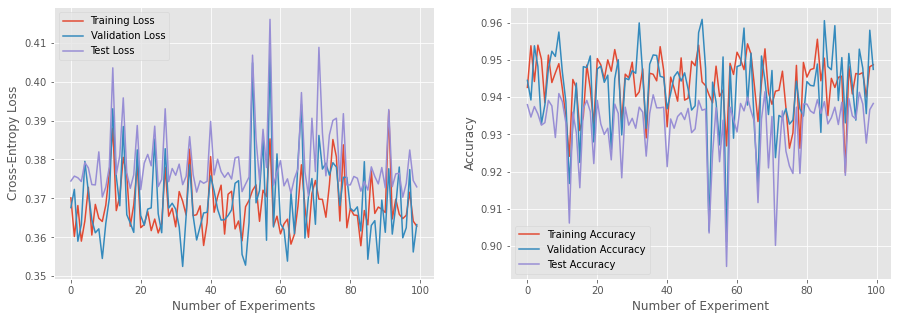

In [10]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(exp_losses_train, label='Training Loss')
plt.plot(exp_losses_val, label='Validation Loss')
plt.plot(test_loss_exp, label='Test Loss')
plt.xlabel('Number of Experiments')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc_exp, label='Training Accuracy')
plt.plot(val_acc_exp, label='Validation Accuracy')
plt.plot(test_accuracy_exp, label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

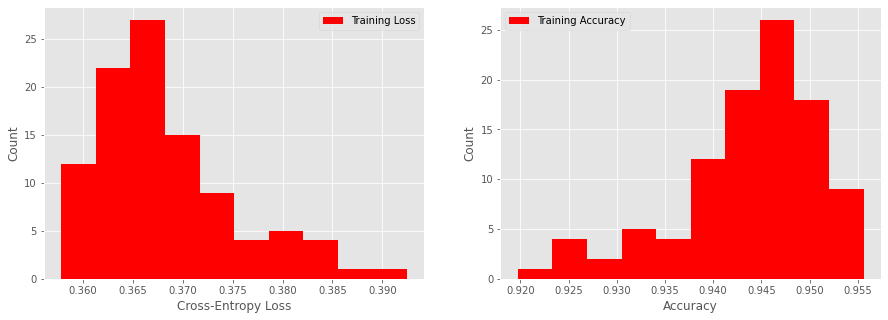

In [11]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.hist(exp_losses_train, label='Training Loss',color='r')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(train_acc_exp, label='Training Accuracy',color='r')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

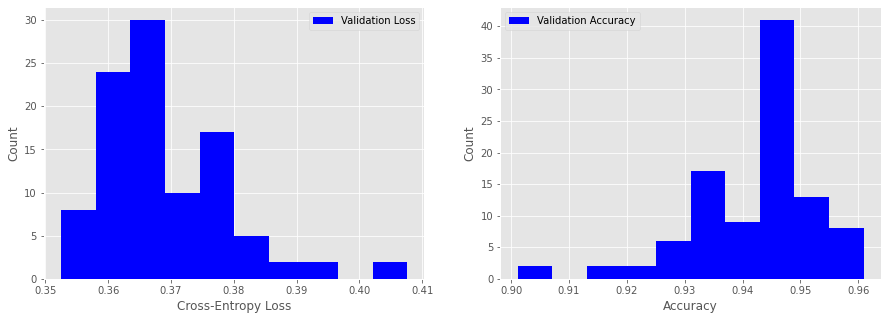

In [12]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(exp_losses_val, label='Validation Loss',color='b')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(val_acc_exp, label='Validation Accuracy',color='b')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

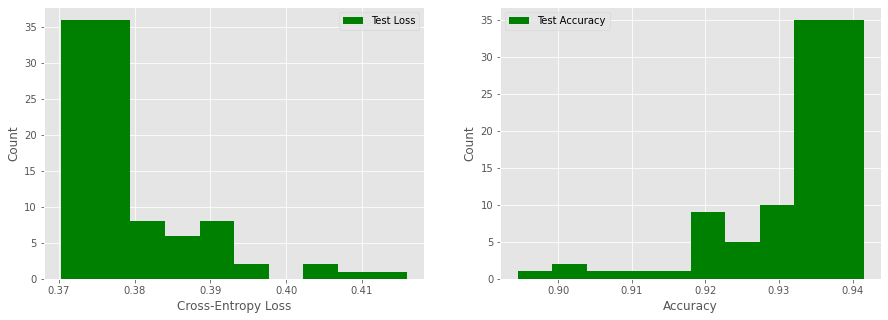

In [13]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(test_loss_exp, label='Test Loss',color='g')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(test_accuracy_exp, label='Test Accuracy',color='g')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

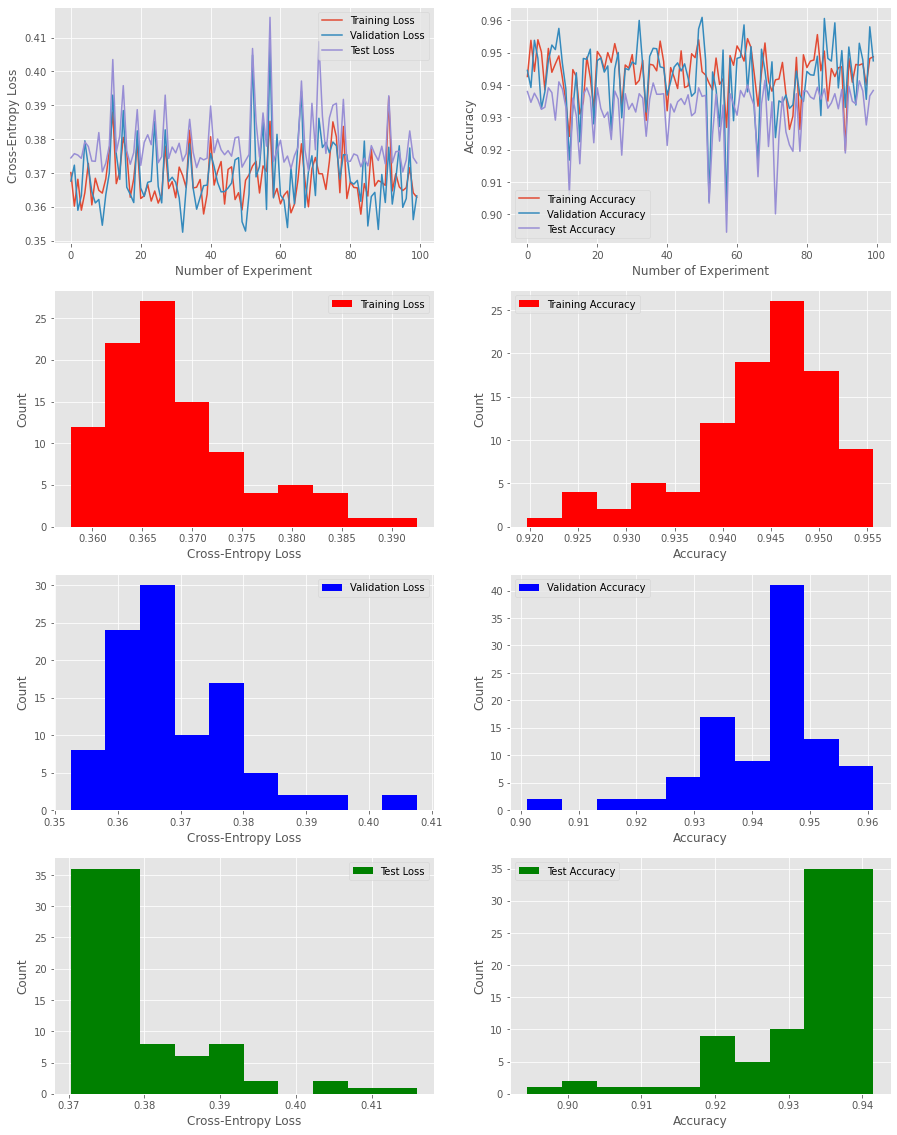

In [20]:
plt.subplots(figsize=(15,20))

plt.subplot(421)
plt.plot(exp_losses_train, label='Training Loss')
plt.plot(exp_losses_val, label='Validation Loss')
plt.plot(test_loss_exp, label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(422)
plt.plot(train_acc_exp, label='Training Accuracy')
plt.plot(val_acc_exp, label='Validation Accuracy')
plt.plot(test_accuracy_exp, label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(423)
plt.hist(exp_losses_train, label='Training Loss',color='r')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(424)
plt.hist(train_acc_exp, label='Training Accuracy',color='r')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(425)
plt.hist(exp_losses_val, label='Validation Loss',color='b')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(426)
plt.hist(val_acc_exp, label='Validation Accuracy',color='b')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(427)
plt.hist(test_loss_exp, label='Test Loss',color='g')
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(428)
plt.hist(test_accuracy_exp, label='Test Accuracy',color='g')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()


plt.show()